<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft, fftfreq
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_excel('df_total_modelling.xlsx').drop('Unnamed: 0', axis = 1)

In [3]:
df

Дата   Цена     anger  commentsCount  day   disgust  enthusiasm  \
0   2019-09-09  41.08  0.187834      13.100000   12  0.005203    0.141477   
1   2019-09-10  41.45  0.011937       9.142857   11  0.001426    0.001466   
2   2019-09-11  41.90  0.071225       8.125000   10  0.001724    0.015321   
3   2019-09-12  41.47  0.004007      10.000000    9  0.000516    0.007606   
4   2019-09-13  41.31  0.004803       2.000000    8  0.001494    0.122616   
..         ...    ...       ...            ...  ...       ...         ...   
822 2023-01-06  33.36  0.005426       0.000000   16  0.001635    0.978233   
823 2023-01-09  33.26  0.204809       2.666667   13  0.002308    0.003188   
824 2023-01-10  33.29  0.000078       0.000000   12  0.000042    0.000076   
825 2023-01-11  33.61  0.004518       0.000000   10  0.001498    0.981042   
826 2023-01-12  33.84  0.000105       3.000000    9  0.000052    0.000088   

         fear  happiness  likesCount  ...   neutral   sadness  tonality_score  \
0    0.075767   0.037670   17.900000  ...  0.545334  0.006715       -0.379486   
1    0.076198   0.065508   11.142857  ...  0.712584  0.130882        0.093838   
2    0.018321   0.008284   12.250000  ...  0.884628  0.000497       -0.265680   
3    0.000809   0.000982    4.000000  ...  0.985694  0.000387       -0.037726   
4    0.003073   0.002591    4.000000  ...  0.864497  0.000925       -0.428545   
..        ...        ...         ...  ...       ...       ...             ...   
822  0.001538   0.003336    0.000000  ...  0.008170  0.001661        0.034657   
823  0.003816   0.006235   12.666667  ...  0.778796  0.000849       -0.360490   
824  0.000073   0.000078    0.000000  ...  0.999574  0.000079       -0.126619   
825  0.002239   0.001728    0.000000  ...  0.005594  0.003381       -0.591406   
826  0.000074   0.000115    1.000000  ...  0.999450  0.000116        0.237804   

     toxic_value  year  price_lag_1  price_lag_2  price_lag_3  price_lag_4  \
0       0.254216  2022          NaN          NaN          NaN          NaN   
1       0.224686  2022        41.08          NaN          NaN          NaN   
2       0.054634  2022        41.45        41.08          NaN          NaN   
3       0.120622  2022        41.90        41.45        41.08          NaN   
4       0.136257  2022        41.47        41.90        41.45        41.08   
..           ...   ...          ...          ...          ...          ...   
822     0.013250  2019        33.13        33.28        33.40        32.87   
823     0.302770  2019        33.36        33.13        33.28        33.40   
824     0.056195  2019        33.26        33.36        33.13        33.28   
825     0.026143  2019        33.29        33.26        33.36        33.13   
826     0.022220  2019        33.61        33.29        33.26        33.36   

     price_lag_5  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
822        32.21  
823        32.87  
824        33.40  
825        33.28  
826        33.13  

[827 rows x 21 columns]

In [4]:
def calculate_delta(time_series, lag=1):
    """
    Рассчитывает дельту (разницу) для временного ряда.
    
    Args:
        time_series (pd.Series): Временной ряд, для которого нужно рассчитать дельту.
        lag (int): Шаг (лаг) для расчета дельты. По умолчанию равен 1.
        
    Returns:
        pd.Series: Временной ряд дельт.
    """
    # Проверка типа входных данных
    if not isinstance(time_series, pd.Series):
        raise ValueError("time_series должен быть объектом pandas Series")
    
    # Рассчитываем дельту
    delta = time_series.diff(periods=lag)
    
    return delta

In [5]:
delta_series = calculate_delta(df['Цена'])
df['Изменение цены'] = delta_series
df = df.fillna(method = 'bfill')

In [6]:
def make_features(max_lag, rolling_mean_size,df ):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['Изменение цены'].shift(lag) 
    df['rolling_mean'] = df['Изменение цены'].shift().rolling(rolling_mean_size).mean()

In [7]:
make_features(5,5,df)

In [8]:
df = df.drop(['price_lag_1','price_lag_2','price_lag_3','price_lag_4','price_lag_5'], axis = 1)

In [9]:
df

Дата   Цена     anger  commentsCount  day   disgust  enthusiasm  \
0   2019-09-09  41.08  0.187834      13.100000   12  0.005203    0.141477   
1   2019-09-10  41.45  0.011937       9.142857   11  0.001426    0.001466   
2   2019-09-11  41.90  0.071225       8.125000   10  0.001724    0.015321   
3   2019-09-12  41.47  0.004007      10.000000    9  0.000516    0.007606   
4   2019-09-13  41.31  0.004803       2.000000    8  0.001494    0.122616   
..         ...    ...       ...            ...  ...       ...         ...   
822 2023-01-06  33.36  0.005426       0.000000   16  0.001635    0.978233   
823 2023-01-09  33.26  0.204809       2.666667   13  0.002308    0.003188   
824 2023-01-10  33.29  0.000078       0.000000   12  0.000042    0.000076   
825 2023-01-11  33.61  0.004518       0.000000   10  0.001498    0.981042   
826 2023-01-12  33.84  0.000105       3.000000    9  0.000052    0.000088   

         fear  happiness  likesCount  ...  tonality_score  toxic_value  year  \
0    0.075767   0.037670   17.900000  ...       -0.379486     0.254216  2022   
1    0.076198   0.065508   11.142857  ...        0.093838     0.224686  2022   
2    0.018321   0.008284   12.250000  ...       -0.265680     0.054634  2022   
3    0.000809   0.000982    4.000000  ...       -0.037726     0.120622  2022   
4    0.003073   0.002591    4.000000  ...       -0.428545     0.136257  2022   
..        ...        ...         ...  ...             ...          ...   ...   
822  0.001538   0.003336    0.000000  ...        0.034657     0.013250  2019   
823  0.003816   0.006235   12.666667  ...       -0.360490     0.302770  2019   
824  0.000073   0.000078    0.000000  ...       -0.126619     0.056195  2019   
825  0.002239   0.001728    0.000000  ...       -0.591406     0.026143  2019   
826  0.000074   0.000115    1.000000  ...        0.237804     0.022220  2019   

     Изменение цены  lag_1  lag_2  lag_3  lag_4  lag_5  rolling_mean  
0              0.37    NaN    NaN    NaN    NaN    NaN           NaN  
1              0.37   0.37    NaN    NaN    NaN    NaN           NaN  
2              0.45   0.37   0.37    NaN    NaN    NaN           NaN  
3             -0.43   0.45   0.37   0.37    NaN    NaN           NaN  
4             -0.16  -0.43   0.45   0.37   0.37    NaN           NaN  
..              ...    ...    ...    ...    ...    ...           ...  
822            0.23  -0.15  -0.12   0.53   0.66   0.07         0.198  
823           -0.10   0.23  -0.15  -0.12   0.53   0.66         0.230  
824            0.03  -0.10   0.23  -0.15  -0.12   0.53         0.078  
825            0.32   0.03  -0.10   0.23  -0.15  -0.12        -0.022  
826            0.23   0.32   0.03  -0.10   0.23  -0.15         0.066  

[827 rows x 23 columns]

In [10]:
main_cols = df.columns[2:-6]

In [11]:
main_cols = pd.Series(main_cols).drop([2,8], axis = 0)
main_cols

0              anger
1      commentsCount
3            disgust
4         enthusiasm
5               fear
6          happiness
7         likesCount
9            neutral
10           sadness
11    tonality_score
12       toxic_value
13              year
14    Изменение цены
dtype: object

In [12]:
main_cols.index = [i for i in range(len(main_cols))]

In [13]:
df[main_cols]

anger  commentsCount   disgust  enthusiasm      fear  happiness  \
0    0.187834      13.100000  0.005203    0.141477  0.075767   0.037670   
1    0.011937       9.142857  0.001426    0.001466  0.076198   0.065508   
2    0.071225       8.125000  0.001724    0.015321  0.018321   0.008284   
3    0.004007      10.000000  0.000516    0.007606  0.000809   0.000982   
4    0.004803       2.000000  0.001494    0.122616  0.003073   0.002591   
..        ...            ...       ...         ...       ...        ...   
822  0.005426       0.000000  0.001635    0.978233  0.001538   0.003336   
823  0.204809       2.666667  0.002308    0.003188  0.003816   0.006235   
824  0.000078       0.000000  0.000042    0.000076  0.000073   0.000078   
825  0.004518       0.000000  0.001498    0.981042  0.002239   0.001728   
826  0.000105       3.000000  0.000052    0.000088  0.000074   0.000115   

     likesCount   neutral   sadness  tonality_score  toxic_value  year  \
0     17.900000  0.545334  0.006715       -0.379486     0.254216  2022   
1     11.142857  0.712584  0.130882        0.093838     0.224686  2022   
2     12.250000  0.884628  0.000497       -0.265680     0.054634  2022   
3      4.000000  0.985694  0.000387       -0.037726     0.120622  2022   
4      4.000000  0.864497  0.000925       -0.428545     0.136257  2022   
..          ...       ...       ...             ...          ...   ...   
822    0.000000  0.008170  0.001661        0.034657     0.013250  2019   
823   12.666667  0.778796  0.000849       -0.360490     0.302770  2019   
824    0.000000  0.999574  0.000079       -0.126619     0.056195  2019   
825    0.000000  0.005594  0.003381       -0.591406     0.026143  2019   
826    1.000000  0.999450  0.000116        0.237804     0.022220  2019   

     Изменение цены  
0              0.37  
1              0.37  
2              0.45  
3             -0.43  
4             -0.16  
..              ...  
822            0.23  
823           -0.10  
824            0.03  
825            0.32  
826            0.23  

[827 rows x 13 columns]

In [17]:
df[main_cols].describe().to_excel('describe.xlsx')

In [9]:
def autocorr(dataframe):
    for col in dataframe.columns:
        time_series = dataframe[col]
        # Вычисление автокорреляции
        autocorrelation = time_series.autocorr()

        # Построение графика автокорреляции
        plt.figure(figsize=(12, 6))
        sm.graphics.tsa.plot_acf(time_series, lags=30)  # Рассчитываем автокорреляцию с лагом до 30
        plt.title(f'Autocorrelation Plot {col}')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.grid(True)
        plt.show()

        print("Автокорреляция:", autocorrelation)

<Figure size 864x432 with 0 Axes>

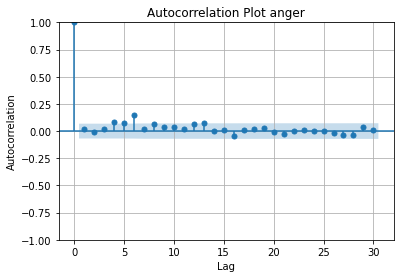

Автокорреляция: 0.023152967836227455


<Figure size 864x432 with 0 Axes>

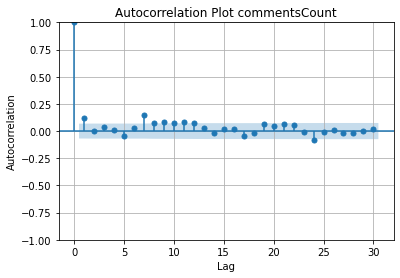

Автокорреляция: 0.12054844786690427


<Figure size 864x432 with 0 Axes>

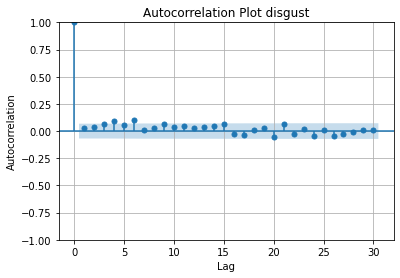

Автокорреляция: 0.03166983063957733


<Figure size 864x432 with 0 Axes>

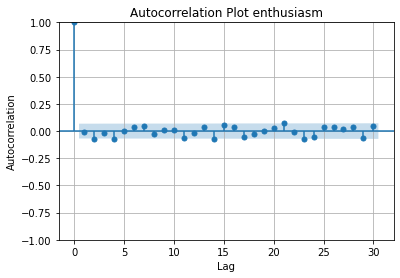

Автокорреляция: -0.010298678984313843


<Figure size 864x432 with 0 Axes>

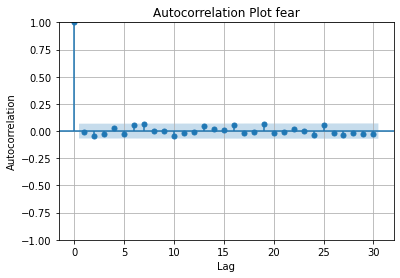

Автокорреляция: -0.00996975102891516


<Figure size 864x432 with 0 Axes>

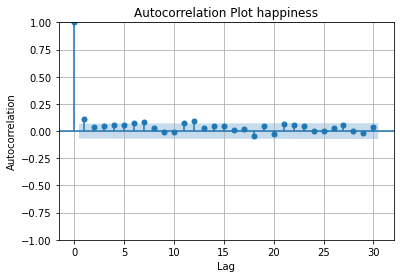

Автокорреляция: 0.11032653018554343


<Figure size 864x432 with 0 Axes>

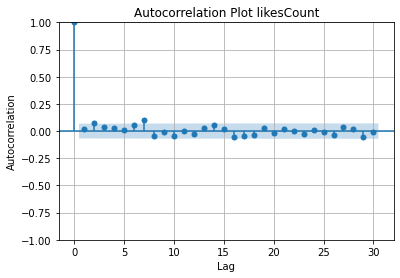

Автокорреляция: 0.021580159999908817


<Figure size 864x432 with 0 Axes>

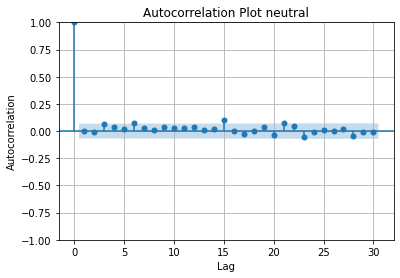

Автокорреляция: 0.002687617729716354


<Figure size 864x432 with 0 Axes>

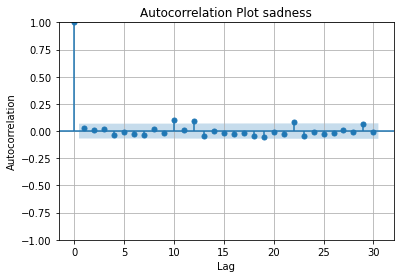

Автокорреляция: 0.027846930079310172


<Figure size 864x432 with 0 Axes>

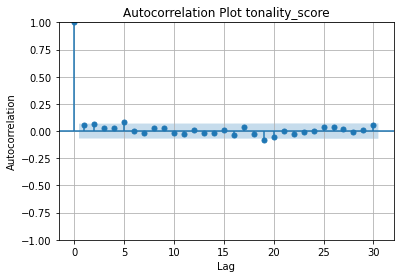

Автокорреляция: 0.05473647050890455


<Figure size 864x432 with 0 Axes>

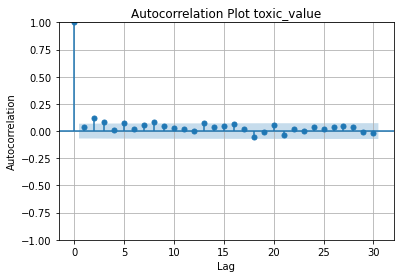

Автокорреляция: 0.036010136595564075


In [10]:
autocorr(df[main_cols])

In [11]:
def analyze_stationarity(data):
    """
    Функция для анализа стационарности временных рядов
    
    Параметры:
    - data: pandas.DataFrame с временными рядами. Каждый столбец представляет собой один временной ряд.
    
    Возвращает:
    - Результат анализа стационарности для каждого временного ряда в формате DataFrame.
    """
    results = []
    for column in data.columns:
        result = {}
        result['Column'] = column
        
        # Проверка на стационарность с помощью теста Дики-Фуллера
        result['ADF Statistic'] = sm.tsa.adfuller(data[column])[0]
        result['p-value'] = sm.tsa.adfuller(data[column])[1]
        result['Critical Values'] = sm.tsa.adfuller(data[column])[4]
        result['Stationary'] = result['p-value'] < 0.05
        
        results.append(result)
    
    # Создание DataFrame с результатами анализа
    results_df = pd.DataFrame(results)
    return results_df

In [18]:
df.index = df['Дата']

In [129]:
analyze_stationarity(df[main_cols])

Column  ADF Statistic       p-value  \
0            anger      -8.784198  2.332477e-14   
1    commentsCount      -5.600764  1.266360e-06   
2          disgust      -8.949270  8.813909e-15   
3       enthusiasm     -16.260246  3.571829e-29   
4             fear     -28.992870  0.000000e+00   
5        happiness     -25.688435  0.000000e+00   
6       likesCount     -18.666602  2.045960e-30   
7          neutral     -28.580522  0.000000e+00   
8          sadness     -27.915597  0.000000e+00   
9   tonality_score     -27.219389  0.000000e+00   
10     toxic_value     -13.805973  8.400988e-26   

                                      Critical Values  Stationary  
0   {'1%': -3.438340089700066, '5%': -2.8650668167...        True  
1   {'1%': -3.438399099271788, '5%': -2.8650928286...        True  
2   {'1%': -3.438340089700066, '5%': -2.8650668167...        True  
3   {'1%': -3.438320611647225, '5%': -2.8650582305...        True  
4   {'1%': -3.4382915719823934, '5%': -2.865045429...        True  
5   {'1%': -3.4382915719823934, '5%': -2.865045429...        True  
6   {'1%': -3.438301228330467, '5%': -2.8650496859...        True  
7   {'1%': -3.4382915719823934, '5%': -2.865045429...        True  
8   {'1%': -3.4382915719823934, '5%': -2.865045429...        True  
9   {'1%': -3.4382915719823934, '5%': -2.865045429...        True  
10  {'1%': -3.438310908190086, '5%': -2.8650539530...        True

In [134]:
def analyze_trend(time_series, name_col):
    """
    Функция для анализа тренда во временном ряде.
    Параметры:
    - time_series: pandas.Series с временным рядом.
    # Применяем скользящее среднее для сглаживания ряда и выделения тренда
    """
    rolling_mean = time_series.rolling(window=12).mean()
    
    # Визуализация временного ряда с трендом
    plt.figure(figsize=(10, 5), facecolor= 'white')
    plt.plot(time_series, label='Original Time Series')
    plt.plot(rolling_mean, color='red', label='Trend (Rolling Mean)')
    plt.title(f'Time Series with Trend Analysis {name_col}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

0it [00:00, ?it/s]

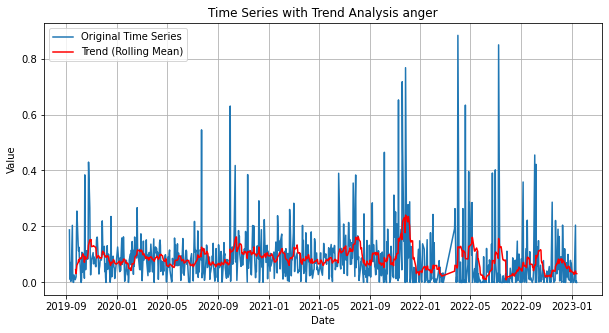

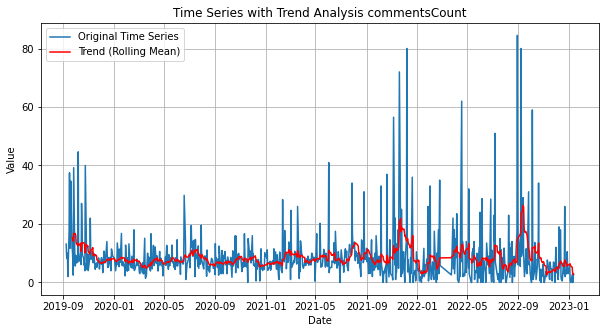

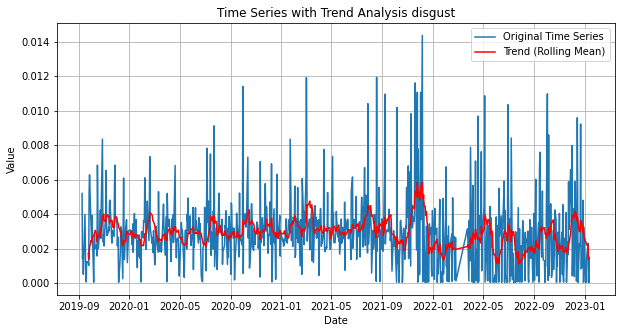

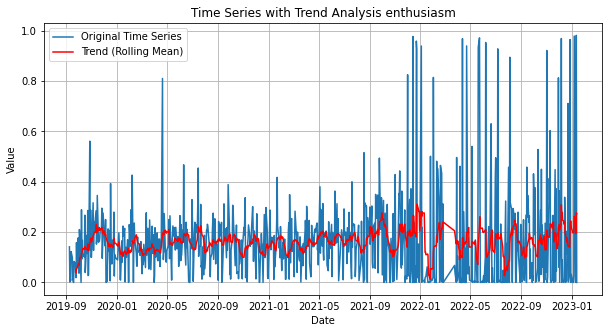

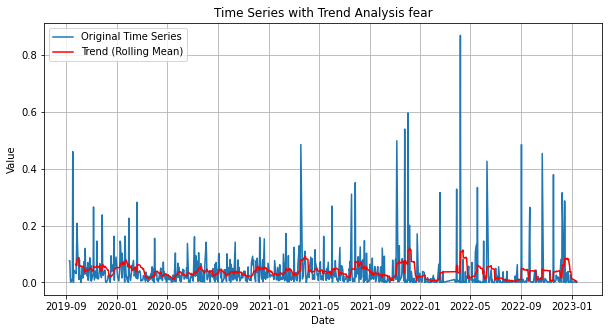

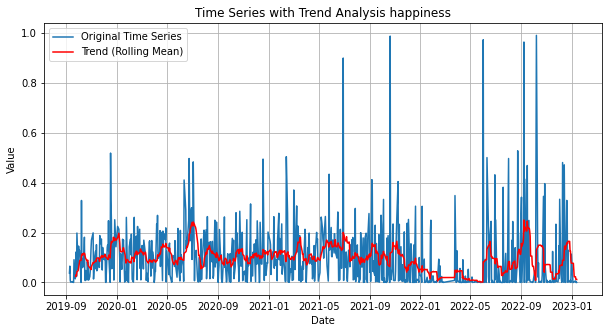

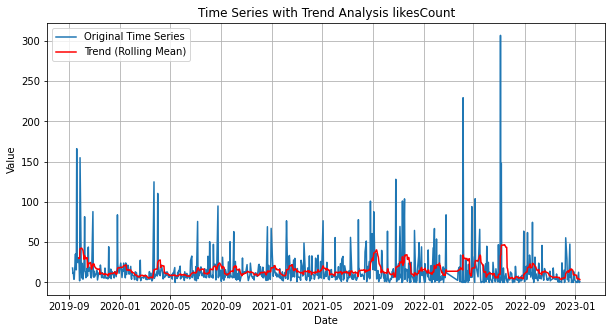

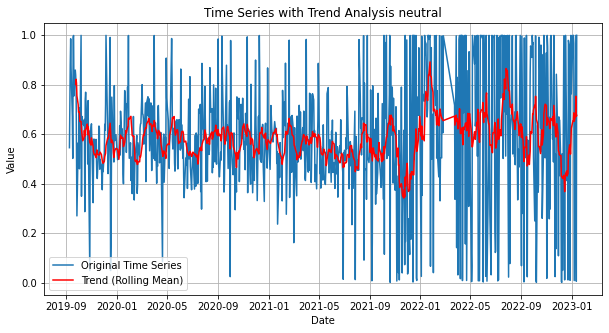

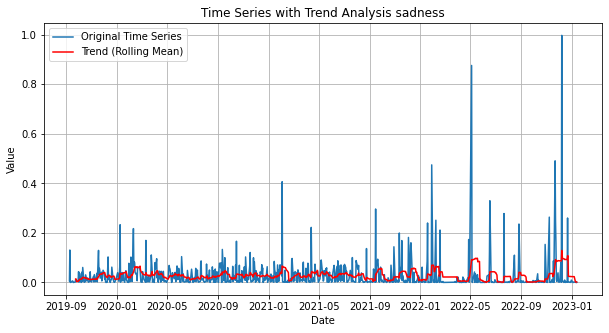

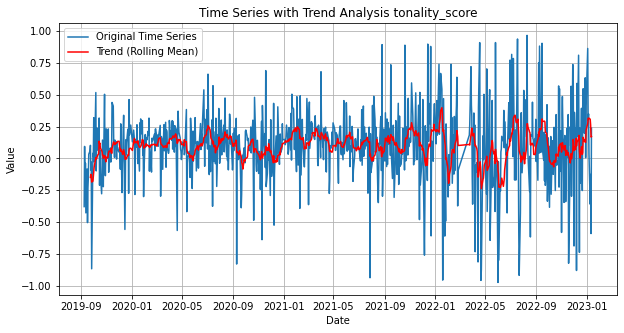

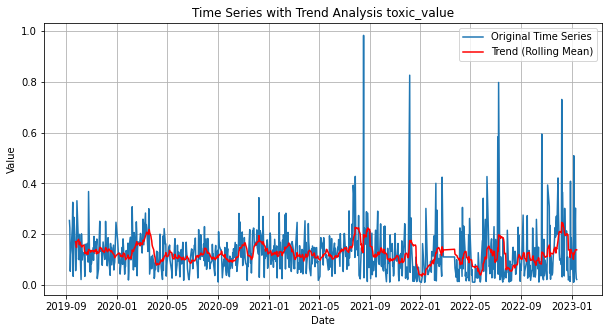

In [135]:
from tqdm.notebook import tqdm
for num, val in tqdm(enumerate(main_cols)):
    analyze_trend(df[main_cols[num]], val)

In [15]:
medians = []
for col in main_cols:
    median = df[col].median()
    medians.append(median)

In [16]:
medians

[0.06458883721213417,
 6.8,
 0.002772708175306877,
 0.1442496970951955,
 0.01607327295005234,
 0.06699690595511736,
 8.714285714285714,
 0.5698832469504974,
 0.006089545791231406,
 0.11089884593255,
 0.1128218634100154]

In [17]:
means = []
for col in main_cols:
    mean = df[col].mean()
    means.append(mean)

In [18]:
means

[0.08362125104258206,
 8.488736778582018,
 0.002923010689889669,
 0.16327273448349686,
 0.03823652351840538,
 0.0979305126385693,
 14.943938827979267,
 0.5856460595891693,
 0.02836990823108898,
 0.09465083915302797,
 0.12546861681514063]

In [19]:
table_medians = pd.DataFrame(zip(main_cols, medians), columns = ['Метрика','Значение'])
table_medians.to_excel('Медианные значения метрик.xlsx')

In [21]:
stds = []
for col in main_cols:
    std = df[col].std()
    stds.append(std)

In [22]:
table_stds = pd.DataFrame(zip(main_cols, stds), columns = ['Метрика','Значение'])
table_stds.to_excel('Стандартное отклонение метрик.xlsx')

In [23]:
stds

[0.09928231524164319,
 8.720792245878556,
 0.002060555064698705,
 0.1685595323485117,
 0.0729893222837145,
 0.12312695226062619,
 22.981001275798192,
 0.24847886409100772,
 0.06712402014875192,
 0.2832659017398555,
 0.09433307784485934]

In [24]:
def calculate_spectral_characteristics(time_series, sampling_frequency):
    """
    Функция для расчета спектральных характеристик временного ряда с помощью анализа Фурье.

    Параметры:
    - time_series: pandas.Series с временным рядом.
    - sampling_frequency: float, частота дискретизации (сколько наблюдений в единицу времени).

    Возвращает:
    - spectrums: pandas.DataFrame с частотами и амплитудами спектра.
    """
    # Вычисляем длину временного ряда
    n = len(time_series)

    # Применяем преобразование Фурье
    fft_values = fft(np.array(time_series))
    
    # Вычисляем частоты
    frequencies = fftfreq(n, 1 / sampling_frequency)

    # Отсекаем отрицательные частоты и их значения спектра
    positive_mask = frequencies > 0
    positive_frequencies = frequencies[positive_mask]
    positive_fft_values = np.abs(fft_values[positive_mask]) / n  # Нормализуем по длине ряда

    # Сохраняем результаты в DataFrame
    spectrums = pd.DataFrame({'Frequency': positive_frequencies, 'Amplitude': positive_fft_values})
    
    return spectrums

In [25]:
for i in main_cols:
    spectrums = calculate_spectral_characteristics(df[main_cols[0]], 1).to_excel('Спектральные характеристики.xlsx')

In [ ]:
seasonal_index_monthly.to_excel('seasonal_par.xlsx')

In [ ]:
df['Дата'].min()

In [28]:
df['Дата'].max()

Timestamp('2023-01-12 00:00:00')

In [14]:
df_copy = df.copy()

In [15]:
df_copy.index = df_copy['Дата']

In [16]:
df_copy = df_copy.drop(['Дата', 'Цена'], axis = 1)

In [17]:
df_copy = df_copy.fillna(method='bfill')

In [18]:
df_copy.head()

anger  commentsCount  day   disgust  enthusiasm      fear  \
Дата                                                                       
2019-09-09  0.187834      13.100000   12  0.005203    0.141477  0.075767   
2019-09-10  0.011937       9.142857   11  0.001426    0.001466  0.076198   
2019-09-11  0.071225       8.125000   10  0.001724    0.015321  0.018321   
2019-09-12  0.004007      10.000000    9  0.000516    0.007606  0.000809   
2019-09-13  0.004803       2.000000    8  0.001494    0.122616  0.003073   

            happiness  likesCount  month   neutral  ...  tonality_score  \
Дата                                                ...                   
2019-09-09   0.037670   17.900000      3  0.545334  ...       -0.379486   
2019-09-10   0.065508   11.142857      3  0.712584  ...        0.093838   
2019-09-11   0.008284   12.250000      3  0.884628  ...       -0.265680   
2019-09-12   0.000982    4.000000      3  0.985694  ...       -0.037726   
2019-09-13   0.002591    4.000000      3  0.864497  ...       -0.428545   

            toxic_value  year  Изменение цены  lag_1  lag_2  lag_3  lag_4  \
Дата                                                                        
2019-09-09     0.254216  2022            0.37   0.37   0.37   0.37   0.37   
2019-09-10     0.224686  2022            0.37   0.37   0.37   0.37   0.37   
2019-09-11     0.054634  2022            0.45   0.37   0.37   0.37   0.37   
2019-09-12     0.120622  2022           -0.43   0.45   0.37   0.37   0.37   
2019-09-13     0.136257  2022           -0.16  -0.43   0.45   0.37   0.37   

            lag_5  rolling_mean  
Дата                             
2019-09-09   0.37          0.12  
2019-09-10   0.37          0.12  
2019-09-11   0.37          0.12  
2019-09-12   0.37          0.12  
2019-09-13   0.37          0.12  

[5 rows x 21 columns]

In [88]:
df_copy.to_excel('df_total_modelling_27.05.2024.xlsx')

In [19]:
df_copy = df_copy.drop(['lag_1','lag_2','lag_3','lag_4','lag_5'], axis = 1)

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_copy, train_size=0.8, shuffle = False)
y_train = train['Изменение цены']
y_test = test['Изменение цены']
x_train = train.drop('Изменение цены', axis = 1)
x_test= test.drop('Изменение цены', axis = 1)

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

In [23]:
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [24]:
df_results = pd.DataFrame(columns = ['Модель','MSE','MAE'])
model_names = []
mse = []
mae = []
mape = []

In [25]:
def model_checking(model):
    # Заставляем модель моделировать значения на тестовой выборке
    lin_pred = model.predict(x_test)
    # Рассчитываем MSE модели для выборка корректного сценария
    print(f"Значение MSE: {mean_squared_error(y_test, y_test - lin_pred)}")
    model_names.append(str(model))
    mse.append(mean_squared_error(y_test, y_test - lin_pred))
    mae.append(mean_absolute_error(y_test, y_test - lin_pred))
    mape.append(mean_absolute_percentage_error(y_test, y_test - lin_pred))
    lin_pred = pd.Series(lin_pred)
    lin_pred.index = y_test.index
    # Формируем график-иллюстрацию результатов моделирования
    
    plt.figure(figsize = (12,8), facecolor = 'white')
    plt.grid()
    plt.title(f'Результаты аппробации модели {model}')
    plt.plot(pd.Series(y_test-lin_pred), color = 'blue', label = 'Смоделированные значения')
    plt.plot(pd.Series(y_test), color = 'red', label = 'Тестовая выборка')
    plt.legend()

Значение MSE: 0.11566225126913471


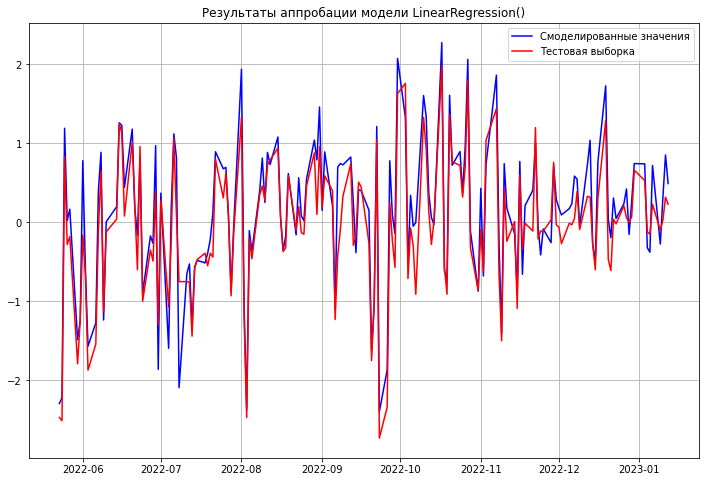

In [26]:
model_checking(lin_reg)

In [206]:
params = {"n_estimators" : [1,10,100,200,400,500,600,700,800,900,1000],
         "learning_rate" :[0.001, 0.005,0.01,0.05, 0.1],
         "loss" : ('linear', 'square', 'exponential')}

grid_search = GridSearchCV(ada_reg, param_grid=params, n_jobs = -1, cv = 5, 
                           verbose = 100, return_train_score=True)
grid_search.fit(x_train, y_train)

display(grid_search.best_estimator_)
display(grid_search.best_params_)

Fitting 5 folds for each of 165 candidates, totalling 825 fits


AdaBoostRegressor(learning_rate=0.005, loss='exponential', n_estimators=100)

{'learning_rate': 0.005, 'loss': 'exponential', 'n_estimators': 100}

In [35]:
ada_reg = AdaBoostRegressor(learning_rate = 0.005, loss =  'exponential', n_estimators= 100)

ada_reg.fit(x_train, y_train)

AdaBoostRegressor(learning_rate=0.005, loss='exponential', n_estimators=100)

Значение MSE: 0.02088250405622045


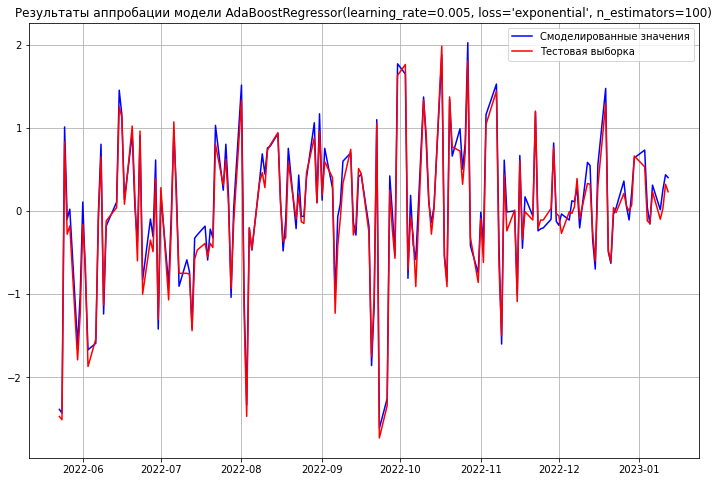

In [36]:
model_checking(ada_reg)

In [210]:
params = {"n_estimators" : [1,10,100,200,400,500,600,700,800,900,1000],
         "max_depth" : [2,3,4,5,6,7,8,9,10],
          "min_samples_split" : [2,3,4,5,6,7,8]}

grid_search = GridSearchCV(for_reg, param_grid=params, n_jobs = -1, cv = 5, 
                           verbose = 100, return_train_score=True)
grid_search.fit(x_train, y_train)

display(grid_search.best_estimator_)
display(grid_search.best_params_)

Fitting 5 folds for each of 693 candidates, totalling 3465 fits


RandomForestRegressor(max_depth=2, min_samples_split=8, n_estimators=200)

{'max_depth': 2, 'min_samples_split': 8, 'n_estimators': 200}

In [32]:
for_reg = RandomForestRegressor(max_depth=2, min_samples_split= 8, n_estimators = 200)
for_reg.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, min_samples_split=8, n_estimators=200)

Значение MSE: 0.03522510236365643


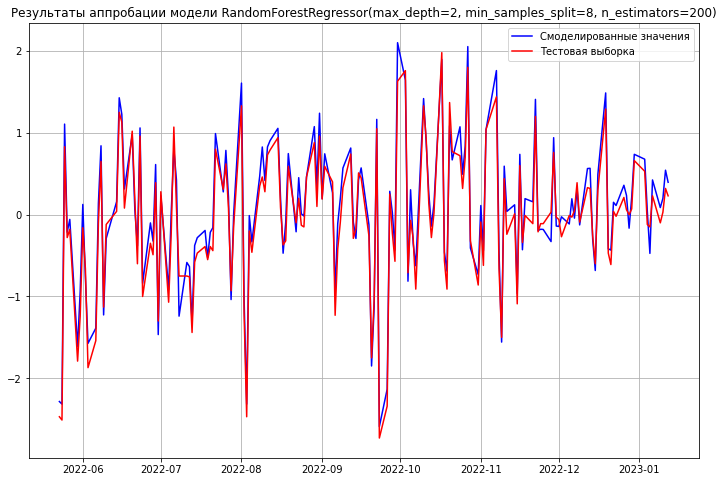

In [33]:
model_checking(for_reg)

In [218]:
params = {"learning_rate" : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
         "n_estimators" : [50,100,250,500,750,1000],
         "min_samples_split" : [4,5,8],
         "max_depth": [3,4,5,6]}

grid_search = GridSearchCV(grad_reg, param_grid=params, n_jobs = -1, cv = 5, 
                           verbose = 100, return_train_score=True)
grid_search.fit(x_train, y_train)

display(grid_search.best_estimator_)
display(grid_search.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GradientBoostingRegressor(learning_rate=0.001, max_depth=6, min_samples_split=5,
                          n_estimators=50)

{'learning_rate': 0.001,
 'max_depth': 6,
 'min_samples_split': 5,
 'n_estimators': 50}

In [30]:
grad_reg = GradientBoostingRegressor(learning_rate=0.001, 
                                     max_depth=6, min_samples_split=5, n_estimators=50)
grad_reg.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=6, min_samples_split=5,
                          n_estimators=50)

Значение MSE: 0.00011978541732571558


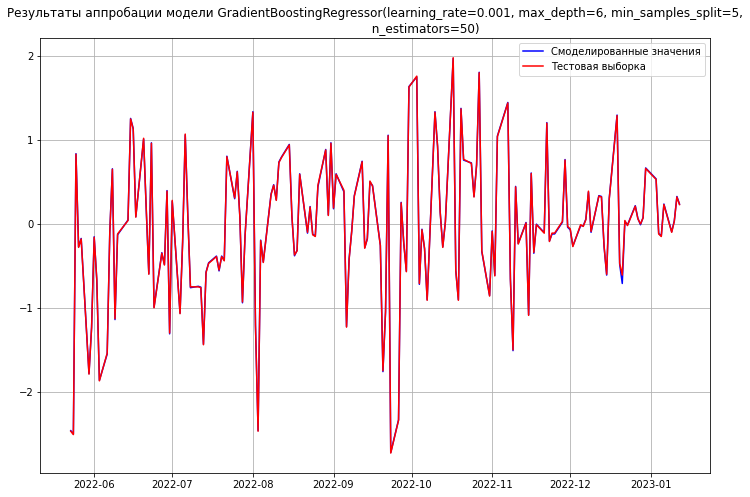

In [31]:
model_checking(grad_reg)

In [227]:
cat_reg = CatBoostRegressor()
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat_reg.grid_search(grid,
                                       X=x_train,
                                       y=y_train,
                                       plot=True)

C:\Users\Iljam\anaconda3\lib\site-packages\catboost\core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9699832	test: 0.9585611	best: 0.9585611 (0)	total: 33.1ms	remaining: 33s
1:	learn: 0.9672014	test: 0.9581917	best: 0.9581917 (1)	total: 34.2ms	remaining: 17.1s
2:	learn: 0.9638354	test: 0.9593574	best: 0.9581917 (1)	total: 35.2ms	remaining: 11.7s
3:	learn: 0.9613881	test: 0.9596584	best: 0.9581917 (1)	total: 36.1ms	remaining: 8.99s
4:	learn: 0.9595135	test: 0.9575837	best: 0.9575837 (4)	total: 37.2ms	remaining: 7.4s
5:	learn: 0.9568324	test: 0.9570891	best: 0.9570891 (5)	total: 38.3ms	remaining: 6.34s
6:	learn: 0.9551988	test: 0.9571751	best: 0.9570891 (5)	total: 39.2ms	remaining: 5.57s
7:	learn: 0.9524767	test: 0.9579233	best: 0.9570891 (5)	total: 40.2ms	remaining: 4.98s
8:	learn: 0.9507093	test: 0.9580518	best: 0.9570891 (5)	total: 41.3ms	remaining: 4.55s
9:	learn: 0.9495830	test: 0.9582671	best: 0.9570891 (5)	total: 42.6ms	remaining: 4.21s
10:	learn: 0.9483860	test: 0.9576874	best: 0.9570891 (5)	total: 43.5ms	remaining: 3.91s
11:	learn: 0.9466401	test: 0.9574968	best: 0.

197:	learn: 0.7254991	test: 0.9703741	best: 0.9492938 (56)	total: 206ms	remaining: 832ms
198:	learn: 0.7244362	test: 0.9703143	best: 0.9492938 (56)	total: 207ms	remaining: 831ms
199:	learn: 0.7226696	test: 0.9689403	best: 0.9492938 (56)	total: 207ms	remaining: 829ms
200:	learn: 0.7211407	test: 0.9679558	best: 0.9492938 (56)	total: 208ms	remaining: 828ms
201:	learn: 0.7203407	test: 0.9682022	best: 0.9492938 (56)	total: 209ms	remaining: 826ms
202:	learn: 0.7195740	test: 0.9687178	best: 0.9492938 (56)	total: 210ms	remaining: 824ms
203:	learn: 0.7185433	test: 0.9683684	best: 0.9492938 (56)	total: 211ms	remaining: 822ms
204:	learn: 0.7180674	test: 0.9688115	best: 0.9492938 (56)	total: 211ms	remaining: 820ms
205:	learn: 0.7170657	test: 0.9694295	best: 0.9492938 (56)	total: 212ms	remaining: 818ms
206:	learn: 0.7160988	test: 0.9699807	best: 0.9492938 (56)	total: 213ms	remaining: 817ms
207:	learn: 0.7152521	test: 0.9701328	best: 0.9492938 (56)	total: 214ms	remaining: 815ms
208:	learn: 0.7139012

383:	learn: 0.5824821	test: 0.9849799	best: 0.9492938 (56)	total: 380ms	remaining: 609ms
384:	learn: 0.5814772	test: 0.9845510	best: 0.9492938 (56)	total: 381ms	remaining: 608ms
385:	learn: 0.5806770	test: 0.9852223	best: 0.9492938 (56)	total: 382ms	remaining: 607ms
386:	learn: 0.5800176	test: 0.9855650	best: 0.9492938 (56)	total: 383ms	remaining: 606ms
387:	learn: 0.5793923	test: 0.9856507	best: 0.9492938 (56)	total: 383ms	remaining: 605ms
388:	learn: 0.5785869	test: 0.9858687	best: 0.9492938 (56)	total: 384ms	remaining: 603ms
389:	learn: 0.5774647	test: 0.9862520	best: 0.9492938 (56)	total: 385ms	remaining: 602ms
390:	learn: 0.5772804	test: 0.9864367	best: 0.9492938 (56)	total: 386ms	remaining: 601ms
391:	learn: 0.5764268	test: 0.9865210	best: 0.9492938 (56)	total: 387ms	remaining: 601ms
392:	learn: 0.5753389	test: 0.9865164	best: 0.9492938 (56)	total: 388ms	remaining: 600ms
393:	learn: 0.5744075	test: 0.9865527	best: 0.9492938 (56)	total: 389ms	remaining: 599ms
394:	learn: 0.5739012

559:	learn: 0.4663618	test: 1.0128534	best: 0.9492938 (56)	total: 554ms	remaining: 436ms
560:	learn: 0.4652428	test: 1.0132867	best: 0.9492938 (56)	total: 556ms	remaining: 435ms
561:	learn: 0.4644010	test: 1.0126694	best: 0.9492938 (56)	total: 557ms	remaining: 434ms
562:	learn: 0.4633822	test: 1.0125023	best: 0.9492938 (56)	total: 558ms	remaining: 433ms
563:	learn: 0.4625827	test: 1.0129654	best: 0.9492938 (56)	total: 559ms	remaining: 432ms
564:	learn: 0.4620459	test: 1.0127203	best: 0.9492938 (56)	total: 560ms	remaining: 431ms
565:	learn: 0.4616820	test: 1.0129510	best: 0.9492938 (56)	total: 561ms	remaining: 430ms
566:	learn: 0.4613176	test: 1.0132306	best: 0.9492938 (56)	total: 562ms	remaining: 429ms
567:	learn: 0.4603541	test: 1.0131424	best: 0.9492938 (56)	total: 562ms	remaining: 428ms
568:	learn: 0.4601403	test: 1.0130886	best: 0.9492938 (56)	total: 563ms	remaining: 427ms
569:	learn: 0.4597171	test: 1.0131860	best: 0.9492938 (56)	total: 564ms	remaining: 426ms
570:	learn: 0.4591660

745:	learn: 0.3700728	test: 1.0205310	best: 0.9492938 (56)	total: 728ms	remaining: 248ms
746:	learn: 0.3694396	test: 1.0208748	best: 0.9492938 (56)	total: 730ms	remaining: 247ms
747:	learn: 0.3691693	test: 1.0210019	best: 0.9492938 (56)	total: 731ms	remaining: 246ms
748:	learn: 0.3688598	test: 1.0213118	best: 0.9492938 (56)	total: 732ms	remaining: 245ms
749:	learn: 0.3686808	test: 1.0213378	best: 0.9492938 (56)	total: 733ms	remaining: 244ms
750:	learn: 0.3685867	test: 1.0213318	best: 0.9492938 (56)	total: 735ms	remaining: 244ms
751:	learn: 0.3681236	test: 1.0216479	best: 0.9492938 (56)	total: 736ms	remaining: 243ms
752:	learn: 0.3674441	test: 1.0217063	best: 0.9492938 (56)	total: 737ms	remaining: 242ms
753:	learn: 0.3667812	test: 1.0215603	best: 0.9492938 (56)	total: 738ms	remaining: 241ms
754:	learn: 0.3666979	test: 1.0215647	best: 0.9492938 (56)	total: 740ms	remaining: 240ms
755:	learn: 0.3660930	test: 1.0214287	best: 0.9492938 (56)	total: 742ms	remaining: 239ms
756:	learn: 0.3660315

920:	learn: 0.3018544	test: 1.0285605	best: 0.9492938 (56)	total: 904ms	remaining: 77.5ms
921:	learn: 0.3014456	test: 1.0285505	best: 0.9492938 (56)	total: 905ms	remaining: 76.5ms
922:	learn: 0.3009494	test: 1.0287527	best: 0.9492938 (56)	total: 906ms	remaining: 75.6ms
923:	learn: 0.3004433	test: 1.0289609	best: 0.9492938 (56)	total: 907ms	remaining: 74.6ms
924:	learn: 0.2996827	test: 1.0293465	best: 0.9492938 (56)	total: 908ms	remaining: 73.6ms
925:	learn: 0.2989850	test: 1.0297726	best: 0.9492938 (56)	total: 909ms	remaining: 72.6ms
926:	learn: 0.2987159	test: 1.0298057	best: 0.9492938 (56)	total: 910ms	remaining: 71.6ms
927:	learn: 0.2983427	test: 1.0297198	best: 0.9492938 (56)	total: 911ms	remaining: 70.7ms
928:	learn: 0.2979453	test: 1.0297576	best: 0.9492938 (56)	total: 912ms	remaining: 69.7ms
929:	learn: 0.2977428	test: 1.0297273	best: 0.9492938 (56)	total: 913ms	remaining: 68.7ms
930:	learn: 0.2974067	test: 1.0299033	best: 0.9492938 (56)	total: 914ms	remaining: 67.7ms
931:	learn

80:	learn: 0.6840872	test: 0.9717986	best: 0.9581557 (16)	total: 76.5ms	remaining: 868ms
81:	learn: 0.6829867	test: 0.9718454	best: 0.9581557 (16)	total: 77.7ms	remaining: 870ms
82:	learn: 0.6770198	test: 0.9732855	best: 0.9581557 (16)	total: 78.6ms	remaining: 869ms
83:	learn: 0.6761242	test: 0.9730064	best: 0.9581557 (16)	total: 79.6ms	remaining: 868ms
84:	learn: 0.6723555	test: 0.9744885	best: 0.9581557 (16)	total: 80.5ms	remaining: 867ms
85:	learn: 0.6696403	test: 0.9784360	best: 0.9581557 (16)	total: 81.3ms	remaining: 864ms
86:	learn: 0.6687502	test: 0.9789123	best: 0.9581557 (16)	total: 82.1ms	remaining: 862ms
87:	learn: 0.6646811	test: 0.9781534	best: 0.9581557 (16)	total: 83ms	remaining: 860ms
88:	learn: 0.6622403	test: 0.9759141	best: 0.9581557 (16)	total: 83.8ms	remaining: 858ms
89:	learn: 0.6610885	test: 0.9754930	best: 0.9581557 (16)	total: 85.2ms	remaining: 861ms
90:	learn: 0.6575647	test: 0.9771381	best: 0.9581557 (16)	total: 86.3ms	remaining: 862ms
91:	learn: 0.6553974	te

280:	learn: 0.3003133	test: 1.0304965	best: 0.9581557 (16)	total: 253ms	remaining: 646ms
281:	learn: 0.2981982	test: 1.0323981	best: 0.9581557 (16)	total: 254ms	remaining: 647ms
282:	learn: 0.2972438	test: 1.0323453	best: 0.9581557 (16)	total: 255ms	remaining: 647ms
283:	learn: 0.2965857	test: 1.0322224	best: 0.9581557 (16)	total: 257ms	remaining: 647ms
284:	learn: 0.2957841	test: 1.0318462	best: 0.9581557 (16)	total: 258ms	remaining: 647ms
285:	learn: 0.2939909	test: 1.0323408	best: 0.9581557 (16)	total: 259ms	remaining: 646ms
286:	learn: 0.2929932	test: 1.0328463	best: 0.9581557 (16)	total: 260ms	remaining: 645ms
287:	learn: 0.2926827	test: 1.0327794	best: 0.9581557 (16)	total: 261ms	remaining: 644ms
288:	learn: 0.2917780	test: 1.0329897	best: 0.9581557 (16)	total: 262ms	remaining: 644ms
289:	learn: 0.2908693	test: 1.0337912	best: 0.9581557 (16)	total: 263ms	remaining: 643ms
290:	learn: 0.2901656	test: 1.0344849	best: 0.9581557 (16)	total: 264ms	remaining: 642ms
291:	learn: 0.2892913

462:	learn: 0.1519924	test: 1.0522140	best: 0.9581557 (16)	total: 427ms	remaining: 496ms
463:	learn: 0.1514351	test: 1.0521957	best: 0.9581557 (16)	total: 429ms	remaining: 495ms
464:	learn: 0.1506510	test: 1.0520852	best: 0.9581557 (16)	total: 430ms	remaining: 495ms
465:	learn: 0.1502539	test: 1.0524248	best: 0.9581557 (16)	total: 431ms	remaining: 494ms
466:	learn: 0.1501232	test: 1.0527355	best: 0.9581557 (16)	total: 432ms	remaining: 493ms
467:	learn: 0.1495003	test: 1.0525927	best: 0.9581557 (16)	total: 432ms	remaining: 492ms
468:	learn: 0.1489486	test: 1.0528211	best: 0.9581557 (16)	total: 433ms	remaining: 491ms
469:	learn: 0.1484466	test: 1.0530295	best: 0.9581557 (16)	total: 434ms	remaining: 490ms
470:	learn: 0.1479790	test: 1.0529937	best: 0.9581557 (16)	total: 435ms	remaining: 489ms
471:	learn: 0.1473462	test: 1.0530709	best: 0.9581557 (16)	total: 436ms	remaining: 488ms
472:	learn: 0.1469583	test: 1.0528788	best: 0.9581557 (16)	total: 437ms	remaining: 487ms
473:	learn: 0.1461906

640:	learn: 0.0799066	test: 1.0602179	best: 0.9581557 (16)	total: 600ms	remaining: 336ms
641:	learn: 0.0796644	test: 1.0603548	best: 0.9581557 (16)	total: 602ms	remaining: 336ms
642:	learn: 0.0794287	test: 1.0604387	best: 0.9581557 (16)	total: 603ms	remaining: 335ms
643:	learn: 0.0789361	test: 1.0602948	best: 0.9581557 (16)	total: 604ms	remaining: 334ms
644:	learn: 0.0787410	test: 1.0602594	best: 0.9581557 (16)	total: 605ms	remaining: 333ms
645:	learn: 0.0784331	test: 1.0601405	best: 0.9581557 (16)	total: 606ms	remaining: 332ms
646:	learn: 0.0782430	test: 1.0603147	best: 0.9581557 (16)	total: 606ms	remaining: 331ms
647:	learn: 0.0779811	test: 1.0606863	best: 0.9581557 (16)	total: 607ms	remaining: 330ms
648:	learn: 0.0776200	test: 1.0605755	best: 0.9581557 (16)	total: 608ms	remaining: 329ms
649:	learn: 0.0772830	test: 1.0603524	best: 0.9581557 (16)	total: 609ms	remaining: 328ms
650:	learn: 0.0771172	test: 1.0603927	best: 0.9581557 (16)	total: 610ms	remaining: 327ms
651:	learn: 0.0766614

813:	learn: 0.0436462	test: 1.0591511	best: 0.9581557 (16)	total: 772ms	remaining: 176ms
814:	learn: 0.0434635	test: 1.0590693	best: 0.9581557 (16)	total: 773ms	remaining: 176ms
815:	learn: 0.0432314	test: 1.0590006	best: 0.9581557 (16)	total: 774ms	remaining: 175ms
816:	learn: 0.0429885	test: 1.0589239	best: 0.9581557 (16)	total: 775ms	remaining: 174ms
817:	learn: 0.0429008	test: 1.0589487	best: 0.9581557 (16)	total: 776ms	remaining: 173ms
818:	learn: 0.0427074	test: 1.0587386	best: 0.9581557 (16)	total: 777ms	remaining: 172ms
819:	learn: 0.0425896	test: 1.0587694	best: 0.9581557 (16)	total: 778ms	remaining: 171ms
820:	learn: 0.0424889	test: 1.0588921	best: 0.9581557 (16)	total: 779ms	remaining: 170ms
821:	learn: 0.0424144	test: 1.0588809	best: 0.9581557 (16)	total: 780ms	remaining: 169ms
822:	learn: 0.0423344	test: 1.0589100	best: 0.9581557 (16)	total: 781ms	remaining: 168ms
823:	learn: 0.0421313	test: 1.0590142	best: 0.9581557 (16)	total: 782ms	remaining: 167ms
824:	learn: 0.0420287

1:	learn: 0.9676596	test: 0.9583486	best: 0.9583486 (1)	total: 3.06ms	remaining: 1.52s
2:	learn: 0.9647743	test: 0.9591236	best: 0.9583486 (1)	total: 4.72ms	remaining: 1.57s
3:	learn: 0.9628798	test: 0.9592971	best: 0.9583486 (1)	total: 5.99ms	remaining: 1.49s
4:	learn: 0.9612428	test: 0.9573925	best: 0.9573925 (4)	total: 7.24ms	remaining: 1.44s
5:	learn: 0.9590120	test: 0.9569039	best: 0.9569039 (5)	total: 9.04ms	remaining: 1.5s
6:	learn: 0.9577541	test: 0.9568717	best: 0.9568717 (6)	total: 10.7ms	remaining: 1.52s
7:	learn: 0.9562975	test: 0.9568963	best: 0.9568717 (6)	total: 12.1ms	remaining: 1.5s
8:	learn: 0.9549418	test: 0.9569557	best: 0.9568717 (6)	total: 13.1ms	remaining: 1.44s
9:	learn: 0.9534671	test: 0.9577598	best: 0.9568717 (6)	total: 14ms	remaining: 1.38s
10:	learn: 0.9525335	test: 0.9573494	best: 0.9568717 (6)	total: 14.9ms	remaining: 1.34s
11:	learn: 0.9508985	test: 0.9576436	best: 0.9568717 (6)	total: 15.9ms	remaining: 1.3s
12:	learn: 0.9492763	test: 0.9571232	best: 0.9

200:	learn: 0.7612947	test: 0.9664313	best: 0.9532013 (41)	total: 177ms	remaining: 703ms
201:	learn: 0.7609571	test: 0.9665049	best: 0.9532013 (41)	total: 178ms	remaining: 703ms
202:	learn: 0.7604466	test: 0.9666131	best: 0.9532013 (41)	total: 179ms	remaining: 702ms
203:	learn: 0.7597177	test: 0.9664448	best: 0.9532013 (41)	total: 180ms	remaining: 702ms
204:	learn: 0.7590317	test: 0.9666186	best: 0.9532013 (41)	total: 181ms	remaining: 701ms
205:	learn: 0.7587049	test: 0.9663532	best: 0.9532013 (41)	total: 181ms	remaining: 699ms
206:	learn: 0.7576233	test: 0.9664787	best: 0.9532013 (41)	total: 182ms	remaining: 698ms
207:	learn: 0.7565993	test: 0.9659669	best: 0.9532013 (41)	total: 183ms	remaining: 697ms
208:	learn: 0.7555807	test: 0.9661465	best: 0.9532013 (41)	total: 184ms	remaining: 696ms
209:	learn: 0.7545447	test: 0.9655093	best: 0.9532013 (41)	total: 185ms	remaining: 694ms
210:	learn: 0.7538577	test: 0.9650865	best: 0.9532013 (41)	total: 185ms	remaining: 693ms
211:	learn: 0.7527022

394:	learn: 0.6438713	test: 0.9817180	best: 0.9532013 (41)	total: 352ms	remaining: 539ms
395:	learn: 0.6437543	test: 0.9817906	best: 0.9532013 (41)	total: 353ms	remaining: 539ms
396:	learn: 0.6436472	test: 0.9818964	best: 0.9532013 (41)	total: 354ms	remaining: 538ms
397:	learn: 0.6430153	test: 0.9825353	best: 0.9532013 (41)	total: 355ms	remaining: 537ms
398:	learn: 0.6421315	test: 0.9826210	best: 0.9532013 (41)	total: 356ms	remaining: 536ms
399:	learn: 0.6411523	test: 0.9825470	best: 0.9532013 (41)	total: 356ms	remaining: 535ms
400:	learn: 0.6400290	test: 0.9823131	best: 0.9532013 (41)	total: 357ms	remaining: 533ms
401:	learn: 0.6389336	test: 0.9825539	best: 0.9532013 (41)	total: 358ms	remaining: 533ms
402:	learn: 0.6378588	test: 0.9821014	best: 0.9532013 (41)	total: 359ms	remaining: 531ms
403:	learn: 0.6364787	test: 0.9820637	best: 0.9532013 (41)	total: 360ms	remaining: 530ms
404:	learn: 0.6363423	test: 0.9824715	best: 0.9532013 (41)	total: 360ms	remaining: 529ms
405:	learn: 0.6357948

561:	learn: 0.5363780	test: 0.9962831	best: 0.9532013 (41)	total: 524ms	remaining: 408ms
562:	learn: 0.5353631	test: 0.9967379	best: 0.9532013 (41)	total: 525ms	remaining: 407ms
563:	learn: 0.5352797	test: 0.9968184	best: 0.9532013 (41)	total: 526ms	remaining: 406ms
564:	learn: 0.5344354	test: 0.9970044	best: 0.9532013 (41)	total: 527ms	remaining: 405ms
565:	learn: 0.5333751	test: 0.9967479	best: 0.9532013 (41)	total: 528ms	remaining: 404ms
566:	learn: 0.5332954	test: 0.9968093	best: 0.9532013 (41)	total: 528ms	remaining: 403ms
567:	learn: 0.5329079	test: 0.9967281	best: 0.9532013 (41)	total: 529ms	remaining: 402ms
568:	learn: 0.5321050	test: 0.9967975	best: 0.9532013 (41)	total: 530ms	remaining: 401ms
569:	learn: 0.5320169	test: 0.9968361	best: 0.9532013 (41)	total: 531ms	remaining: 401ms
570:	learn: 0.5315646	test: 0.9970108	best: 0.9532013 (41)	total: 532ms	remaining: 400ms
571:	learn: 0.5306332	test: 0.9968972	best: 0.9532013 (41)	total: 533ms	remaining: 399ms
572:	learn: 0.5303717

735:	learn: 0.4569322	test: 1.0071397	best: 0.9532013 (41)	total: 697ms	remaining: 250ms
736:	learn: 0.4566325	test: 1.0071204	best: 0.9532013 (41)	total: 698ms	remaining: 249ms
737:	learn: 0.4565821	test: 1.0070247	best: 0.9532013 (41)	total: 699ms	remaining: 248ms
738:	learn: 0.4561261	test: 1.0071661	best: 0.9532013 (41)	total: 700ms	remaining: 247ms
739:	learn: 0.4556423	test: 1.0067357	best: 0.9532013 (41)	total: 701ms	remaining: 246ms
740:	learn: 0.4550732	test: 1.0070443	best: 0.9532013 (41)	total: 702ms	remaining: 245ms
741:	learn: 0.4543588	test: 1.0071926	best: 0.9532013 (41)	total: 703ms	remaining: 244ms
742:	learn: 0.4542436	test: 1.0072014	best: 0.9532013 (41)	total: 704ms	remaining: 243ms
743:	learn: 0.4541880	test: 1.0072734	best: 0.9532013 (41)	total: 705ms	remaining: 242ms
744:	learn: 0.4539025	test: 1.0071707	best: 0.9532013 (41)	total: 705ms	remaining: 241ms
745:	learn: 0.4538356	test: 1.0072521	best: 0.9532013 (41)	total: 706ms	remaining: 240ms
746:	learn: 0.4537203

938:	learn: 0.3776806	test: 1.0267980	best: 0.9532013 (41)	total: 872ms	remaining: 56.6ms
939:	learn: 0.3774330	test: 1.0271573	best: 0.9532013 (41)	total: 873ms	remaining: 55.7ms
940:	learn: 0.3770127	test: 1.0271099	best: 0.9532013 (41)	total: 874ms	remaining: 54.8ms
941:	learn: 0.3763536	test: 1.0275810	best: 0.9532013 (41)	total: 875ms	remaining: 53.9ms
942:	learn: 0.3758549	test: 1.0274463	best: 0.9532013 (41)	total: 876ms	remaining: 52.9ms
943:	learn: 0.3754994	test: 1.0274168	best: 0.9532013 (41)	total: 877ms	remaining: 52ms
944:	learn: 0.3749406	test: 1.0272977	best: 0.9532013 (41)	total: 878ms	remaining: 51.1ms
945:	learn: 0.3744946	test: 1.0273748	best: 0.9532013 (41)	total: 878ms	remaining: 50.1ms
946:	learn: 0.3739862	test: 1.0272040	best: 0.9532013 (41)	total: 879ms	remaining: 49.2ms
947:	learn: 0.3734776	test: 1.0275268	best: 0.9532013 (41)	total: 880ms	remaining: 48.3ms
948:	learn: 0.3728580	test: 1.0273610	best: 0.9532013 (41)	total: 881ms	remaining: 47.3ms
949:	learn: 

103:	learn: 0.6603382	test: 0.9673910	best: 0.9434336 (26)	total: 111ms	remaining: 956ms
104:	learn: 0.6570105	test: 0.9671465	best: 0.9434336 (26)	total: 113ms	remaining: 960ms
105:	learn: 0.6533313	test: 0.9664669	best: 0.9434336 (26)	total: 114ms	remaining: 959ms
106:	learn: 0.6529213	test: 0.9663562	best: 0.9434336 (26)	total: 115ms	remaining: 958ms
107:	learn: 0.6522469	test: 0.9674197	best: 0.9434336 (26)	total: 116ms	remaining: 956ms
108:	learn: 0.6489048	test: 0.9673668	best: 0.9434336 (26)	total: 117ms	remaining: 953ms
109:	learn: 0.6475442	test: 0.9685125	best: 0.9434336 (26)	total: 117ms	remaining: 950ms
110:	learn: 0.6465237	test: 0.9684039	best: 0.9434336 (26)	total: 118ms	remaining: 948ms
111:	learn: 0.6461512	test: 0.9682851	best: 0.9434336 (26)	total: 119ms	remaining: 945ms
112:	learn: 0.6447320	test: 0.9681683	best: 0.9434336 (26)	total: 120ms	remaining: 944ms
113:	learn: 0.6419327	test: 0.9674287	best: 0.9434336 (26)	total: 121ms	remaining: 942ms
114:	learn: 0.6414491

275:	learn: 0.3746196	test: 1.0049793	best: 0.9434336 (26)	total: 284ms	remaining: 746ms
276:	learn: 0.3732359	test: 1.0056149	best: 0.9434336 (26)	total: 286ms	remaining: 746ms
277:	learn: 0.3724378	test: 1.0055044	best: 0.9434336 (26)	total: 287ms	remaining: 745ms
278:	learn: 0.3710603	test: 1.0063159	best: 0.9434336 (26)	total: 288ms	remaining: 744ms
279:	learn: 0.3692377	test: 1.0068438	best: 0.9434336 (26)	total: 289ms	remaining: 743ms
280:	learn: 0.3685624	test: 1.0069450	best: 0.9434336 (26)	total: 290ms	remaining: 741ms
281:	learn: 0.3671575	test: 1.0066727	best: 0.9434336 (26)	total: 291ms	remaining: 740ms
282:	learn: 0.3669708	test: 1.0066654	best: 0.9434336 (26)	total: 291ms	remaining: 738ms
283:	learn: 0.3652784	test: 1.0061031	best: 0.9434336 (26)	total: 292ms	remaining: 737ms
284:	learn: 0.3630497	test: 1.0057798	best: 0.9434336 (26)	total: 294ms	remaining: 737ms
285:	learn: 0.3611144	test: 1.0055603	best: 0.9434336 (26)	total: 295ms	remaining: 736ms
286:	learn: 0.3609840

470:	learn: 0.2038713	test: 1.0241270	best: 0.9434336 (26)	total: 458ms	remaining: 514ms
471:	learn: 0.2036577	test: 1.0242081	best: 0.9434336 (26)	total: 459ms	remaining: 514ms
472:	learn: 0.2026620	test: 1.0243925	best: 0.9434336 (26)	total: 460ms	remaining: 512ms
473:	learn: 0.2020951	test: 1.0240728	best: 0.9434336 (26)	total: 461ms	remaining: 511ms
474:	learn: 0.2018067	test: 1.0243467	best: 0.9434336 (26)	total: 462ms	remaining: 510ms
475:	learn: 0.2011042	test: 1.0249320	best: 0.9434336 (26)	total: 463ms	remaining: 509ms
476:	learn: 0.2000992	test: 1.0252254	best: 0.9434336 (26)	total: 464ms	remaining: 508ms
477:	learn: 0.1994623	test: 1.0251381	best: 0.9434336 (26)	total: 465ms	remaining: 508ms
478:	learn: 0.1994308	test: 1.0251727	best: 0.9434336 (26)	total: 466ms	remaining: 507ms
479:	learn: 0.1991111	test: 1.0252702	best: 0.9434336 (26)	total: 467ms	remaining: 506ms
480:	learn: 0.1985183	test: 1.0255619	best: 0.9434336 (26)	total: 468ms	remaining: 504ms
481:	learn: 0.1973685

669:	learn: 0.1109484	test: 1.0298530	best: 0.9434336 (26)	total: 635ms	remaining: 313ms
670:	learn: 0.1108382	test: 1.0298292	best: 0.9434336 (26)	total: 636ms	remaining: 312ms
671:	learn: 0.1107462	test: 1.0299473	best: 0.9434336 (26)	total: 637ms	remaining: 311ms
672:	learn: 0.1102327	test: 1.0297897	best: 0.9434336 (26)	total: 638ms	remaining: 310ms
673:	learn: 0.1100808	test: 1.0298349	best: 0.9434336 (26)	total: 639ms	remaining: 309ms
674:	learn: 0.1100480	test: 1.0299021	best: 0.9434336 (26)	total: 640ms	remaining: 308ms
675:	learn: 0.1094930	test: 1.0301195	best: 0.9434336 (26)	total: 640ms	remaining: 307ms
676:	learn: 0.1091125	test: 1.0303136	best: 0.9434336 (26)	total: 641ms	remaining: 306ms
677:	learn: 0.1087098	test: 1.0305177	best: 0.9434336 (26)	total: 642ms	remaining: 305ms
678:	learn: 0.1086714	test: 1.0305244	best: 0.9434336 (26)	total: 643ms	remaining: 304ms
679:	learn: 0.1084917	test: 1.0304816	best: 0.9434336 (26)	total: 644ms	remaining: 303ms
680:	learn: 0.1080799

820:	learn: 0.0698288	test: 1.0296392	best: 0.9434336 (26)	total: 790ms	remaining: 172ms
821:	learn: 0.0698065	test: 1.0296477	best: 0.9434336 (26)	total: 791ms	remaining: 171ms
822:	learn: 0.0696862	test: 1.0298384	best: 0.9434336 (26)	total: 792ms	remaining: 170ms
823:	learn: 0.0696325	test: 1.0298673	best: 0.9434336 (26)	total: 793ms	remaining: 169ms
824:	learn: 0.0692819	test: 1.0299123	best: 0.9434336 (26)	total: 794ms	remaining: 168ms
825:	learn: 0.0690738	test: 1.0300343	best: 0.9434336 (26)	total: 794ms	remaining: 167ms
826:	learn: 0.0690549	test: 1.0300426	best: 0.9434336 (26)	total: 795ms	remaining: 166ms
827:	learn: 0.0688886	test: 1.0301345	best: 0.9434336 (26)	total: 796ms	remaining: 165ms
828:	learn: 0.0687915	test: 1.0301394	best: 0.9434336 (26)	total: 797ms	remaining: 164ms
829:	learn: 0.0685830	test: 1.0302398	best: 0.9434336 (26)	total: 798ms	remaining: 163ms
830:	learn: 0.0685177	test: 1.0302752	best: 0.9434336 (26)	total: 798ms	remaining: 162ms
831:	learn: 0.0683659

16:	learn: 0.9454384	test: 0.9559885	best: 0.9555997 (14)	total: 19.9ms	remaining: 1.15s
17:	learn: 0.9446416	test: 0.9557624	best: 0.9555997 (14)	total: 21.2ms	remaining: 1.16s
18:	learn: 0.9433641	test: 0.9559347	best: 0.9555997 (14)	total: 22.4ms	remaining: 1.15s
19:	learn: 0.9422695	test: 0.9561050	best: 0.9555997 (14)	total: 23.2ms	remaining: 1.14s
20:	learn: 0.9411561	test: 0.9563982	best: 0.9555997 (14)	total: 24ms	remaining: 1.12s
21:	learn: 0.9402530	test: 0.9569974	best: 0.9555997 (14)	total: 24.7ms	remaining: 1.1s
22:	learn: 0.9396457	test: 0.9572380	best: 0.9555997 (14)	total: 25.5ms	remaining: 1.08s
23:	learn: 0.9386965	test: 0.9568222	best: 0.9555997 (14)	total: 35.7ms	remaining: 1.45s
24:	learn: 0.9375371	test: 0.9561716	best: 0.9555997 (14)	total: 36.6ms	remaining: 1.43s
25:	learn: 0.9360947	test: 0.9554464	best: 0.9554464 (25)	total: 37.4ms	remaining: 1.4s
26:	learn: 0.9346221	test: 0.9556765	best: 0.9554464 (25)	total: 38.4ms	remaining: 1.38s
27:	learn: 0.9333841	test

200:	learn: 0.7844129	test: 0.9592083	best: 0.9493193 (125)	total: 194ms	remaining: 772ms
201:	learn: 0.7842324	test: 0.9592008	best: 0.9493193 (125)	total: 195ms	remaining: 771ms
202:	learn: 0.7833576	test: 0.9585835	best: 0.9493193 (125)	total: 196ms	remaining: 770ms
203:	learn: 0.7824554	test: 0.9582428	best: 0.9493193 (125)	total: 197ms	remaining: 768ms
204:	learn: 0.7815583	test: 0.9588992	best: 0.9493193 (125)	total: 198ms	remaining: 769ms
205:	learn: 0.7812617	test: 0.9586683	best: 0.9493193 (125)	total: 201ms	remaining: 777ms
206:	learn: 0.7804880	test: 0.9583452	best: 0.9493193 (125)	total: 203ms	remaining: 777ms
207:	learn: 0.7792636	test: 0.9581355	best: 0.9493193 (125)	total: 204ms	remaining: 776ms
208:	learn: 0.7783210	test: 0.9583601	best: 0.9493193 (125)	total: 205ms	remaining: 776ms
209:	learn: 0.7777998	test: 0.9584914	best: 0.9493193 (125)	total: 206ms	remaining: 776ms
210:	learn: 0.7771168	test: 0.9581218	best: 0.9493193 (125)	total: 207ms	remaining: 775ms
211:	learn

394:	learn: 0.6785990	test: 0.9703959	best: 0.9493193 (125)	total: 369ms	remaining: 566ms
395:	learn: 0.6784696	test: 0.9703548	best: 0.9493193 (125)	total: 371ms	remaining: 566ms
396:	learn: 0.6783397	test: 0.9704178	best: 0.9493193 (125)	total: 372ms	remaining: 565ms
397:	learn: 0.6774881	test: 0.9706807	best: 0.9493193 (125)	total: 373ms	remaining: 564ms
398:	learn: 0.6765268	test: 0.9705912	best: 0.9493193 (125)	total: 374ms	remaining: 563ms
399:	learn: 0.6758517	test: 0.9707094	best: 0.9493193 (125)	total: 375ms	remaining: 562ms
400:	learn: 0.6757577	test: 0.9706241	best: 0.9493193 (125)	total: 376ms	remaining: 561ms
401:	learn: 0.6756376	test: 0.9704924	best: 0.9493193 (125)	total: 376ms	remaining: 560ms
402:	learn: 0.6753561	test: 0.9704157	best: 0.9493193 (125)	total: 377ms	remaining: 559ms
403:	learn: 0.6748015	test: 0.9708613	best: 0.9493193 (125)	total: 378ms	remaining: 558ms
404:	learn: 0.6746696	test: 0.9709612	best: 0.9493193 (125)	total: 379ms	remaining: 556ms
405:	learn

592:	learn: 0.5696317	test: 0.9858904	best: 0.9493193 (125)	total: 544ms	remaining: 373ms
593:	learn: 0.5695691	test: 0.9858838	best: 0.9493193 (125)	total: 546ms	remaining: 373ms
594:	learn: 0.5692171	test: 0.9858766	best: 0.9493193 (125)	total: 547ms	remaining: 372ms
595:	learn: 0.5685296	test: 0.9861683	best: 0.9493193 (125)	total: 547ms	remaining: 371ms
596:	learn: 0.5673405	test: 0.9865261	best: 0.9493193 (125)	total: 548ms	remaining: 370ms
597:	learn: 0.5666590	test: 0.9862365	best: 0.9493193 (125)	total: 549ms	remaining: 369ms
598:	learn: 0.5659453	test: 0.9866246	best: 0.9493193 (125)	total: 550ms	remaining: 368ms
599:	learn: 0.5657142	test: 0.9865389	best: 0.9493193 (125)	total: 551ms	remaining: 367ms
600:	learn: 0.5655876	test: 0.9866016	best: 0.9493193 (125)	total: 552ms	remaining: 366ms
601:	learn: 0.5646869	test: 0.9863267	best: 0.9493193 (125)	total: 552ms	remaining: 365ms
602:	learn: 0.5643984	test: 0.9861805	best: 0.9493193 (125)	total: 553ms	remaining: 364ms
603:	learn

770:	learn: 0.4852902	test: 1.0025821	best: 0.9493193 (125)	total: 718ms	remaining: 213ms
771:	learn: 0.4848137	test: 1.0027648	best: 0.9493193 (125)	total: 719ms	remaining: 212ms
772:	learn: 0.4839311	test: 1.0024004	best: 0.9493193 (125)	total: 720ms	remaining: 212ms
773:	learn: 0.4834227	test: 1.0024627	best: 0.9493193 (125)	total: 721ms	remaining: 211ms
774:	learn: 0.4832215	test: 1.0026841	best: 0.9493193 (125)	total: 722ms	remaining: 210ms
775:	learn: 0.4825271	test: 1.0026562	best: 0.9493193 (125)	total: 723ms	remaining: 209ms
776:	learn: 0.4820637	test: 1.0029254	best: 0.9493193 (125)	total: 724ms	remaining: 208ms
777:	learn: 0.4815608	test: 1.0033371	best: 0.9493193 (125)	total: 725ms	remaining: 207ms
778:	learn: 0.4815015	test: 1.0034213	best: 0.9493193 (125)	total: 725ms	remaining: 206ms
779:	learn: 0.4814585	test: 1.0033261	best: 0.9493193 (125)	total: 726ms	remaining: 205ms
780:	learn: 0.4812619	test: 1.0031796	best: 0.9493193 (125)	total: 727ms	remaining: 204ms
781:	learn

961:	learn: 0.4142471	test: 1.0159706	best: 0.9493193 (125)	total: 892ms	remaining: 35.2ms
962:	learn: 0.4139902	test: 1.0158771	best: 0.9493193 (125)	total: 893ms	remaining: 34.3ms
963:	learn: 0.4138178	test: 1.0158858	best: 0.9493193 (125)	total: 894ms	remaining: 33.4ms
964:	learn: 0.4136541	test: 1.0160287	best: 0.9493193 (125)	total: 894ms	remaining: 32.4ms
965:	learn: 0.4132502	test: 1.0161620	best: 0.9493193 (125)	total: 895ms	remaining: 31.5ms
966:	learn: 0.4127725	test: 1.0164419	best: 0.9493193 (125)	total: 896ms	remaining: 30.6ms
967:	learn: 0.4126966	test: 1.0164848	best: 0.9493193 (125)	total: 897ms	remaining: 29.6ms
968:	learn: 0.4121029	test: 1.0164066	best: 0.9493193 (125)	total: 898ms	remaining: 28.7ms
969:	learn: 0.4119076	test: 1.0165212	best: 0.9493193 (125)	total: 899ms	remaining: 27.8ms
970:	learn: 0.4115906	test: 1.0167274	best: 0.9493193 (125)	total: 900ms	remaining: 26.9ms
971:	learn: 0.4111227	test: 1.0166158	best: 0.9493193 (125)	total: 901ms	remaining: 25.9ms

160:	learn: 0.6060627	test: 0.9773510	best: 0.9546254 (39)	total: 137ms	remaining: 714ms
161:	learn: 0.6037330	test: 0.9769075	best: 0.9546254 (39)	total: 138ms	remaining: 716ms
162:	learn: 0.6006368	test: 0.9780100	best: 0.9546254 (39)	total: 140ms	remaining: 717ms
163:	learn: 0.5980333	test: 0.9795006	best: 0.9546254 (39)	total: 140ms	remaining: 716ms
164:	learn: 0.5975408	test: 0.9800394	best: 0.9546254 (39)	total: 141ms	remaining: 715ms
165:	learn: 0.5944567	test: 0.9781678	best: 0.9546254 (39)	total: 142ms	remaining: 714ms
166:	learn: 0.5918283	test: 0.9786636	best: 0.9546254 (39)	total: 143ms	remaining: 714ms
167:	learn: 0.5916617	test: 0.9784382	best: 0.9546254 (39)	total: 144ms	remaining: 713ms
168:	learn: 0.5885257	test: 0.9781347	best: 0.9546254 (39)	total: 145ms	remaining: 712ms
169:	learn: 0.5868539	test: 0.9784378	best: 0.9546254 (39)	total: 146ms	remaining: 711ms
170:	learn: 0.5842610	test: 0.9779413	best: 0.9546254 (39)	total: 146ms	remaining: 710ms
171:	learn: 0.5812852

326:	learn: 0.3700182	test: 1.0038928	best: 0.9546254 (39)	total: 311ms	remaining: 640ms
327:	learn: 0.3688946	test: 1.0040133	best: 0.9546254 (39)	total: 312ms	remaining: 639ms
328:	learn: 0.3681009	test: 1.0048394	best: 0.9546254 (39)	total: 313ms	remaining: 638ms
329:	learn: 0.3676286	test: 1.0047996	best: 0.9546254 (39)	total: 314ms	remaining: 637ms
330:	learn: 0.3662060	test: 1.0052724	best: 0.9546254 (39)	total: 315ms	remaining: 636ms
331:	learn: 0.3650058	test: 1.0044278	best: 0.9546254 (39)	total: 316ms	remaining: 635ms
332:	learn: 0.3639730	test: 1.0044359	best: 0.9546254 (39)	total: 317ms	remaining: 634ms
333:	learn: 0.3633459	test: 1.0048121	best: 0.9546254 (39)	total: 317ms	remaining: 633ms
334:	learn: 0.3619000	test: 1.0044476	best: 0.9546254 (39)	total: 318ms	remaining: 632ms
335:	learn: 0.3611404	test: 1.0046786	best: 0.9546254 (39)	total: 319ms	remaining: 631ms
336:	learn: 0.3604832	test: 1.0048617	best: 0.9546254 (39)	total: 320ms	remaining: 630ms
337:	learn: 0.3602606

504:	learn: 0.2243236	test: 1.0287609	best: 0.9546254 (39)	total: 485ms	remaining: 475ms
505:	learn: 0.2242172	test: 1.0289905	best: 0.9546254 (39)	total: 486ms	remaining: 475ms
506:	learn: 0.2239393	test: 1.0288358	best: 0.9546254 (39)	total: 487ms	remaining: 474ms
507:	learn: 0.2236897	test: 1.0288257	best: 0.9546254 (39)	total: 488ms	remaining: 473ms
508:	learn: 0.2232642	test: 1.0289354	best: 0.9546254 (39)	total: 489ms	remaining: 472ms
509:	learn: 0.2231648	test: 1.0291728	best: 0.9546254 (39)	total: 490ms	remaining: 471ms
510:	learn: 0.2224995	test: 1.0290043	best: 0.9546254 (39)	total: 491ms	remaining: 469ms
511:	learn: 0.2220935	test: 1.0288234	best: 0.9546254 (39)	total: 491ms	remaining: 468ms
512:	learn: 0.2212450	test: 1.0287230	best: 0.9546254 (39)	total: 492ms	remaining: 467ms
513:	learn: 0.2202355	test: 1.0295813	best: 0.9546254 (39)	total: 493ms	remaining: 466ms
514:	learn: 0.2191721	test: 1.0299360	best: 0.9546254 (39)	total: 494ms	remaining: 465ms
515:	learn: 0.2181550

666:	learn: 0.1565730	test: 1.0370462	best: 0.9546254 (39)	total: 660ms	remaining: 329ms
667:	learn: 0.1564274	test: 1.0370427	best: 0.9546254 (39)	total: 662ms	remaining: 329ms
668:	learn: 0.1559342	test: 1.0375002	best: 0.9546254 (39)	total: 663ms	remaining: 328ms
669:	learn: 0.1558398	test: 1.0376383	best: 0.9546254 (39)	total: 665ms	remaining: 327ms
670:	learn: 0.1555064	test: 1.0378019	best: 0.9546254 (39)	total: 666ms	remaining: 327ms
671:	learn: 0.1551117	test: 1.0381107	best: 0.9546254 (39)	total: 667ms	remaining: 326ms
672:	learn: 0.1542490	test: 1.0384528	best: 0.9546254 (39)	total: 668ms	remaining: 325ms
673:	learn: 0.1537482	test: 1.0385307	best: 0.9546254 (39)	total: 669ms	remaining: 324ms
674:	learn: 0.1537123	test: 1.0385417	best: 0.9546254 (39)	total: 670ms	remaining: 323ms
675:	learn: 0.1536823	test: 1.0385454	best: 0.9546254 (39)	total: 671ms	remaining: 322ms
676:	learn: 0.1528366	test: 1.0386999	best: 0.9546254 (39)	total: 672ms	remaining: 321ms
677:	learn: 0.1522275

848:	learn: 0.0986512	test: 1.0412098	best: 0.9546254 (39)	total: 833ms	remaining: 148ms
849:	learn: 0.0981976	test: 1.0414828	best: 0.9546254 (39)	total: 834ms	remaining: 147ms
850:	learn: 0.0981803	test: 1.0415005	best: 0.9546254 (39)	total: 835ms	remaining: 146ms
851:	learn: 0.0981497	test: 1.0415812	best: 0.9546254 (39)	total: 836ms	remaining: 145ms
852:	learn: 0.0979748	test: 1.0418559	best: 0.9546254 (39)	total: 837ms	remaining: 144ms
853:	learn: 0.0978289	test: 1.0417991	best: 0.9546254 (39)	total: 838ms	remaining: 143ms
854:	learn: 0.0975609	test: 1.0416753	best: 0.9546254 (39)	total: 838ms	remaining: 142ms
855:	learn: 0.0972903	test: 1.0418401	best: 0.9546254 (39)	total: 839ms	remaining: 141ms
856:	learn: 0.0972662	test: 1.0418511	best: 0.9546254 (39)	total: 840ms	remaining: 140ms
857:	learn: 0.0972480	test: 1.0418931	best: 0.9546254 (39)	total: 840ms	remaining: 139ms
858:	learn: 0.0972168	test: 1.0418697	best: 0.9546254 (39)	total: 841ms	remaining: 138ms
859:	learn: 0.0969852

47:	learn: 0.9149806	test: 0.9547001	best: 0.9543812 (41)	total: 47.6ms	remaining: 945ms
48:	learn: 0.9139174	test: 0.9550270	best: 0.9543812 (41)	total: 48.9ms	remaining: 949ms
49:	learn: 0.9126765	test: 0.9558573	best: 0.9543812 (41)	total: 49.8ms	remaining: 946ms
50:	learn: 0.9121490	test: 0.9563154	best: 0.9543812 (41)	total: 50.7ms	remaining: 943ms
51:	learn: 0.9107241	test: 0.9556172	best: 0.9543812 (41)	total: 51.5ms	remaining: 938ms
52:	learn: 0.9103057	test: 0.9554953	best: 0.9543812 (41)	total: 52.3ms	remaining: 934ms
53:	learn: 0.9094692	test: 0.9555927	best: 0.9543812 (41)	total: 53.1ms	remaining: 929ms
54:	learn: 0.9087655	test: 0.9555963	best: 0.9543812 (41)	total: 53.8ms	remaining: 925ms
55:	learn: 0.9076896	test: 0.9558567	best: 0.9543812 (41)	total: 54.6ms	remaining: 921ms
56:	learn: 0.9068655	test: 0.9559391	best: 0.9543812 (41)	total: 55.4ms	remaining: 917ms
57:	learn: 0.9053304	test: 0.9560703	best: 0.9543812 (41)	total: 56.2ms	remaining: 913ms
58:	learn: 0.9047641	

241:	learn: 0.7737987	test: 0.9655559	best: 0.9543349 (114)	total: 224ms	remaining: 702ms
242:	learn: 0.7723954	test: 0.9656516	best: 0.9543349 (114)	total: 225ms	remaining: 702ms
243:	learn: 0.7721540	test: 0.9657649	best: 0.9543349 (114)	total: 226ms	remaining: 701ms
244:	learn: 0.7718444	test: 0.9659630	best: 0.9543349 (114)	total: 227ms	remaining: 699ms
245:	learn: 0.7715902	test: 0.9660699	best: 0.9543349 (114)	total: 228ms	remaining: 698ms
246:	learn: 0.7708006	test: 0.9663858	best: 0.9543349 (114)	total: 229ms	remaining: 697ms
247:	learn: 0.7700700	test: 0.9665258	best: 0.9543349 (114)	total: 229ms	remaining: 696ms
248:	learn: 0.7698116	test: 0.9667102	best: 0.9543349 (114)	total: 230ms	remaining: 694ms
249:	learn: 0.7692459	test: 0.9669861	best: 0.9543349 (114)	total: 231ms	remaining: 692ms
250:	learn: 0.7689911	test: 0.9674322	best: 0.9543349 (114)	total: 232ms	remaining: 692ms
251:	learn: 0.7687028	test: 0.9676255	best: 0.9543349 (114)	total: 233ms	remaining: 691ms
252:	learn

437:	learn: 0.6865581	test: 0.9829938	best: 0.9543349 (114)	total: 399ms	remaining: 512ms
438:	learn: 0.6859235	test: 0.9826765	best: 0.9543349 (114)	total: 400ms	remaining: 511ms
439:	learn: 0.6858300	test: 0.9827919	best: 0.9543349 (114)	total: 401ms	remaining: 510ms
440:	learn: 0.6852848	test: 0.9832265	best: 0.9543349 (114)	total: 401ms	remaining: 509ms
441:	learn: 0.6842578	test: 0.9834746	best: 0.9543349 (114)	total: 402ms	remaining: 508ms
442:	learn: 0.6841709	test: 0.9835477	best: 0.9543349 (114)	total: 403ms	remaining: 507ms
443:	learn: 0.6840977	test: 0.9835293	best: 0.9543349 (114)	total: 406ms	remaining: 508ms
444:	learn: 0.6839963	test: 0.9835100	best: 0.9543349 (114)	total: 407ms	remaining: 507ms
445:	learn: 0.6832111	test: 0.9836807	best: 0.9543349 (114)	total: 408ms	remaining: 507ms
446:	learn: 0.6826295	test: 0.9834385	best: 0.9543349 (114)	total: 409ms	remaining: 506ms
447:	learn: 0.6824962	test: 0.9836968	best: 0.9543349 (114)	total: 410ms	remaining: 505ms
448:	learn

635:	learn: 0.6024076	test: 0.9914895	best: 0.9543349 (114)	total: 574ms	remaining: 329ms
636:	learn: 0.6013704	test: 0.9917371	best: 0.9543349 (114)	total: 576ms	remaining: 328ms
637:	learn: 0.6007418	test: 0.9917489	best: 0.9543349 (114)	total: 577ms	remaining: 327ms
638:	learn: 0.6000515	test: 0.9920901	best: 0.9543349 (114)	total: 578ms	remaining: 326ms
639:	learn: 0.5999946	test: 0.9922165	best: 0.9543349 (114)	total: 579ms	remaining: 325ms
640:	learn: 0.5994211	test: 0.9926381	best: 0.9543349 (114)	total: 579ms	remaining: 325ms
641:	learn: 0.5993093	test: 0.9926685	best: 0.9543349 (114)	total: 580ms	remaining: 324ms
642:	learn: 0.5992331	test: 0.9926315	best: 0.9543349 (114)	total: 581ms	remaining: 323ms
643:	learn: 0.5991857	test: 0.9926323	best: 0.9543349 (114)	total: 582ms	remaining: 322ms
644:	learn: 0.5981006	test: 0.9932021	best: 0.9543349 (114)	total: 583ms	remaining: 321ms
645:	learn: 0.5980324	test: 0.9932182	best: 0.9543349 (114)	total: 584ms	remaining: 320ms
646:	learn

825:	learn: 0.5210189	test: 1.0044456	best: 0.9543349 (114)	total: 749ms	remaining: 158ms
826:	learn: 0.5207742	test: 1.0044474	best: 0.9543349 (114)	total: 750ms	remaining: 157ms
827:	learn: 0.5201248	test: 1.0045082	best: 0.9543349 (114)	total: 751ms	remaining: 156ms
828:	learn: 0.5196346	test: 1.0044850	best: 0.9543349 (114)	total: 752ms	remaining: 155ms
829:	learn: 0.5190639	test: 1.0044783	best: 0.9543349 (114)	total: 753ms	remaining: 154ms
830:	learn: 0.5183646	test: 1.0043644	best: 0.9543349 (114)	total: 754ms	remaining: 153ms
831:	learn: 0.5175149	test: 1.0045591	best: 0.9543349 (114)	total: 755ms	remaining: 152ms
832:	learn: 0.5174743	test: 1.0045170	best: 0.9543349 (114)	total: 755ms	remaining: 151ms
833:	learn: 0.5167056	test: 1.0042912	best: 0.9543349 (114)	total: 756ms	remaining: 151ms
834:	learn: 0.5162312	test: 1.0046828	best: 0.9543349 (114)	total: 757ms	remaining: 150ms
835:	learn: 0.5158892	test: 1.0044403	best: 0.9543349 (114)	total: 758ms	remaining: 149ms
836:	learn

6:	learn: 0.9350152	test: 0.9587082	best: 0.9583851 (5)	total: 10.2ms	remaining: 1.44s
7:	learn: 0.9322738	test: 0.9589628	best: 0.9583851 (5)	total: 11.3ms	remaining: 1.4s
8:	learn: 0.9294452	test: 0.9591239	best: 0.9583851 (5)	total: 12.2ms	remaining: 1.34s
9:	learn: 0.9270957	test: 0.9577976	best: 0.9577976 (9)	total: 13ms	remaining: 1.29s
10:	learn: 0.9251386	test: 0.9563971	best: 0.9563971 (10)	total: 13.8ms	remaining: 1.24s
11:	learn: 0.9214377	test: 0.9528750	best: 0.9528750 (11)	total: 14.7ms	remaining: 1.21s
12:	learn: 0.9195668	test: 0.9524210	best: 0.9524210 (12)	total: 15.6ms	remaining: 1.18s
13:	learn: 0.9173105	test: 0.9538185	best: 0.9524210 (12)	total: 16.4ms	remaining: 1.16s
14:	learn: 0.9145761	test: 0.9507154	best: 0.9507154 (14)	total: 17.4ms	remaining: 1.14s
15:	learn: 0.9109320	test: 0.9522316	best: 0.9507154 (14)	total: 18.3ms	remaining: 1.13s
16:	learn: 0.9076622	test: 0.9528895	best: 0.9507154 (14)	total: 19.3ms	remaining: 1.11s
17:	learn: 0.9056591	test: 0.954

206:	learn: 0.5554652	test: 1.0023158	best: 0.9507154 (14)	total: 185ms	remaining: 707ms
207:	learn: 0.5524066	test: 1.0019338	best: 0.9507154 (14)	total: 186ms	remaining: 707ms
208:	learn: 0.5522451	test: 1.0017587	best: 0.9507154 (14)	total: 187ms	remaining: 708ms
209:	learn: 0.5498584	test: 1.0032067	best: 0.9507154 (14)	total: 188ms	remaining: 707ms
210:	learn: 0.5495956	test: 1.0030267	best: 0.9507154 (14)	total: 189ms	remaining: 708ms
211:	learn: 0.5494959	test: 1.0029200	best: 0.9507154 (14)	total: 191ms	remaining: 708ms
212:	learn: 0.5477710	test: 1.0038631	best: 0.9507154 (14)	total: 192ms	remaining: 708ms
213:	learn: 0.5474808	test: 1.0042643	best: 0.9507154 (14)	total: 193ms	remaining: 707ms
214:	learn: 0.5453976	test: 1.0042369	best: 0.9507154 (14)	total: 194ms	remaining: 707ms
215:	learn: 0.5437137	test: 1.0049228	best: 0.9507154 (14)	total: 195ms	remaining: 706ms
216:	learn: 0.5435547	test: 1.0050818	best: 0.9507154 (14)	total: 195ms	remaining: 705ms
217:	learn: 0.5430013

402:	learn: 0.3405364	test: 1.0268606	best: 0.9507154 (14)	total: 358ms	remaining: 531ms
403:	learn: 0.3396510	test: 1.0272702	best: 0.9507154 (14)	total: 360ms	remaining: 531ms
404:	learn: 0.3386730	test: 1.0279502	best: 0.9507154 (14)	total: 361ms	remaining: 531ms
405:	learn: 0.3371516	test: 1.0283770	best: 0.9507154 (14)	total: 362ms	remaining: 530ms
406:	learn: 0.3359785	test: 1.0287218	best: 0.9507154 (14)	total: 363ms	remaining: 529ms
407:	learn: 0.3342865	test: 1.0277496	best: 0.9507154 (14)	total: 364ms	remaining: 528ms
408:	learn: 0.3330776	test: 1.0278428	best: 0.9507154 (14)	total: 365ms	remaining: 527ms
409:	learn: 0.3318563	test: 1.0286379	best: 0.9507154 (14)	total: 366ms	remaining: 526ms
410:	learn: 0.3307853	test: 1.0289755	best: 0.9507154 (14)	total: 367ms	remaining: 526ms
411:	learn: 0.3307117	test: 1.0290600	best: 0.9507154 (14)	total: 368ms	remaining: 525ms
412:	learn: 0.3295388	test: 1.0296466	best: 0.9507154 (14)	total: 369ms	remaining: 524ms
413:	learn: 0.3287786

578:	learn: 0.2254833	test: 1.0473254	best: 0.9507154 (14)	total: 532ms	remaining: 387ms
579:	learn: 0.2250535	test: 1.0475667	best: 0.9507154 (14)	total: 533ms	remaining: 386ms
580:	learn: 0.2250143	test: 1.0475206	best: 0.9507154 (14)	total: 534ms	remaining: 385ms
581:	learn: 0.2244257	test: 1.0477289	best: 0.9507154 (14)	total: 535ms	remaining: 384ms
582:	learn: 0.2242997	test: 1.0479324	best: 0.9507154 (14)	total: 535ms	remaining: 383ms
583:	learn: 0.2242272	test: 1.0479162	best: 0.9507154 (14)	total: 536ms	remaining: 382ms
584:	learn: 0.2235516	test: 1.0481012	best: 0.9507154 (14)	total: 537ms	remaining: 381ms
585:	learn: 0.2233700	test: 1.0480015	best: 0.9507154 (14)	total: 538ms	remaining: 380ms
586:	learn: 0.2231049	test: 1.0481013	best: 0.9507154 (14)	total: 538ms	remaining: 379ms
587:	learn: 0.2224600	test: 1.0482710	best: 0.9507154 (14)	total: 539ms	remaining: 378ms
588:	learn: 0.2216103	test: 1.0485096	best: 0.9507154 (14)	total: 540ms	remaining: 377ms
589:	learn: 0.2210795

763:	learn: 0.1444094	test: 1.0570651	best: 0.9507154 (14)	total: 704ms	remaining: 218ms
764:	learn: 0.1438192	test: 1.0572932	best: 0.9507154 (14)	total: 706ms	remaining: 217ms
765:	learn: 0.1433878	test: 1.0576504	best: 0.9507154 (14)	total: 707ms	remaining: 216ms
766:	learn: 0.1425559	test: 1.0577396	best: 0.9507154 (14)	total: 708ms	remaining: 215ms
767:	learn: 0.1423141	test: 1.0578019	best: 0.9507154 (14)	total: 709ms	remaining: 214ms
768:	learn: 0.1419894	test: 1.0578899	best: 0.9507154 (14)	total: 709ms	remaining: 213ms
769:	learn: 0.1414295	test: 1.0579955	best: 0.9507154 (14)	total: 710ms	remaining: 212ms
770:	learn: 0.1414054	test: 1.0580055	best: 0.9507154 (14)	total: 711ms	remaining: 211ms
771:	learn: 0.1409617	test: 1.0579124	best: 0.9507154 (14)	total: 712ms	remaining: 210ms
772:	learn: 0.1408761	test: 1.0579044	best: 0.9507154 (14)	total: 713ms	remaining: 209ms
773:	learn: 0.1403806	test: 1.0579287	best: 0.9507154 (14)	total: 714ms	remaining: 208ms
774:	learn: 0.1399932

970:	learn: 0.0901254	test: 1.0599969	best: 0.9507154 (14)	total: 880ms	remaining: 26.3ms
971:	learn: 0.0901182	test: 1.0600188	best: 0.9507154 (14)	total: 881ms	remaining: 25.4ms
972:	learn: 0.0898358	test: 1.0601194	best: 0.9507154 (14)	total: 882ms	remaining: 24.5ms
973:	learn: 0.0895819	test: 1.0601088	best: 0.9507154 (14)	total: 883ms	remaining: 23.6ms
974:	learn: 0.0892528	test: 1.0601373	best: 0.9507154 (14)	total: 884ms	remaining: 22.7ms
975:	learn: 0.0889208	test: 1.0601580	best: 0.9507154 (14)	total: 885ms	remaining: 21.8ms
976:	learn: 0.0886358	test: 1.0600173	best: 0.9507154 (14)	total: 886ms	remaining: 20.8ms
977:	learn: 0.0883707	test: 1.0600518	best: 0.9507154 (14)	total: 887ms	remaining: 19.9ms
978:	learn: 0.0882515	test: 1.0600629	best: 0.9507154 (14)	total: 887ms	remaining: 19ms
979:	learn: 0.0879819	test: 1.0601324	best: 0.9507154 (14)	total: 888ms	remaining: 18.1ms
980:	learn: 0.0877168	test: 1.0602774	best: 0.9507154 (14)	total: 889ms	remaining: 17.2ms
981:	learn: 

156:	learn: 0.8351078	test: 0.9618085	best: 0.9557408 (41)	total: 146ms	remaining: 786ms
157:	learn: 0.8349085	test: 0.9615441	best: 0.9557408 (41)	total: 148ms	remaining: 788ms
158:	learn: 0.8346810	test: 0.9615062	best: 0.9557408 (41)	total: 149ms	remaining: 786ms
159:	learn: 0.8344181	test: 0.9616076	best: 0.9557408 (41)	total: 150ms	remaining: 785ms
160:	learn: 0.8336749	test: 0.9617038	best: 0.9557408 (41)	total: 150ms	remaining: 784ms
161:	learn: 0.8324669	test: 0.9614753	best: 0.9557408 (41)	total: 151ms	remaining: 783ms
162:	learn: 0.8316104	test: 0.9621153	best: 0.9557408 (41)	total: 152ms	remaining: 782ms
163:	learn: 0.8307305	test: 0.9623343	best: 0.9557408 (41)	total: 154ms	remaining: 783ms
164:	learn: 0.8301186	test: 0.9628410	best: 0.9557408 (41)	total: 154ms	remaining: 781ms
165:	learn: 0.8294781	test: 0.9624657	best: 0.9557408 (41)	total: 155ms	remaining: 780ms
166:	learn: 0.8290094	test: 0.9625796	best: 0.9557408 (41)	total: 156ms	remaining: 778ms
167:	learn: 0.8288715

349:	learn: 0.7423835	test: 0.9752339	best: 0.9557408 (41)	total: 322ms	remaining: 597ms
350:	learn: 0.7422758	test: 0.9753492	best: 0.9557408 (41)	total: 323ms	remaining: 596ms
351:	learn: 0.7421353	test: 0.9755262	best: 0.9557408 (41)	total: 324ms	remaining: 596ms
352:	learn: 0.7420085	test: 0.9758465	best: 0.9557408 (41)	total: 324ms	remaining: 595ms
353:	learn: 0.7418802	test: 0.9759112	best: 0.9557408 (41)	total: 325ms	remaining: 594ms
354:	learn: 0.7409336	test: 0.9756970	best: 0.9557408 (41)	total: 327ms	remaining: 593ms
355:	learn: 0.7402973	test: 0.9759162	best: 0.9557408 (41)	total: 328ms	remaining: 593ms
356:	learn: 0.7400614	test: 0.9761018	best: 0.9557408 (41)	total: 329ms	remaining: 592ms
357:	learn: 0.7399792	test: 0.9760761	best: 0.9557408 (41)	total: 330ms	remaining: 591ms
358:	learn: 0.7396737	test: 0.9762147	best: 0.9557408 (41)	total: 331ms	remaining: 590ms
359:	learn: 0.7392778	test: 0.9762970	best: 0.9557408 (41)	total: 331ms	remaining: 589ms
360:	learn: 0.7391458

541:	learn: 0.6538515	test: 0.9911241	best: 0.9557408 (41)	total: 495ms	remaining: 419ms
542:	learn: 0.6534550	test: 0.9914494	best: 0.9557408 (41)	total: 497ms	remaining: 418ms
543:	learn: 0.6533843	test: 0.9913937	best: 0.9557408 (41)	total: 498ms	remaining: 417ms
544:	learn: 0.6531430	test: 0.9915454	best: 0.9557408 (41)	total: 499ms	remaining: 416ms
545:	learn: 0.6527320	test: 0.9919986	best: 0.9557408 (41)	total: 499ms	remaining: 415ms
546:	learn: 0.6526524	test: 0.9920532	best: 0.9557408 (41)	total: 500ms	remaining: 414ms
547:	learn: 0.6520090	test: 0.9921053	best: 0.9557408 (41)	total: 501ms	remaining: 413ms
548:	learn: 0.6511213	test: 0.9921632	best: 0.9557408 (41)	total: 502ms	remaining: 412ms
549:	learn: 0.6510608	test: 0.9921920	best: 0.9557408 (41)	total: 503ms	remaining: 411ms
550:	learn: 0.6510169	test: 0.9921651	best: 0.9557408 (41)	total: 504ms	remaining: 410ms
551:	learn: 0.6509642	test: 0.9921676	best: 0.9557408 (41)	total: 504ms	remaining: 409ms
552:	learn: 0.6508927

736:	learn: 0.5751387	test: 0.9993972	best: 0.9557408 (41)	total: 671ms	remaining: 240ms
737:	learn: 0.5745222	test: 0.9994196	best: 0.9557408 (41)	total: 673ms	remaining: 239ms
738:	learn: 0.5739800	test: 0.9995572	best: 0.9557408 (41)	total: 674ms	remaining: 238ms
739:	learn: 0.5728763	test: 0.9994116	best: 0.9557408 (41)	total: 676ms	remaining: 237ms
740:	learn: 0.5722508	test: 0.9992535	best: 0.9557408 (41)	total: 679ms	remaining: 237ms
741:	learn: 0.5717747	test: 0.9995101	best: 0.9557408 (41)	total: 680ms	remaining: 237ms
742:	learn: 0.5717407	test: 0.9995157	best: 0.9557408 (41)	total: 681ms	remaining: 236ms
743:	learn: 0.5716945	test: 0.9996180	best: 0.9557408 (41)	total: 683ms	remaining: 235ms
744:	learn: 0.5711688	test: 0.9995990	best: 0.9557408 (41)	total: 684ms	remaining: 234ms
745:	learn: 0.5711295	test: 0.9996020	best: 0.9557408 (41)	total: 685ms	remaining: 233ms
746:	learn: 0.5706885	test: 0.9997216	best: 0.9557408 (41)	total: 686ms	remaining: 232ms
747:	learn: 0.5697010

906:	learn: 0.5115885	test: 1.0094133	best: 0.9557408 (41)	total: 844ms	remaining: 86.6ms
907:	learn: 0.5112593	test: 1.0095372	best: 0.9557408 (41)	total: 846ms	remaining: 85.7ms
908:	learn: 0.5112064	test: 1.0095632	best: 0.9557408 (41)	total: 847ms	remaining: 84.7ms
909:	learn: 0.5111539	test: 1.0095754	best: 0.9557408 (41)	total: 847ms	remaining: 83.8ms
910:	learn: 0.5103519	test: 1.0094572	best: 0.9557408 (41)	total: 848ms	remaining: 82.9ms
911:	learn: 0.5097494	test: 1.0099035	best: 0.9557408 (41)	total: 849ms	remaining: 81.9ms
912:	learn: 0.5093670	test: 1.0099531	best: 0.9557408 (41)	total: 850ms	remaining: 81ms
913:	learn: 0.5093339	test: 1.0099820	best: 0.9557408 (41)	total: 851ms	remaining: 80.1ms
914:	learn: 0.5090123	test: 1.0099150	best: 0.9557408 (41)	total: 852ms	remaining: 79.1ms
915:	learn: 0.5089779	test: 1.0099652	best: 0.9557408 (41)	total: 852ms	remaining: 78.2ms
916:	learn: 0.5086997	test: 1.0100038	best: 0.9557408 (41)	total: 853ms	remaining: 77.2ms
917:	learn: 

97:	learn: 0.7501156	test: 0.9706649	best: 0.9570483 (12)	total: 89.3ms	remaining: 822ms
98:	learn: 0.7494909	test: 0.9701981	best: 0.9570483 (12)	total: 90.3ms	remaining: 821ms
99:	learn: 0.7453718	test: 0.9695233	best: 0.9570483 (12)	total: 91.3ms	remaining: 822ms
100:	learn: 0.7449987	test: 0.9693664	best: 0.9570483 (12)	total: 92.1ms	remaining: 820ms
101:	learn: 0.7442753	test: 0.9709398	best: 0.9570483 (12)	total: 93.2ms	remaining: 820ms
102:	learn: 0.7437267	test: 0.9715629	best: 0.9570483 (12)	total: 94ms	remaining: 819ms
103:	learn: 0.7426666	test: 0.9717124	best: 0.9570483 (12)	total: 94.9ms	remaining: 817ms
104:	learn: 0.7421710	test: 0.9718408	best: 0.9570483 (12)	total: 95.7ms	remaining: 816ms
105:	learn: 0.7364279	test: 0.9758529	best: 0.9570483 (12)	total: 96.5ms	remaining: 814ms
106:	learn: 0.7356659	test: 0.9767840	best: 0.9570483 (12)	total: 97.4ms	remaining: 813ms
107:	learn: 0.7339613	test: 0.9775555	best: 0.9570483 (12)	total: 98.2ms	remaining: 811ms
108:	learn: 0.7

284:	learn: 0.4933319	test: 1.0136857	best: 0.9570483 (12)	total: 264ms	remaining: 662ms
285:	learn: 0.4932153	test: 1.0136085	best: 0.9570483 (12)	total: 265ms	remaining: 661ms
286:	learn: 0.4915974	test: 1.0145343	best: 0.9570483 (12)	total: 266ms	remaining: 661ms
287:	learn: 0.4915306	test: 1.0145192	best: 0.9570483 (12)	total: 267ms	remaining: 660ms
288:	learn: 0.4914551	test: 1.0144071	best: 0.9570483 (12)	total: 268ms	remaining: 659ms
289:	learn: 0.4911455	test: 1.0144379	best: 0.9570483 (12)	total: 269ms	remaining: 658ms
290:	learn: 0.4900339	test: 1.0139602	best: 0.9570483 (12)	total: 270ms	remaining: 657ms
291:	learn: 0.4887282	test: 1.0139719	best: 0.9570483 (12)	total: 271ms	remaining: 656ms
292:	learn: 0.4867444	test: 1.0132291	best: 0.9570483 (12)	total: 271ms	remaining: 655ms
293:	learn: 0.4866320	test: 1.0134774	best: 0.9570483 (12)	total: 273ms	remaining: 655ms
294:	learn: 0.4862960	test: 1.0134507	best: 0.9570483 (12)	total: 274ms	remaining: 655ms
295:	learn: 0.4843665

439:	learn: 0.3417079	test: 1.0349905	best: 0.9570483 (12)	total: 440ms	remaining: 561ms
440:	learn: 0.3406557	test: 1.0352235	best: 0.9570483 (12)	total: 442ms	remaining: 560ms
441:	learn: 0.3395444	test: 1.0356530	best: 0.9570483 (12)	total: 443ms	remaining: 559ms
442:	learn: 0.3393672	test: 1.0357233	best: 0.9570483 (12)	total: 443ms	remaining: 558ms
443:	learn: 0.3382992	test: 1.0358997	best: 0.9570483 (12)	total: 445ms	remaining: 557ms
444:	learn: 0.3382439	test: 1.0359820	best: 0.9570483 (12)	total: 446ms	remaining: 556ms
445:	learn: 0.3378256	test: 1.0360298	best: 0.9570483 (12)	total: 447ms	remaining: 555ms
446:	learn: 0.3377481	test: 1.0361364	best: 0.9570483 (12)	total: 448ms	remaining: 554ms
447:	learn: 0.3377163	test: 1.0361512	best: 0.9570483 (12)	total: 449ms	remaining: 553ms
448:	learn: 0.3367082	test: 1.0363599	best: 0.9570483 (12)	total: 450ms	remaining: 552ms
449:	learn: 0.3366614	test: 1.0363666	best: 0.9570483 (12)	total: 451ms	remaining: 551ms
450:	learn: 0.3362884

605:	learn: 0.2401233	test: 1.0459211	best: 0.9570483 (12)	total: 615ms	remaining: 400ms
606:	learn: 0.2398438	test: 1.0458856	best: 0.9570483 (12)	total: 616ms	remaining: 399ms
607:	learn: 0.2387854	test: 1.0457941	best: 0.9570483 (12)	total: 617ms	remaining: 398ms
608:	learn: 0.2386260	test: 1.0459450	best: 0.9570483 (12)	total: 619ms	remaining: 397ms
609:	learn: 0.2381591	test: 1.0462797	best: 0.9570483 (12)	total: 621ms	remaining: 397ms
610:	learn: 0.2380663	test: 1.0465183	best: 0.9570483 (12)	total: 622ms	remaining: 396ms
611:	learn: 0.2371023	test: 1.0469576	best: 0.9570483 (12)	total: 623ms	remaining: 395ms
612:	learn: 0.2368665	test: 1.0470882	best: 0.9570483 (12)	total: 624ms	remaining: 394ms
613:	learn: 0.2358715	test: 1.0476398	best: 0.9570483 (12)	total: 626ms	remaining: 393ms
614:	learn: 0.2352174	test: 1.0475264	best: 0.9570483 (12)	total: 627ms	remaining: 392ms
615:	learn: 0.2350728	test: 1.0475818	best: 0.9570483 (12)	total: 628ms	remaining: 392ms
616:	learn: 0.2342299

781:	learn: 0.1668577	test: 1.0521741	best: 0.9570483 (12)	total: 789ms	remaining: 220ms
782:	learn: 0.1660688	test: 1.0520033	best: 0.9570483 (12)	total: 790ms	remaining: 219ms
783:	learn: 0.1660352	test: 1.0519190	best: 0.9570483 (12)	total: 791ms	remaining: 218ms
784:	learn: 0.1657203	test: 1.0521860	best: 0.9570483 (12)	total: 792ms	remaining: 217ms
785:	learn: 0.1657062	test: 1.0522128	best: 0.9570483 (12)	total: 793ms	remaining: 216ms
786:	learn: 0.1653221	test: 1.0523197	best: 0.9570483 (12)	total: 794ms	remaining: 215ms
787:	learn: 0.1652962	test: 1.0523427	best: 0.9570483 (12)	total: 795ms	remaining: 214ms
788:	learn: 0.1651750	test: 1.0523839	best: 0.9570483 (12)	total: 796ms	remaining: 213ms
789:	learn: 0.1649078	test: 1.0526241	best: 0.9570483 (12)	total: 796ms	remaining: 212ms
790:	learn: 0.1648909	test: 1.0526278	best: 0.9570483 (12)	total: 797ms	remaining: 211ms
791:	learn: 0.1642640	test: 1.0525984	best: 0.9570483 (12)	total: 798ms	remaining: 210ms
792:	learn: 0.1638697

979:	learn: 0.1125649	test: 1.0553893	best: 0.9570483 (12)	total: 963ms	remaining: 19.7ms
980:	learn: 0.1121977	test: 1.0552007	best: 0.9570483 (12)	total: 964ms	remaining: 18.7ms
981:	learn: 0.1116012	test: 1.0549734	best: 0.9570483 (12)	total: 965ms	remaining: 17.7ms
982:	learn: 0.1113437	test: 1.0550319	best: 0.9570483 (12)	total: 966ms	remaining: 16.7ms
983:	learn: 0.1109522	test: 1.0552114	best: 0.9570483 (12)	total: 967ms	remaining: 15.7ms
984:	learn: 0.1105706	test: 1.0552354	best: 0.9570483 (12)	total: 968ms	remaining: 14.7ms
985:	learn: 0.1104513	test: 1.0553158	best: 0.9570483 (12)	total: 969ms	remaining: 13.8ms
986:	learn: 0.1103513	test: 1.0553879	best: 0.9570483 (12)	total: 970ms	remaining: 12.8ms
987:	learn: 0.1098936	test: 1.0554654	best: 0.9570483 (12)	total: 970ms	remaining: 11.8ms
988:	learn: 0.1097927	test: 1.0554702	best: 0.9570483 (12)	total: 971ms	remaining: 10.8ms
989:	learn: 0.1097796	test: 1.0554743	best: 0.9570483 (12)	total: 972ms	remaining: 9.82ms
990:	learn

144:	learn: 0.6426261	test: 0.9517103	best: 0.9476626 (70)	total: 338ms	remaining: 2s
145:	learn: 0.6398964	test: 0.9524894	best: 0.9476626 (70)	total: 341ms	remaining: 1.99s
146:	learn: 0.6385093	test: 0.9528425	best: 0.9476626 (70)	total: 343ms	remaining: 1.99s
147:	learn: 0.6360501	test: 0.9532947	best: 0.9476626 (70)	total: 345ms	remaining: 1.98s
148:	learn: 0.6335667	test: 0.9531010	best: 0.9476626 (70)	total: 347ms	remaining: 1.98s
149:	learn: 0.6317055	test: 0.9538880	best: 0.9476626 (70)	total: 349ms	remaining: 1.98s
150:	learn: 0.6293330	test: 0.9531995	best: 0.9476626 (70)	total: 351ms	remaining: 1.97s
151:	learn: 0.6281674	test: 0.9520972	best: 0.9476626 (70)	total: 353ms	remaining: 1.97s
152:	learn: 0.6253957	test: 0.9518833	best: 0.9476626 (70)	total: 355ms	remaining: 1.97s
153:	learn: 0.6243812	test: 0.9520908	best: 0.9476626 (70)	total: 358ms	remaining: 1.96s
154:	learn: 0.6227458	test: 0.9518958	best: 0.9476626 (70)	total: 360ms	remaining: 1.96s
155:	learn: 0.6203952	te

307:	learn: 0.4248240	test: 0.9750595	best: 0.9476626 (70)	total: 710ms	remaining: 1.59s
308:	learn: 0.4236766	test: 0.9751173	best: 0.9476626 (70)	total: 712ms	remaining: 1.59s
309:	learn: 0.4228829	test: 0.9751834	best: 0.9476626 (70)	total: 714ms	remaining: 1.59s
310:	learn: 0.4212728	test: 0.9746355	best: 0.9476626 (70)	total: 716ms	remaining: 1.58s
311:	learn: 0.4196104	test: 0.9746122	best: 0.9476626 (70)	total: 718ms	remaining: 1.58s
312:	learn: 0.4187442	test: 0.9750666	best: 0.9476626 (70)	total: 720ms	remaining: 1.58s
313:	learn: 0.4179215	test: 0.9752768	best: 0.9476626 (70)	total: 723ms	remaining: 1.58s
314:	learn: 0.4166283	test: 0.9756408	best: 0.9476626 (70)	total: 725ms	remaining: 1.58s
315:	learn: 0.4163628	test: 0.9756830	best: 0.9476626 (70)	total: 727ms	remaining: 1.57s
316:	learn: 0.4150860	test: 0.9755723	best: 0.9476626 (70)	total: 729ms	remaining: 1.57s
317:	learn: 0.4137362	test: 0.9756385	best: 0.9476626 (70)	total: 732ms	remaining: 1.57s
318:	learn: 0.4119893

437:	learn: 0.3083235	test: 0.9893708	best: 0.9476626 (70)	total: 1.07s	remaining: 1.37s
438:	learn: 0.3073808	test: 0.9893499	best: 0.9476626 (70)	total: 1.07s	remaining: 1.37s
439:	learn: 0.3060470	test: 0.9895625	best: 0.9476626 (70)	total: 1.08s	remaining: 1.37s
440:	learn: 0.3050436	test: 0.9894305	best: 0.9476626 (70)	total: 1.08s	remaining: 1.37s
441:	learn: 0.3043580	test: 0.9899046	best: 0.9476626 (70)	total: 1.08s	remaining: 1.36s
442:	learn: 0.3040547	test: 0.9900639	best: 0.9476626 (70)	total: 1.08s	remaining: 1.36s
443:	learn: 0.3033370	test: 0.9900894	best: 0.9476626 (70)	total: 1.09s	remaining: 1.36s
444:	learn: 0.3026636	test: 0.9901310	best: 0.9476626 (70)	total: 1.09s	remaining: 1.36s
445:	learn: 0.3021034	test: 0.9901073	best: 0.9476626 (70)	total: 1.09s	remaining: 1.36s
446:	learn: 0.3012560	test: 0.9903543	best: 0.9476626 (70)	total: 1.09s	remaining: 1.35s
447:	learn: 0.3001796	test: 0.9902622	best: 0.9476626 (70)	total: 1.1s	remaining: 1.35s
448:	learn: 0.2994374	

572:	learn: 0.2148800	test: 0.9990766	best: 0.9476626 (70)	total: 1.43s	remaining: 1.06s
573:	learn: 0.2142288	test: 0.9991930	best: 0.9476626 (70)	total: 1.43s	remaining: 1.06s
574:	learn: 0.2137676	test: 0.9994661	best: 0.9476626 (70)	total: 1.44s	remaining: 1.06s
575:	learn: 0.2131669	test: 0.9992085	best: 0.9476626 (70)	total: 1.44s	remaining: 1.06s
576:	learn: 0.2127667	test: 0.9992660	best: 0.9476626 (70)	total: 1.44s	remaining: 1.05s
577:	learn: 0.2121416	test: 0.9994893	best: 0.9476626 (70)	total: 1.44s	remaining: 1.05s
578:	learn: 0.2115302	test: 0.9999271	best: 0.9476626 (70)	total: 1.45s	remaining: 1.05s
579:	learn: 0.2110442	test: 1.0000970	best: 0.9476626 (70)	total: 1.45s	remaining: 1.05s
580:	learn: 0.2098589	test: 0.9998686	best: 0.9476626 (70)	total: 1.45s	remaining: 1.04s
581:	learn: 0.2097167	test: 0.9999169	best: 0.9476626 (70)	total: 1.45s	remaining: 1.04s
582:	learn: 0.2091474	test: 0.9999090	best: 0.9476626 (70)	total: 1.46s	remaining: 1.04s
583:	learn: 0.2087366

696:	learn: 0.1581994	test: 1.0060084	best: 0.9476626 (70)	total: 1.79s	remaining: 778ms
697:	learn: 0.1577486	test: 1.0060012	best: 0.9476626 (70)	total: 1.79s	remaining: 776ms
698:	learn: 0.1573473	test: 1.0060657	best: 0.9476626 (70)	total: 1.79s	remaining: 773ms
699:	learn: 0.1568667	test: 1.0061921	best: 0.9476626 (70)	total: 1.8s	remaining: 771ms
700:	learn: 0.1562004	test: 1.0060328	best: 0.9476626 (70)	total: 1.8s	remaining: 768ms
701:	learn: 0.1557521	test: 1.0060454	best: 0.9476626 (70)	total: 1.8s	remaining: 765ms
702:	learn: 0.1556830	test: 1.0061288	best: 0.9476626 (70)	total: 1.8s	remaining: 763ms
703:	learn: 0.1549756	test: 1.0062237	best: 0.9476626 (70)	total: 1.81s	remaining: 761ms
704:	learn: 0.1548587	test: 1.0062792	best: 0.9476626 (70)	total: 1.81s	remaining: 758ms
705:	learn: 0.1542914	test: 1.0060657	best: 0.9476626 (70)	total: 1.81s	remaining: 755ms
706:	learn: 0.1536637	test: 1.0060247	best: 0.9476626 (70)	total: 1.82s	remaining: 753ms
707:	learn: 0.1536109	tes

834:	learn: 0.1101524	test: 1.0090530	best: 0.9476626 (70)	total: 2.15s	remaining: 425ms
835:	learn: 0.1100233	test: 1.0091146	best: 0.9476626 (70)	total: 2.15s	remaining: 422ms
836:	learn: 0.1098189	test: 1.0091163	best: 0.9476626 (70)	total: 2.15s	remaining: 419ms
837:	learn: 0.1094577	test: 1.0091643	best: 0.9476626 (70)	total: 2.15s	remaining: 417ms
838:	learn: 0.1090702	test: 1.0092027	best: 0.9476626 (70)	total: 2.16s	remaining: 414ms
839:	learn: 0.1086325	test: 1.0093764	best: 0.9476626 (70)	total: 2.16s	remaining: 412ms
840:	learn: 0.1081703	test: 1.0092581	best: 0.9476626 (70)	total: 2.16s	remaining: 409ms
841:	learn: 0.1078745	test: 1.0093357	best: 0.9476626 (70)	total: 2.17s	remaining: 406ms
842:	learn: 0.1077648	test: 1.0092831	best: 0.9476626 (70)	total: 2.17s	remaining: 404ms
843:	learn: 0.1076604	test: 1.0093441	best: 0.9476626 (70)	total: 2.17s	remaining: 401ms
844:	learn: 0.1073961	test: 1.0094697	best: 0.9476626 (70)	total: 2.17s	remaining: 399ms
845:	learn: 0.1071482

978:	learn: 0.0783246	test: 1.0103682	best: 0.9476626 (70)	total: 2.51s	remaining: 53.8ms
979:	learn: 0.0782653	test: 1.0103480	best: 0.9476626 (70)	total: 2.51s	remaining: 51.2ms
980:	learn: 0.0780199	test: 1.0102717	best: 0.9476626 (70)	total: 2.51s	remaining: 48.7ms
981:	learn: 0.0778802	test: 1.0103095	best: 0.9476626 (70)	total: 2.51s	remaining: 46.1ms
982:	learn: 0.0775868	test: 1.0105053	best: 0.9476626 (70)	total: 2.52s	remaining: 43.5ms
983:	learn: 0.0774703	test: 1.0104395	best: 0.9476626 (70)	total: 2.52s	remaining: 41ms
984:	learn: 0.0772484	test: 1.0104386	best: 0.9476626 (70)	total: 2.52s	remaining: 38.4ms
985:	learn: 0.0771046	test: 1.0103888	best: 0.9476626 (70)	total: 2.52s	remaining: 35.8ms
986:	learn: 0.0769712	test: 1.0104278	best: 0.9476626 (70)	total: 2.53s	remaining: 33.3ms
987:	learn: 0.0767320	test: 1.0104491	best: 0.9476626 (70)	total: 2.53s	remaining: 30.7ms
988:	learn: 0.0765008	test: 1.0104256	best: 0.9476626 (70)	total: 2.53s	remaining: 28.2ms
989:	learn: 

122:	learn: 0.3341604	test: 0.9622015	best: 0.9394993 (58)	total: 296ms	remaining: 2.11s
123:	learn: 0.3301434	test: 0.9636283	best: 0.9394993 (58)	total: 299ms	remaining: 2.11s
124:	learn: 0.3282863	test: 0.9635319	best: 0.9394993 (58)	total: 301ms	remaining: 2.11s
125:	learn: 0.3235332	test: 0.9677113	best: 0.9394993 (58)	total: 304ms	remaining: 2.11s
126:	learn: 0.3198412	test: 0.9680514	best: 0.9394993 (58)	total: 307ms	remaining: 2.11s
127:	learn: 0.3163794	test: 0.9674444	best: 0.9394993 (58)	total: 309ms	remaining: 2.1s
128:	learn: 0.3112577	test: 0.9666714	best: 0.9394993 (58)	total: 311ms	remaining: 2.1s
129:	learn: 0.3082819	test: 0.9677992	best: 0.9394993 (58)	total: 314ms	remaining: 2.1s
130:	learn: 0.3077953	test: 0.9677307	best: 0.9394993 (58)	total: 316ms	remaining: 2.1s
131:	learn: 0.3037655	test: 0.9693554	best: 0.9394993 (58)	total: 319ms	remaining: 2.1s
132:	learn: 0.3022204	test: 0.9707527	best: 0.9394993 (58)	total: 322ms	remaining: 2.1s
133:	learn: 0.2998457	test:

269:	learn: 0.0959269	test: 0.9883159	best: 0.9394993 (58)	total: 656ms	remaining: 1.77s
270:	learn: 0.0951893	test: 0.9880090	best: 0.9394993 (58)	total: 658ms	remaining: 1.77s
271:	learn: 0.0946876	test: 0.9884783	best: 0.9394993 (58)	total: 660ms	remaining: 1.77s
272:	learn: 0.0943123	test: 0.9885103	best: 0.9394993 (58)	total: 662ms	remaining: 1.76s
273:	learn: 0.0936969	test: 0.9883799	best: 0.9394993 (58)	total: 665ms	remaining: 1.76s
274:	learn: 0.0928512	test: 0.9886847	best: 0.9394993 (58)	total: 667ms	remaining: 1.76s
275:	learn: 0.0927459	test: 0.9886805	best: 0.9394993 (58)	total: 669ms	remaining: 1.75s
276:	learn: 0.0917164	test: 0.9890483	best: 0.9394993 (58)	total: 672ms	remaining: 1.75s
277:	learn: 0.0907360	test: 0.9886471	best: 0.9394993 (58)	total: 674ms	remaining: 1.75s
278:	learn: 0.0896927	test: 0.9893653	best: 0.9394993 (58)	total: 676ms	remaining: 1.75s
279:	learn: 0.0887114	test: 0.9897138	best: 0.9394993 (58)	total: 679ms	remaining: 1.75s
280:	learn: 0.0878282

416:	learn: 0.0300343	test: 0.9933734	best: 0.9394993 (58)	total: 1.01s	remaining: 1.42s
417:	learn: 0.0297537	test: 0.9931770	best: 0.9394993 (58)	total: 1.01s	remaining: 1.41s
418:	learn: 0.0295864	test: 0.9931470	best: 0.9394993 (58)	total: 1.02s	remaining: 1.41s
419:	learn: 0.0294125	test: 0.9931005	best: 0.9394993 (58)	total: 1.02s	remaining: 1.41s
420:	learn: 0.0291425	test: 0.9931016	best: 0.9394993 (58)	total: 1.02s	remaining: 1.41s
421:	learn: 0.0288700	test: 0.9932096	best: 0.9394993 (58)	total: 1.02s	remaining: 1.4s
422:	learn: 0.0287314	test: 0.9930878	best: 0.9394993 (58)	total: 1.03s	remaining: 1.4s
423:	learn: 0.0285216	test: 0.9930800	best: 0.9394993 (58)	total: 1.03s	remaining: 1.4s
424:	learn: 0.0284291	test: 0.9931809	best: 0.9394993 (58)	total: 1.03s	remaining: 1.4s
425:	learn: 0.0281110	test: 0.9930811	best: 0.9394993 (58)	total: 1.03s	remaining: 1.39s
426:	learn: 0.0279000	test: 0.9930020	best: 0.9394993 (58)	total: 1.04s	remaining: 1.39s
427:	learn: 0.0274475	tes

578:	learn: 0.0086043	test: 0.9928002	best: 0.9394993 (58)	total: 1.38s	remaining: 1s
579:	learn: 0.0085178	test: 0.9928415	best: 0.9394993 (58)	total: 1.38s	remaining: 998ms
580:	learn: 0.0084217	test: 0.9928244	best: 0.9394993 (58)	total: 1.38s	remaining: 996ms
581:	learn: 0.0083736	test: 0.9928130	best: 0.9394993 (58)	total: 1.38s	remaining: 993ms
582:	learn: 0.0082769	test: 0.9928306	best: 0.9394993 (58)	total: 1.39s	remaining: 991ms
583:	learn: 0.0081896	test: 0.9928533	best: 0.9394993 (58)	total: 1.39s	remaining: 989ms
584:	learn: 0.0080825	test: 0.9928346	best: 0.9394993 (58)	total: 1.39s	remaining: 986ms
585:	learn: 0.0079801	test: 0.9928165	best: 0.9394993 (58)	total: 1.39s	remaining: 984ms
586:	learn: 0.0079266	test: 0.9927859	best: 0.9394993 (58)	total: 1.4s	remaining: 982ms
587:	learn: 0.0078551	test: 0.9928342	best: 0.9394993 (58)	total: 1.4s	remaining: 979ms
588:	learn: 0.0077489	test: 0.9928539	best: 0.9394993 (58)	total: 1.4s	remaining: 977ms
589:	learn: 0.0076457	test:

728:	learn: 0.0025864	test: 0.9931784	best: 0.9394993 (58)	total: 1.73s	remaining: 644ms
729:	learn: 0.0025730	test: 0.9931834	best: 0.9394993 (58)	total: 1.73s	remaining: 642ms
730:	learn: 0.0025368	test: 0.9931880	best: 0.9394993 (58)	total: 1.74s	remaining: 639ms
731:	learn: 0.0025177	test: 0.9931874	best: 0.9394993 (58)	total: 1.74s	remaining: 637ms
732:	learn: 0.0025050	test: 0.9931897	best: 0.9394993 (58)	total: 1.74s	remaining: 635ms
733:	learn: 0.0024846	test: 0.9931723	best: 0.9394993 (58)	total: 1.74s	remaining: 632ms
734:	learn: 0.0024648	test: 0.9931692	best: 0.9394993 (58)	total: 1.75s	remaining: 630ms
735:	learn: 0.0024438	test: 0.9931637	best: 0.9394993 (58)	total: 1.75s	remaining: 628ms
736:	learn: 0.0024255	test: 0.9931625	best: 0.9394993 (58)	total: 1.75s	remaining: 625ms
737:	learn: 0.0024015	test: 0.9931622	best: 0.9394993 (58)	total: 1.75s	remaining: 623ms
738:	learn: 0.0023905	test: 0.9931598	best: 0.9394993 (58)	total: 1.76s	remaining: 621ms
739:	learn: 0.0023500

877:	learn: 0.0008214	test: 0.9931997	best: 0.9394993 (58)	total: 2.09s	remaining: 291ms
878:	learn: 0.0008155	test: 0.9931993	best: 0.9394993 (58)	total: 2.1s	remaining: 289ms
879:	learn: 0.0008027	test: 0.9931983	best: 0.9394993 (58)	total: 2.1s	remaining: 286ms
880:	learn: 0.0007941	test: 0.9931991	best: 0.9394993 (58)	total: 2.1s	remaining: 284ms
881:	learn: 0.0007910	test: 0.9932008	best: 0.9394993 (58)	total: 2.1s	remaining: 281ms
882:	learn: 0.0007839	test: 0.9932000	best: 0.9394993 (58)	total: 2.1s	remaining: 279ms
883:	learn: 0.0007771	test: 0.9931992	best: 0.9394993 (58)	total: 2.11s	remaining: 277ms
884:	learn: 0.0007718	test: 0.9931990	best: 0.9394993 (58)	total: 2.11s	remaining: 274ms
885:	learn: 0.0007658	test: 0.9931979	best: 0.9394993 (58)	total: 2.11s	remaining: 272ms
886:	learn: 0.0007608	test: 0.9931970	best: 0.9394993 (58)	total: 2.12s	remaining: 269ms
887:	learn: 0.0007520	test: 0.9931943	best: 0.9394993 (58)	total: 2.12s	remaining: 267ms
888:	learn: 0.0007470	test

26:	learn: 0.9062234	test: 0.9509465	best: 0.9509465 (26)	total: 72.2ms	remaining: 2.6s
27:	learn: 0.9037924	test: 0.9505227	best: 0.9505227 (27)	total: 74.4ms	remaining: 2.58s
28:	learn: 0.9021463	test: 0.9506418	best: 0.9505227 (27)	total: 76.6ms	remaining: 2.56s
29:	learn: 0.9004730	test: 0.9517944	best: 0.9505227 (27)	total: 78.8ms	remaining: 2.55s
30:	learn: 0.8990752	test: 0.9517085	best: 0.9505227 (27)	total: 81.2ms	remaining: 2.54s
31:	learn: 0.8975173	test: 0.9511774	best: 0.9505227 (27)	total: 83.5ms	remaining: 2.52s
32:	learn: 0.8961867	test: 0.9513145	best: 0.9505227 (27)	total: 85.8ms	remaining: 2.51s
33:	learn: 0.8956823	test: 0.9512379	best: 0.9505227 (27)	total: 88.2ms	remaining: 2.51s
34:	learn: 0.8942497	test: 0.9508659	best: 0.9505227 (27)	total: 90.6ms	remaining: 2.5s
35:	learn: 0.8916314	test: 0.9502058	best: 0.9502058 (35)	total: 93ms	remaining: 2.49s
36:	learn: 0.8896566	test: 0.9504716	best: 0.9502058 (35)	total: 95.7ms	remaining: 2.49s
37:	learn: 0.8875572	test

181:	learn: 0.6627738	test: 0.9560948	best: 0.9451572 (49)	total: 434ms	remaining: 1.95s
182:	learn: 0.6617348	test: 0.9567310	best: 0.9451572 (49)	total: 437ms	remaining: 1.95s
183:	learn: 0.6610283	test: 0.9568052	best: 0.9451572 (49)	total: 439ms	remaining: 1.95s
184:	learn: 0.6600055	test: 0.9564385	best: 0.9451572 (49)	total: 442ms	remaining: 1.95s
185:	learn: 0.6589525	test: 0.9561042	best: 0.9451572 (49)	total: 445ms	remaining: 1.95s
186:	learn: 0.6578613	test: 0.9557551	best: 0.9451572 (49)	total: 449ms	remaining: 1.95s
187:	learn: 0.6565268	test: 0.9562909	best: 0.9451572 (49)	total: 453ms	remaining: 1.95s
188:	learn: 0.6559068	test: 0.9563021	best: 0.9451572 (49)	total: 455ms	remaining: 1.95s
189:	learn: 0.6549397	test: 0.9565980	best: 0.9451572 (49)	total: 457ms	remaining: 1.95s
190:	learn: 0.6544512	test: 0.9567138	best: 0.9451572 (49)	total: 461ms	remaining: 1.95s
191:	learn: 0.6528410	test: 0.9565727	best: 0.9451572 (49)	total: 465ms	remaining: 1.96s
192:	learn: 0.6524711

339:	learn: 0.5074685	test: 0.9688941	best: 0.9451572 (49)	total: 794ms	remaining: 1.54s
340:	learn: 0.5072500	test: 0.9690273	best: 0.9451572 (49)	total: 796ms	remaining: 1.54s
341:	learn: 0.5066878	test: 0.9689553	best: 0.9451572 (49)	total: 799ms	remaining: 1.54s
342:	learn: 0.5061100	test: 0.9691718	best: 0.9451572 (49)	total: 801ms	remaining: 1.53s
343:	learn: 0.5047893	test: 0.9695082	best: 0.9451572 (49)	total: 803ms	remaining: 1.53s
344:	learn: 0.5036258	test: 0.9699103	best: 0.9451572 (49)	total: 806ms	remaining: 1.53s
345:	learn: 0.5021142	test: 0.9699799	best: 0.9451572 (49)	total: 808ms	remaining: 1.53s
346:	learn: 0.5019923	test: 0.9699831	best: 0.9451572 (49)	total: 810ms	remaining: 1.52s
347:	learn: 0.5007719	test: 0.9701643	best: 0.9451572 (49)	total: 813ms	remaining: 1.52s
348:	learn: 0.4991957	test: 0.9709032	best: 0.9451572 (49)	total: 815ms	remaining: 1.52s
349:	learn: 0.4982365	test: 0.9708025	best: 0.9451572 (49)	total: 818ms	remaining: 1.52s
350:	learn: 0.4976795

482:	learn: 0.3814342	test: 0.9847027	best: 0.9451572 (49)	total: 1.15s	remaining: 1.23s
483:	learn: 0.3803279	test: 0.9847207	best: 0.9451572 (49)	total: 1.16s	remaining: 1.23s
484:	learn: 0.3790813	test: 0.9847244	best: 0.9451572 (49)	total: 1.16s	remaining: 1.23s
485:	learn: 0.3789270	test: 0.9847773	best: 0.9451572 (49)	total: 1.16s	remaining: 1.23s
486:	learn: 0.3781862	test: 0.9847864	best: 0.9451572 (49)	total: 1.16s	remaining: 1.22s
487:	learn: 0.3769836	test: 0.9851012	best: 0.9451572 (49)	total: 1.16s	remaining: 1.22s
488:	learn: 0.3768368	test: 0.9853241	best: 0.9451572 (49)	total: 1.17s	remaining: 1.22s
489:	learn: 0.3765499	test: 0.9853089	best: 0.9451572 (49)	total: 1.17s	remaining: 1.22s
490:	learn: 0.3764471	test: 0.9854121	best: 0.9451572 (49)	total: 1.17s	remaining: 1.21s
491:	learn: 0.3757566	test: 0.9857396	best: 0.9451572 (49)	total: 1.17s	remaining: 1.21s
492:	learn: 0.3746226	test: 0.9857220	best: 0.9451572 (49)	total: 1.18s	remaining: 1.21s
493:	learn: 0.3738959

621:	learn: 0.2911753	test: 0.9939376	best: 0.9451572 (49)	total: 1.51s	remaining: 918ms
622:	learn: 0.2902513	test: 0.9941817	best: 0.9451572 (49)	total: 1.51s	remaining: 915ms
623:	learn: 0.2894377	test: 0.9942680	best: 0.9451572 (49)	total: 1.51s	remaining: 913ms
624:	learn: 0.2886091	test: 0.9946512	best: 0.9451572 (49)	total: 1.52s	remaining: 910ms
625:	learn: 0.2884647	test: 0.9946945	best: 0.9451572 (49)	total: 1.52s	remaining: 908ms
626:	learn: 0.2876015	test: 0.9945593	best: 0.9451572 (49)	total: 1.52s	remaining: 906ms
627:	learn: 0.2870764	test: 0.9944632	best: 0.9451572 (49)	total: 1.52s	remaining: 903ms
628:	learn: 0.2860785	test: 0.9945465	best: 0.9451572 (49)	total: 1.53s	remaining: 901ms
629:	learn: 0.2860332	test: 0.9945080	best: 0.9451572 (49)	total: 1.53s	remaining: 898ms
630:	learn: 0.2858614	test: 0.9946474	best: 0.9451572 (49)	total: 1.53s	remaining: 896ms
631:	learn: 0.2848384	test: 0.9954080	best: 0.9451572 (49)	total: 1.53s	remaining: 894ms
632:	learn: 0.2842090

754:	learn: 0.2187089	test: 1.0022802	best: 0.9451572 (49)	total: 1.87s	remaining: 607ms
755:	learn: 0.2179139	test: 1.0022906	best: 0.9451572 (49)	total: 1.87s	remaining: 605ms
756:	learn: 0.2175995	test: 1.0022370	best: 0.9451572 (49)	total: 1.88s	remaining: 602ms
757:	learn: 0.2172157	test: 1.0023867	best: 0.9451572 (49)	total: 1.88s	remaining: 600ms
758:	learn: 0.2165275	test: 1.0023460	best: 0.9451572 (49)	total: 1.88s	remaining: 598ms
759:	learn: 0.2161940	test: 1.0023537	best: 0.9451572 (49)	total: 1.88s	remaining: 595ms
760:	learn: 0.2153603	test: 1.0023129	best: 0.9451572 (49)	total: 1.89s	remaining: 593ms
761:	learn: 0.2148559	test: 1.0021055	best: 0.9451572 (49)	total: 1.89s	remaining: 590ms
762:	learn: 0.2147038	test: 1.0022158	best: 0.9451572 (49)	total: 1.89s	remaining: 588ms
763:	learn: 0.2140325	test: 1.0021140	best: 0.9451572 (49)	total: 1.9s	remaining: 586ms
764:	learn: 0.2136931	test: 1.0021581	best: 0.9451572 (49)	total: 1.9s	remaining: 583ms
765:	learn: 0.2132301	t

887:	learn: 0.1679965	test: 1.0078014	best: 0.9451572 (49)	total: 2.23s	remaining: 281ms
888:	learn: 0.1676578	test: 1.0076999	best: 0.9451572 (49)	total: 2.23s	remaining: 279ms
889:	learn: 0.1673714	test: 1.0077520	best: 0.9451572 (49)	total: 2.23s	remaining: 276ms
890:	learn: 0.1669153	test: 1.0075815	best: 0.9451572 (49)	total: 2.24s	remaining: 274ms
891:	learn: 0.1666011	test: 1.0076951	best: 0.9451572 (49)	total: 2.24s	remaining: 271ms
892:	learn: 0.1664668	test: 1.0076866	best: 0.9451572 (49)	total: 2.24s	remaining: 269ms
893:	learn: 0.1664331	test: 1.0076932	best: 0.9451572 (49)	total: 2.24s	remaining: 266ms
894:	learn: 0.1663946	test: 1.0077114	best: 0.9451572 (49)	total: 2.25s	remaining: 264ms
895:	learn: 0.1660220	test: 1.0078239	best: 0.9451572 (49)	total: 2.25s	remaining: 261ms
896:	learn: 0.1656736	test: 1.0080137	best: 0.9451572 (49)	total: 2.25s	remaining: 259ms
897:	learn: 0.1652719	test: 1.0081718	best: 0.9451572 (49)	total: 2.26s	remaining: 256ms
898:	learn: 0.1648952

13:	learn: 0.8668855	test: 0.9482814	best: 0.9471043 (4)	total: 38.8ms	remaining: 2.73s
14:	learn: 0.8606964	test: 0.9438944	best: 0.9438944 (14)	total: 42.2ms	remaining: 2.77s
15:	learn: 0.8518329	test: 0.9443411	best: 0.9438944 (14)	total: 45.2ms	remaining: 2.78s
16:	learn: 0.8440827	test: 0.9428258	best: 0.9428258 (16)	total: 47.7ms	remaining: 2.76s
17:	learn: 0.8372321	test: 0.9414744	best: 0.9414744 (17)	total: 50.2ms	remaining: 2.74s
18:	learn: 0.8319711	test: 0.9414650	best: 0.9414650 (18)	total: 53.1ms	remaining: 2.74s
19:	learn: 0.8278467	test: 0.9417865	best: 0.9414650 (18)	total: 55.8ms	remaining: 2.73s
20:	learn: 0.8238691	test: 0.9404644	best: 0.9404644 (20)	total: 58.2ms	remaining: 2.71s
21:	learn: 0.8179910	test: 0.9396647	best: 0.9396647 (21)	total: 60.8ms	remaining: 2.7s
22:	learn: 0.8114148	test: 0.9397292	best: 0.9396647 (21)	total: 63.7ms	remaining: 2.7s
23:	learn: 0.8035126	test: 0.9405577	best: 0.9396647 (21)	total: 66ms	remaining: 2.68s
24:	learn: 0.7979114	test:

142:	learn: 0.3758242	test: 0.9663839	best: 0.9238500 (64)	total: 395ms	remaining: 2.37s
143:	learn: 0.3730763	test: 0.9668223	best: 0.9238500 (64)	total: 398ms	remaining: 2.37s
144:	learn: 0.3706287	test: 0.9677146	best: 0.9238500 (64)	total: 401ms	remaining: 2.37s
145:	learn: 0.3702787	test: 0.9677684	best: 0.9238500 (64)	total: 404ms	remaining: 2.36s
146:	learn: 0.3699884	test: 0.9674018	best: 0.9238500 (64)	total: 406ms	remaining: 2.36s
147:	learn: 0.3661933	test: 0.9675710	best: 0.9238500 (64)	total: 409ms	remaining: 2.35s
148:	learn: 0.3640293	test: 0.9672765	best: 0.9238500 (64)	total: 411ms	remaining: 2.35s
149:	learn: 0.3628637	test: 0.9671934	best: 0.9238500 (64)	total: 414ms	remaining: 2.34s
150:	learn: 0.3592044	test: 0.9674944	best: 0.9238500 (64)	total: 416ms	remaining: 2.34s
151:	learn: 0.3562109	test: 0.9660722	best: 0.9238500 (64)	total: 421ms	remaining: 2.35s
152:	learn: 0.3517815	test: 0.9646904	best: 0.9238500 (64)	total: 423ms	remaining: 2.34s
153:	learn: 0.3506258

267:	learn: 0.1623175	test: 0.9814909	best: 0.9238500 (64)	total: 759ms	remaining: 2.07s
268:	learn: 0.1604293	test: 0.9813341	best: 0.9238500 (64)	total: 762ms	remaining: 2.07s
269:	learn: 0.1593744	test: 0.9817573	best: 0.9238500 (64)	total: 766ms	remaining: 2.07s
270:	learn: 0.1582129	test: 0.9819215	best: 0.9238500 (64)	total: 770ms	remaining: 2.07s
271:	learn: 0.1565662	test: 0.9810440	best: 0.9238500 (64)	total: 772ms	remaining: 2.07s
272:	learn: 0.1547437	test: 0.9805088	best: 0.9238500 (64)	total: 775ms	remaining: 2.06s
273:	learn: 0.1531694	test: 0.9803180	best: 0.9238500 (64)	total: 778ms	remaining: 2.06s
274:	learn: 0.1525589	test: 0.9799783	best: 0.9238500 (64)	total: 781ms	remaining: 2.06s
275:	learn: 0.1508524	test: 0.9796451	best: 0.9238500 (64)	total: 784ms	remaining: 2.06s
276:	learn: 0.1500694	test: 0.9795476	best: 0.9238500 (64)	total: 787ms	remaining: 2.05s
277:	learn: 0.1488018	test: 0.9794134	best: 0.9238500 (64)	total: 790ms	remaining: 2.05s
278:	learn: 0.1473952

400:	learn: 0.0691801	test: 0.9863255	best: 0.9238500 (64)	total: 1.11s	remaining: 1.66s
401:	learn: 0.0687095	test: 0.9862514	best: 0.9238500 (64)	total: 1.11s	remaining: 1.66s
402:	learn: 0.0683512	test: 0.9863583	best: 0.9238500 (64)	total: 1.12s	remaining: 1.65s
403:	learn: 0.0678117	test: 0.9863250	best: 0.9238500 (64)	total: 1.12s	remaining: 1.65s
404:	learn: 0.0674132	test: 0.9861775	best: 0.9238500 (64)	total: 1.12s	remaining: 1.65s
405:	learn: 0.0665008	test: 0.9862820	best: 0.9238500 (64)	total: 1.12s	remaining: 1.65s
406:	learn: 0.0663983	test: 0.9862435	best: 0.9238500 (64)	total: 1.13s	remaining: 1.64s
407:	learn: 0.0660965	test: 0.9862677	best: 0.9238500 (64)	total: 1.13s	remaining: 1.64s
408:	learn: 0.0660571	test: 0.9862683	best: 0.9238500 (64)	total: 1.13s	remaining: 1.64s
409:	learn: 0.0656758	test: 0.9862384	best: 0.9238500 (64)	total: 1.13s	remaining: 1.63s
410:	learn: 0.0651812	test: 0.9863844	best: 0.9238500 (64)	total: 1.14s	remaining: 1.63s
411:	learn: 0.0645609

534:	learn: 0.0268822	test: 0.9890014	best: 0.9238500 (64)	total: 1.47s	remaining: 1.28s
535:	learn: 0.0265642	test: 0.9889292	best: 0.9238500 (64)	total: 1.48s	remaining: 1.28s
536:	learn: 0.0265553	test: 0.9889618	best: 0.9238500 (64)	total: 1.48s	remaining: 1.27s
537:	learn: 0.0262606	test: 0.9889868	best: 0.9238500 (64)	total: 1.48s	remaining: 1.27s
538:	learn: 0.0260787	test: 0.9890170	best: 0.9238500 (64)	total: 1.48s	remaining: 1.27s
539:	learn: 0.0259938	test: 0.9889490	best: 0.9238500 (64)	total: 1.49s	remaining: 1.26s
540:	learn: 0.0257439	test: 0.9890034	best: 0.9238500 (64)	total: 1.49s	remaining: 1.26s
541:	learn: 0.0257274	test: 0.9890117	best: 0.9238500 (64)	total: 1.49s	remaining: 1.26s
542:	learn: 0.0256435	test: 0.9890358	best: 0.9238500 (64)	total: 1.49s	remaining: 1.26s
543:	learn: 0.0256347	test: 0.9890421	best: 0.9238500 (64)	total: 1.49s	remaining: 1.25s
544:	learn: 0.0254633	test: 0.9890871	best: 0.9238500 (64)	total: 1.5s	remaining: 1.25s
545:	learn: 0.0252933	

652:	learn: 0.0132928	test: 0.9891805	best: 0.9238500 (64)	total: 1.83s	remaining: 973ms
653:	learn: 0.0132064	test: 0.9891647	best: 0.9238500 (64)	total: 1.83s	remaining: 970ms
654:	learn: 0.0131332	test: 0.9891575	best: 0.9238500 (64)	total: 1.84s	remaining: 967ms
655:	learn: 0.0130639	test: 0.9891281	best: 0.9238500 (64)	total: 1.84s	remaining: 965ms
656:	learn: 0.0129733	test: 0.9891348	best: 0.9238500 (64)	total: 1.84s	remaining: 962ms
657:	learn: 0.0128900	test: 0.9891512	best: 0.9238500 (64)	total: 1.84s	remaining: 959ms
658:	learn: 0.0128440	test: 0.9891619	best: 0.9238500 (64)	total: 1.85s	remaining: 956ms
659:	learn: 0.0127754	test: 0.9891414	best: 0.9238500 (64)	total: 1.85s	remaining: 953ms
660:	learn: 0.0126940	test: 0.9891799	best: 0.9238500 (64)	total: 1.85s	remaining: 951ms
661:	learn: 0.0125848	test: 0.9892325	best: 0.9238500 (64)	total: 1.86s	remaining: 949ms
662:	learn: 0.0125352	test: 0.9892408	best: 0.9238500 (64)	total: 1.86s	remaining: 946ms
663:	learn: 0.0125125

787:	learn: 0.0058230	test: 0.9893900	best: 0.9238500 (64)	total: 2.19s	remaining: 589ms
788:	learn: 0.0057968	test: 0.9893856	best: 0.9238500 (64)	total: 2.19s	remaining: 586ms
789:	learn: 0.0057721	test: 0.9893998	best: 0.9238500 (64)	total: 2.19s	remaining: 583ms
790:	learn: 0.0057506	test: 0.9894002	best: 0.9238500 (64)	total: 2.2s	remaining: 580ms
791:	learn: 0.0057360	test: 0.9894017	best: 0.9238500 (64)	total: 2.2s	remaining: 577ms
792:	learn: 0.0056982	test: 0.9894067	best: 0.9238500 (64)	total: 2.2s	remaining: 574ms
793:	learn: 0.0056851	test: 0.9893900	best: 0.9238500 (64)	total: 2.2s	remaining: 571ms
794:	learn: 0.0056251	test: 0.9893660	best: 0.9238500 (64)	total: 2.2s	remaining: 569ms
795:	learn: 0.0056048	test: 0.9893609	best: 0.9238500 (64)	total: 2.21s	remaining: 566ms
796:	learn: 0.0055775	test: 0.9893544	best: 0.9238500 (64)	total: 2.21s	remaining: 563ms
797:	learn: 0.0055291	test: 0.9893344	best: 0.9238500 (64)	total: 2.21s	remaining: 560ms
798:	learn: 0.0054905	test

919:	learn: 0.0026438	test: 0.9894108	best: 0.9238500 (64)	total: 2.55s	remaining: 222ms
920:	learn: 0.0026326	test: 0.9894211	best: 0.9238500 (64)	total: 2.55s	remaining: 219ms
921:	learn: 0.0026241	test: 0.9894277	best: 0.9238500 (64)	total: 2.56s	remaining: 216ms
922:	learn: 0.0026109	test: 0.9894273	best: 0.9238500 (64)	total: 2.56s	remaining: 213ms
923:	learn: 0.0025965	test: 0.9894241	best: 0.9238500 (64)	total: 2.56s	remaining: 211ms
924:	learn: 0.0025810	test: 0.9894249	best: 0.9238500 (64)	total: 2.56s	remaining: 208ms
925:	learn: 0.0025644	test: 0.9894315	best: 0.9238500 (64)	total: 2.57s	remaining: 205ms
926:	learn: 0.0025424	test: 0.9894236	best: 0.9238500 (64)	total: 2.57s	remaining: 202ms
927:	learn: 0.0025164	test: 0.9894260	best: 0.9238500 (64)	total: 2.57s	remaining: 200ms
928:	learn: 0.0025047	test: 0.9894270	best: 0.9238500 (64)	total: 2.58s	remaining: 197ms
929:	learn: 0.0024769	test: 0.9894238	best: 0.9238500 (64)	total: 2.58s	remaining: 194ms
930:	learn: 0.0024540

63:	learn: 0.8591299	test: 0.9496558	best: 0.9495177 (61)	total: 146ms	remaining: 2.13s
64:	learn: 0.8569168	test: 0.9503585	best: 0.9495177 (61)	total: 148ms	remaining: 2.13s
65:	learn: 0.8559351	test: 0.9500355	best: 0.9495177 (61)	total: 150ms	remaining: 2.13s
66:	learn: 0.8543663	test: 0.9506000	best: 0.9495177 (61)	total: 153ms	remaining: 2.13s
67:	learn: 0.8532308	test: 0.9504460	best: 0.9495177 (61)	total: 155ms	remaining: 2.12s
68:	learn: 0.8520488	test: 0.9504181	best: 0.9495177 (61)	total: 157ms	remaining: 2.12s
69:	learn: 0.8507167	test: 0.9507653	best: 0.9495177 (61)	total: 159ms	remaining: 2.11s
70:	learn: 0.8504268	test: 0.9506144	best: 0.9495177 (61)	total: 162ms	remaining: 2.12s
71:	learn: 0.8486482	test: 0.9507091	best: 0.9495177 (61)	total: 165ms	remaining: 2.12s
72:	learn: 0.8470606	test: 0.9505476	best: 0.9495177 (61)	total: 167ms	remaining: 2.12s
73:	learn: 0.8463108	test: 0.9503066	best: 0.9495177 (61)	total: 169ms	remaining: 2.12s
74:	learn: 0.8446162	test: 0.950

214:	learn: 0.6799147	test: 0.9554313	best: 0.9492342 (95)	total: 505ms	remaining: 1.84s
215:	learn: 0.6783601	test: 0.9550999	best: 0.9492342 (95)	total: 507ms	remaining: 1.84s
216:	learn: 0.6774240	test: 0.9551515	best: 0.9492342 (95)	total: 510ms	remaining: 1.84s
217:	learn: 0.6764963	test: 0.9548802	best: 0.9492342 (95)	total: 513ms	remaining: 1.84s
218:	learn: 0.6751972	test: 0.9555499	best: 0.9492342 (95)	total: 515ms	remaining: 1.84s
219:	learn: 0.6742395	test: 0.9553343	best: 0.9492342 (95)	total: 518ms	remaining: 1.83s
220:	learn: 0.6726612	test: 0.9559009	best: 0.9492342 (95)	total: 520ms	remaining: 1.83s
221:	learn: 0.6715219	test: 0.9553203	best: 0.9492342 (95)	total: 522ms	remaining: 1.83s
222:	learn: 0.6700574	test: 0.9557629	best: 0.9492342 (95)	total: 525ms	remaining: 1.83s
223:	learn: 0.6688305	test: 0.9561455	best: 0.9492342 (95)	total: 527ms	remaining: 1.83s
224:	learn: 0.6684416	test: 0.9563655	best: 0.9492342 (95)	total: 530ms	remaining: 1.83s
225:	learn: 0.6674870

372:	learn: 0.5377378	test: 0.9569414	best: 0.9492342 (95)	total: 867ms	remaining: 1.46s
373:	learn: 0.5375840	test: 0.9568323	best: 0.9492342 (95)	total: 870ms	remaining: 1.46s
374:	learn: 0.5372250	test: 0.9568134	best: 0.9492342 (95)	total: 873ms	remaining: 1.45s
375:	learn: 0.5370852	test: 0.9568145	best: 0.9492342 (95)	total: 876ms	remaining: 1.45s
376:	learn: 0.5368943	test: 0.9569260	best: 0.9492342 (95)	total: 878ms	remaining: 1.45s
377:	learn: 0.5360532	test: 0.9568641	best: 0.9492342 (95)	total: 881ms	remaining: 1.45s
378:	learn: 0.5343910	test: 0.9569552	best: 0.9492342 (95)	total: 885ms	remaining: 1.45s
379:	learn: 0.5341496	test: 0.9570118	best: 0.9492342 (95)	total: 887ms	remaining: 1.45s
380:	learn: 0.5328752	test: 0.9569727	best: 0.9492342 (95)	total: 890ms	remaining: 1.45s
381:	learn: 0.5322660	test: 0.9569554	best: 0.9492342 (95)	total: 894ms	remaining: 1.45s
382:	learn: 0.5321206	test: 0.9568441	best: 0.9492342 (95)	total: 897ms	remaining: 1.45s
383:	learn: 0.5307941

521:	learn: 0.4287851	test: 0.9710235	best: 0.9492342 (95)	total: 1.23s	remaining: 1.12s
522:	learn: 0.4286880	test: 0.9711365	best: 0.9492342 (95)	total: 1.23s	remaining: 1.12s
523:	learn: 0.4286037	test: 0.9711649	best: 0.9492342 (95)	total: 1.23s	remaining: 1.12s
524:	learn: 0.4285327	test: 0.9711077	best: 0.9492342 (95)	total: 1.23s	remaining: 1.11s
525:	learn: 0.4284516	test: 0.9711119	best: 0.9492342 (95)	total: 1.24s	remaining: 1.11s
526:	learn: 0.4281679	test: 0.9710273	best: 0.9492342 (95)	total: 1.24s	remaining: 1.11s
527:	learn: 0.4281030	test: 0.9709732	best: 0.9492342 (95)	total: 1.24s	remaining: 1.11s
528:	learn: 0.4273023	test: 0.9708705	best: 0.9492342 (95)	total: 1.24s	remaining: 1.11s
529:	learn: 0.4272146	test: 0.9708287	best: 0.9492342 (95)	total: 1.24s	remaining: 1.1s
530:	learn: 0.4271232	test: 0.9708647	best: 0.9492342 (95)	total: 1.25s	remaining: 1.1s
531:	learn: 0.4261373	test: 0.9711304	best: 0.9492342 (95)	total: 1.25s	remaining: 1.1s
532:	learn: 0.4260507	te

666:	learn: 0.3478975	test: 0.9777232	best: 0.9492342 (95)	total: 1.58s	remaining: 792ms
667:	learn: 0.3476709	test: 0.9777709	best: 0.9492342 (95)	total: 1.59s	remaining: 789ms
668:	learn: 0.3473191	test: 0.9779407	best: 0.9492342 (95)	total: 1.59s	remaining: 787ms
669:	learn: 0.3472603	test: 0.9780032	best: 0.9492342 (95)	total: 1.59s	remaining: 785ms
670:	learn: 0.3463147	test: 0.9780532	best: 0.9492342 (95)	total: 1.59s	remaining: 782ms
671:	learn: 0.3451955	test: 0.9779697	best: 0.9492342 (95)	total: 1.6s	remaining: 780ms
672:	learn: 0.3449285	test: 0.9780098	best: 0.9492342 (95)	total: 1.6s	remaining: 777ms
673:	learn: 0.3442604	test: 0.9782271	best: 0.9492342 (95)	total: 1.6s	remaining: 775ms
674:	learn: 0.3440792	test: 0.9782398	best: 0.9492342 (95)	total: 1.6s	remaining: 772ms
675:	learn: 0.3434118	test: 0.9783350	best: 0.9492342 (95)	total: 1.61s	remaining: 770ms
676:	learn: 0.3433479	test: 0.9784689	best: 0.9492342 (95)	total: 1.61s	remaining: 768ms
677:	learn: 0.3432917	tes

810:	learn: 0.2773006	test: 0.9835456	best: 0.9492342 (95)	total: 1.94s	remaining: 453ms
811:	learn: 0.2767815	test: 0.9834492	best: 0.9492342 (95)	total: 1.94s	remaining: 450ms
812:	learn: 0.2761517	test: 0.9835743	best: 0.9492342 (95)	total: 1.95s	remaining: 448ms
813:	learn: 0.2761144	test: 0.9835910	best: 0.9492342 (95)	total: 1.95s	remaining: 445ms
814:	learn: 0.2760504	test: 0.9836451	best: 0.9492342 (95)	total: 1.95s	remaining: 443ms
815:	learn: 0.2754520	test: 0.9837147	best: 0.9492342 (95)	total: 1.95s	remaining: 441ms
816:	learn: 0.2751776	test: 0.9836830	best: 0.9492342 (95)	total: 1.96s	remaining: 438ms
817:	learn: 0.2743949	test: 0.9838319	best: 0.9492342 (95)	total: 1.96s	remaining: 436ms
818:	learn: 0.2736816	test: 0.9838782	best: 0.9492342 (95)	total: 1.96s	remaining: 433ms
819:	learn: 0.2735443	test: 0.9838367	best: 0.9492342 (95)	total: 1.96s	remaining: 431ms
820:	learn: 0.2728928	test: 0.9843157	best: 0.9492342 (95)	total: 1.97s	remaining: 429ms
821:	learn: 0.2720760

965:	learn: 0.2124444	test: 0.9892090	best: 0.9492342 (95)	total: 2.3s	remaining: 81.1ms
966:	learn: 0.2119427	test: 0.9893973	best: 0.9492342 (95)	total: 2.31s	remaining: 78.7ms
967:	learn: 0.2115329	test: 0.9895057	best: 0.9492342 (95)	total: 2.31s	remaining: 76.3ms
968:	learn: 0.2114720	test: 0.9895257	best: 0.9492342 (95)	total: 2.31s	remaining: 73.9ms
969:	learn: 0.2108472	test: 0.9894087	best: 0.9492342 (95)	total: 2.31s	remaining: 71.5ms
970:	learn: 0.2108207	test: 0.9894296	best: 0.9492342 (95)	total: 2.31s	remaining: 69.1ms
971:	learn: 0.2102641	test: 0.9894066	best: 0.9492342 (95)	total: 2.32s	remaining: 66.7ms
972:	learn: 0.2099484	test: 0.9894332	best: 0.9492342 (95)	total: 2.32s	remaining: 64.4ms
973:	learn: 0.2099233	test: 0.9894648	best: 0.9492342 (95)	total: 2.32s	remaining: 62ms
974:	learn: 0.2094352	test: 0.9896809	best: 0.9492342 (95)	total: 2.32s	remaining: 59.6ms
975:	learn: 0.2094080	test: 0.9896933	best: 0.9492342 (95)	total: 2.33s	remaining: 57.2ms
976:	learn: 0

105:	learn: 0.5630518	test: 0.9704988	best: 0.9526713 (9)	total: 270ms	remaining: 2.27s
106:	learn: 0.5581322	test: 0.9698381	best: 0.9526713 (9)	total: 272ms	remaining: 2.27s
107:	learn: 0.5575681	test: 0.9696346	best: 0.9526713 (9)	total: 274ms	remaining: 2.27s
108:	learn: 0.5539653	test: 0.9676531	best: 0.9526713 (9)	total: 277ms	remaining: 2.26s
109:	learn: 0.5511247	test: 0.9679137	best: 0.9526713 (9)	total: 279ms	remaining: 2.26s
110:	learn: 0.5506050	test: 0.9681074	best: 0.9526713 (9)	total: 281ms	remaining: 2.25s
111:	learn: 0.5438180	test: 0.9669336	best: 0.9526713 (9)	total: 284ms	remaining: 2.25s
112:	learn: 0.5401513	test: 0.9646362	best: 0.9526713 (9)	total: 286ms	remaining: 2.24s
113:	learn: 0.5361791	test: 0.9650605	best: 0.9526713 (9)	total: 288ms	remaining: 2.24s
114:	learn: 0.5312940	test: 0.9671450	best: 0.9526713 (9)	total: 291ms	remaining: 2.23s
115:	learn: 0.5280140	test: 0.9660842	best: 0.9526713 (9)	total: 294ms	remaining: 2.24s
116:	learn: 0.5263603	test: 0.96

253:	learn: 0.2664677	test: 1.0018168	best: 0.9526713 (9)	total: 627ms	remaining: 1.84s
254:	learn: 0.2661631	test: 1.0020399	best: 0.9526713 (9)	total: 629ms	remaining: 1.84s
255:	learn: 0.2659770	test: 1.0023831	best: 0.9526713 (9)	total: 632ms	remaining: 1.83s
256:	learn: 0.2652398	test: 1.0020128	best: 0.9526713 (9)	total: 634ms	remaining: 1.83s
257:	learn: 0.2645831	test: 1.0020951	best: 0.9526713 (9)	total: 636ms	remaining: 1.83s
258:	learn: 0.2625911	test: 1.0010059	best: 0.9526713 (9)	total: 638ms	remaining: 1.82s
259:	learn: 0.2619612	test: 1.0011222	best: 0.9526713 (9)	total: 640ms	remaining: 1.82s
260:	learn: 0.2592032	test: 1.0010778	best: 0.9526713 (9)	total: 642ms	remaining: 1.82s
261:	learn: 0.2579027	test: 1.0022007	best: 0.9526713 (9)	total: 645ms	remaining: 1.81s
262:	learn: 0.2573189	test: 1.0019634	best: 0.9526713 (9)	total: 647ms	remaining: 1.81s
263:	learn: 0.2570050	test: 1.0021598	best: 0.9526713 (9)	total: 649ms	remaining: 1.81s
264:	learn: 0.2541336	test: 1.00

407:	learn: 0.1275601	test: 1.0176675	best: 0.9526713 (9)	total: 986ms	remaining: 1.43s
408:	learn: 0.1265160	test: 1.0179781	best: 0.9526713 (9)	total: 989ms	remaining: 1.43s
409:	learn: 0.1257399	test: 1.0178658	best: 0.9526713 (9)	total: 991ms	remaining: 1.43s
410:	learn: 0.1244062	test: 1.0178198	best: 0.9526713 (9)	total: 994ms	remaining: 1.42s
411:	learn: 0.1237322	test: 1.0179069	best: 0.9526713 (9)	total: 996ms	remaining: 1.42s
412:	learn: 0.1229531	test: 1.0176963	best: 0.9526713 (9)	total: 999ms	remaining: 1.42s
413:	learn: 0.1226068	test: 1.0178296	best: 0.9526713 (9)	total: 1s	remaining: 1.42s
414:	learn: 0.1225127	test: 1.0177862	best: 0.9526713 (9)	total: 1s	remaining: 1.42s
415:	learn: 0.1214492	test: 1.0182214	best: 0.9526713 (9)	total: 1.01s	remaining: 1.41s
416:	learn: 0.1213727	test: 1.0182034	best: 0.9526713 (9)	total: 1.01s	remaining: 1.41s
417:	learn: 0.1206976	test: 1.0181238	best: 0.9526713 (9)	total: 1.01s	remaining: 1.41s
418:	learn: 0.1204125	test: 1.0178925	

557:	learn: 0.0586103	test: 1.0222555	best: 0.9526713 (9)	total: 1.35s	remaining: 1.07s
558:	learn: 0.0580769	test: 1.0220386	best: 0.9526713 (9)	total: 1.35s	remaining: 1.07s
559:	learn: 0.0578820	test: 1.0221376	best: 0.9526713 (9)	total: 1.35s	remaining: 1.06s
560:	learn: 0.0575649	test: 1.0220896	best: 0.9526713 (9)	total: 1.36s	remaining: 1.06s
561:	learn: 0.0572284	test: 1.0220249	best: 0.9526713 (9)	total: 1.36s	remaining: 1.06s
562:	learn: 0.0569515	test: 1.0224138	best: 0.9526713 (9)	total: 1.36s	remaining: 1.06s
563:	learn: 0.0566505	test: 1.0224715	best: 0.9526713 (9)	total: 1.36s	remaining: 1.05s
564:	learn: 0.0562238	test: 1.0223283	best: 0.9526713 (9)	total: 1.37s	remaining: 1.05s
565:	learn: 0.0558869	test: 1.0223002	best: 0.9526713 (9)	total: 1.37s	remaining: 1.05s
566:	learn: 0.0554928	test: 1.0223260	best: 0.9526713 (9)	total: 1.37s	remaining: 1.05s
567:	learn: 0.0554526	test: 1.0223175	best: 0.9526713 (9)	total: 1.37s	remaining: 1.04s
568:	learn: 0.0550928	test: 1.02

703:	learn: 0.0269514	test: 1.0221827	best: 0.9526713 (9)	total: 1.7s	remaining: 717ms
704:	learn: 0.0268072	test: 1.0222045	best: 0.9526713 (9)	total: 1.71s	remaining: 714ms
705:	learn: 0.0264794	test: 1.0222732	best: 0.9526713 (9)	total: 1.71s	remaining: 712ms
706:	learn: 0.0262560	test: 1.0223345	best: 0.9526713 (9)	total: 1.71s	remaining: 709ms
707:	learn: 0.0261827	test: 1.0223193	best: 0.9526713 (9)	total: 1.71s	remaining: 707ms
708:	learn: 0.0260092	test: 1.0223935	best: 0.9526713 (9)	total: 1.72s	remaining: 704ms
709:	learn: 0.0258263	test: 1.0223137	best: 0.9526713 (9)	total: 1.72s	remaining: 702ms
710:	learn: 0.0257824	test: 1.0223180	best: 0.9526713 (9)	total: 1.72s	remaining: 699ms
711:	learn: 0.0257710	test: 1.0223393	best: 0.9526713 (9)	total: 1.72s	remaining: 697ms
712:	learn: 0.0257652	test: 1.0223500	best: 0.9526713 (9)	total: 1.73s	remaining: 694ms
713:	learn: 0.0257600	test: 1.0223604	best: 0.9526713 (9)	total: 1.73s	remaining: 692ms
714:	learn: 0.0255081	test: 1.022

854:	learn: 0.0117866	test: 1.0225170	best: 0.9526713 (9)	total: 2.06s	remaining: 350ms
855:	learn: 0.0117483	test: 1.0225397	best: 0.9526713 (9)	total: 2.07s	remaining: 348ms
856:	learn: 0.0116744	test: 1.0225318	best: 0.9526713 (9)	total: 2.07s	remaining: 345ms
857:	learn: 0.0115796	test: 1.0224822	best: 0.9526713 (9)	total: 2.07s	remaining: 343ms
858:	learn: 0.0115074	test: 1.0224850	best: 0.9526713 (9)	total: 2.07s	remaining: 341ms
859:	learn: 0.0114429	test: 1.0225276	best: 0.9526713 (9)	total: 2.08s	remaining: 338ms
860:	learn: 0.0113682	test: 1.0225130	best: 0.9526713 (9)	total: 2.08s	remaining: 336ms
861:	learn: 0.0112735	test: 1.0225362	best: 0.9526713 (9)	total: 2.08s	remaining: 333ms
862:	learn: 0.0111980	test: 1.0225305	best: 0.9526713 (9)	total: 2.08s	remaining: 331ms
863:	learn: 0.0111400	test: 1.0225431	best: 0.9526713 (9)	total: 2.09s	remaining: 328ms
864:	learn: 0.0110568	test: 1.0225388	best: 0.9526713 (9)	total: 2.09s	remaining: 326ms
865:	learn: 0.0109741	test: 1.02

4:	learn: 0.9606380	test: 0.9567664	best: 0.9564768 (3)	total: 16.2ms	remaining: 3.22s
5:	learn: 0.9586796	test: 0.9571407	best: 0.9564768 (3)	total: 18.5ms	remaining: 3.06s
6:	learn: 0.9568643	test: 0.9569697	best: 0.9564768 (3)	total: 20.8ms	remaining: 2.95s
7:	learn: 0.9553355	test: 0.9568480	best: 0.9564768 (3)	total: 23.1ms	remaining: 2.87s
8:	learn: 0.9535670	test: 0.9570866	best: 0.9564768 (3)	total: 25.5ms	remaining: 2.81s
9:	learn: 0.9513343	test: 0.9563837	best: 0.9563837 (9)	total: 27.7ms	remaining: 2.75s
10:	learn: 0.9491066	test: 0.9558554	best: 0.9558554 (10)	total: 30ms	remaining: 2.7s
11:	learn: 0.9471541	test: 0.9559767	best: 0.9558554 (10)	total: 32.4ms	remaining: 2.67s
12:	learn: 0.9450616	test: 0.9563973	best: 0.9558554 (10)	total: 34.6ms	remaining: 2.63s
13:	learn: 0.9431908	test: 0.9570354	best: 0.9558554 (10)	total: 37ms	remaining: 2.6s
14:	learn: 0.9416587	test: 0.9566110	best: 0.9558554 (10)	total: 39.7ms	remaining: 2.61s
15:	learn: 0.9400947	test: 0.9554058	be

163:	learn: 0.7575329	test: 0.9559462	best: 0.9508497 (58)	total: 377ms	remaining: 1.92s
164:	learn: 0.7569569	test: 0.9560922	best: 0.9508497 (58)	total: 380ms	remaining: 1.92s
165:	learn: 0.7558895	test: 0.9566821	best: 0.9508497 (58)	total: 382ms	remaining: 1.92s
166:	learn: 0.7545529	test: 0.9570058	best: 0.9508497 (58)	total: 384ms	remaining: 1.92s
167:	learn: 0.7540995	test: 0.9571747	best: 0.9508497 (58)	total: 386ms	remaining: 1.91s
168:	learn: 0.7532650	test: 0.9575066	best: 0.9508497 (58)	total: 389ms	remaining: 1.91s
169:	learn: 0.7517072	test: 0.9576117	best: 0.9508497 (58)	total: 391ms	remaining: 1.91s
170:	learn: 0.7505342	test: 0.9573797	best: 0.9508497 (58)	total: 393ms	remaining: 1.91s
171:	learn: 0.7499072	test: 0.9573594	best: 0.9508497 (58)	total: 396ms	remaining: 1.91s
172:	learn: 0.7490150	test: 0.9574457	best: 0.9508497 (58)	total: 398ms	remaining: 1.9s
173:	learn: 0.7472647	test: 0.9581780	best: 0.9508497 (58)	total: 401ms	remaining: 1.9s
174:	learn: 0.7455953	t

316:	learn: 0.6266734	test: 0.9630968	best: 0.9508497 (58)	total: 737ms	remaining: 1.59s
317:	learn: 0.6260016	test: 0.9632098	best: 0.9508497 (58)	total: 740ms	remaining: 1.59s
318:	learn: 0.6246057	test: 0.9630667	best: 0.9508497 (58)	total: 742ms	remaining: 1.58s
319:	learn: 0.6227818	test: 0.9627298	best: 0.9508497 (58)	total: 744ms	remaining: 1.58s
320:	learn: 0.6224975	test: 0.9627572	best: 0.9508497 (58)	total: 746ms	remaining: 1.58s
321:	learn: 0.6211918	test: 0.9629788	best: 0.9508497 (58)	total: 749ms	remaining: 1.58s
322:	learn: 0.6200554	test: 0.9630434	best: 0.9508497 (58)	total: 751ms	remaining: 1.57s
323:	learn: 0.6182734	test: 0.9636272	best: 0.9508497 (58)	total: 753ms	remaining: 1.57s
324:	learn: 0.6180752	test: 0.9637461	best: 0.9508497 (58)	total: 756ms	remaining: 1.57s
325:	learn: 0.6174022	test: 0.9638326	best: 0.9508497 (58)	total: 758ms	remaining: 1.57s
326:	learn: 0.6155344	test: 0.9636026	best: 0.9508497 (58)	total: 761ms	remaining: 1.57s
327:	learn: 0.6149129

461:	learn: 0.5190100	test: 0.9730826	best: 0.9508497 (58)	total: 1.1s	remaining: 1.28s
462:	learn: 0.5184338	test: 0.9730534	best: 0.9508497 (58)	total: 1.1s	remaining: 1.27s
463:	learn: 0.5172079	test: 0.9730098	best: 0.9508497 (58)	total: 1.1s	remaining: 1.27s
464:	learn: 0.5163313	test: 0.9731953	best: 0.9508497 (58)	total: 1.1s	remaining: 1.27s
465:	learn: 0.5157607	test: 0.9735602	best: 0.9508497 (58)	total: 1.11s	remaining: 1.27s
466:	learn: 0.5155806	test: 0.9735790	best: 0.9508497 (58)	total: 1.11s	remaining: 1.26s
467:	learn: 0.5150534	test: 0.9737362	best: 0.9508497 (58)	total: 1.11s	remaining: 1.26s
468:	learn: 0.5147337	test: 0.9734749	best: 0.9508497 (58)	total: 1.11s	remaining: 1.26s
469:	learn: 0.5145222	test: 0.9734714	best: 0.9508497 (58)	total: 1.11s	remaining: 1.26s
470:	learn: 0.5144526	test: 0.9735105	best: 0.9508497 (58)	total: 1.12s	remaining: 1.25s
471:	learn: 0.5137600	test: 0.9736035	best: 0.9508497 (58)	total: 1.12s	remaining: 1.25s
472:	learn: 0.5131115	tes

608:	learn: 0.4353223	test: 0.9820387	best: 0.9508497 (58)	total: 1.46s	remaining: 935ms
609:	learn: 0.4342754	test: 0.9821485	best: 0.9508497 (58)	total: 1.46s	remaining: 932ms
610:	learn: 0.4342330	test: 0.9821406	best: 0.9508497 (58)	total: 1.46s	remaining: 930ms
611:	learn: 0.4341959	test: 0.9821577	best: 0.9508497 (58)	total: 1.46s	remaining: 927ms
612:	learn: 0.4334827	test: 0.9822386	best: 0.9508497 (58)	total: 1.47s	remaining: 925ms
613:	learn: 0.4332959	test: 0.9823942	best: 0.9508497 (58)	total: 1.47s	remaining: 923ms
614:	learn: 0.4327153	test: 0.9823311	best: 0.9508497 (58)	total: 1.47s	remaining: 920ms
615:	learn: 0.4316651	test: 0.9827691	best: 0.9508497 (58)	total: 1.47s	remaining: 918ms
616:	learn: 0.4305143	test: 0.9826187	best: 0.9508497 (58)	total: 1.47s	remaining: 915ms
617:	learn: 0.4304283	test: 0.9826484	best: 0.9508497 (58)	total: 1.48s	remaining: 913ms
618:	learn: 0.4302709	test: 0.9827437	best: 0.9508497 (58)	total: 1.48s	remaining: 911ms
619:	learn: 0.4293960

763:	learn: 0.3614805	test: 0.9883609	best: 0.9508497 (58)	total: 1.82s	remaining: 562ms
764:	learn: 0.3608068	test: 0.9881803	best: 0.9508497 (58)	total: 1.82s	remaining: 560ms
765:	learn: 0.3601561	test: 0.9882904	best: 0.9508497 (58)	total: 1.82s	remaining: 558ms
766:	learn: 0.3591810	test: 0.9882360	best: 0.9508497 (58)	total: 1.83s	remaining: 555ms
767:	learn: 0.3582460	test: 0.9886218	best: 0.9508497 (58)	total: 1.83s	remaining: 553ms
768:	learn: 0.3575645	test: 0.9883702	best: 0.9508497 (58)	total: 1.83s	remaining: 551ms
769:	learn: 0.3566860	test: 0.9882812	best: 0.9508497 (58)	total: 1.84s	remaining: 549ms
770:	learn: 0.3561811	test: 0.9883073	best: 0.9508497 (58)	total: 1.84s	remaining: 546ms
771:	learn: 0.3561040	test: 0.9883344	best: 0.9508497 (58)	total: 1.84s	remaining: 544ms
772:	learn: 0.3555727	test: 0.9883881	best: 0.9508497 (58)	total: 1.84s	remaining: 542ms
773:	learn: 0.3547144	test: 0.9885331	best: 0.9508497 (58)	total: 1.85s	remaining: 539ms
774:	learn: 0.3544579

920:	learn: 0.2866050	test: 0.9938037	best: 0.9508497 (58)	total: 2.18s	remaining: 187ms
921:	learn: 0.2863286	test: 0.9939287	best: 0.9508497 (58)	total: 2.18s	remaining: 184ms
922:	learn: 0.2859903	test: 0.9939412	best: 0.9508497 (58)	total: 2.18s	remaining: 182ms
923:	learn: 0.2859597	test: 0.9939488	best: 0.9508497 (58)	total: 2.18s	remaining: 180ms
924:	learn: 0.2854259	test: 0.9938966	best: 0.9508497 (58)	total: 2.19s	remaining: 177ms
925:	learn: 0.2847220	test: 0.9935879	best: 0.9508497 (58)	total: 2.19s	remaining: 175ms
926:	learn: 0.2845082	test: 0.9936261	best: 0.9508497 (58)	total: 2.19s	remaining: 173ms
927:	learn: 0.2839416	test: 0.9933147	best: 0.9508497 (58)	total: 2.19s	remaining: 170ms
928:	learn: 0.2836351	test: 0.9933846	best: 0.9508497 (58)	total: 2.19s	remaining: 168ms
929:	learn: 0.2832385	test: 0.9936579	best: 0.9508497 (58)	total: 2.2s	remaining: 165ms
930:	learn: 0.2826385	test: 0.9935688	best: 0.9508497 (58)	total: 2.2s	remaining: 163ms
931:	learn: 0.2820398	t

61:	learn: 0.7262430	test: 0.9511281	best: 0.9434012 (50)	total: 176ms	remaining: 2.66s
62:	learn: 0.7206328	test: 0.9505313	best: 0.9434012 (50)	total: 178ms	remaining: 2.65s
63:	learn: 0.7176892	test: 0.9500361	best: 0.9434012 (50)	total: 181ms	remaining: 2.64s
64:	learn: 0.7132294	test: 0.9507340	best: 0.9434012 (50)	total: 183ms	remaining: 2.63s
65:	learn: 0.7084423	test: 0.9497146	best: 0.9434012 (50)	total: 185ms	remaining: 2.62s
66:	learn: 0.7045493	test: 0.9515567	best: 0.9434012 (50)	total: 187ms	remaining: 2.6s
67:	learn: 0.7024557	test: 0.9513632	best: 0.9434012 (50)	total: 190ms	remaining: 2.6s
68:	learn: 0.7011090	test: 0.9519648	best: 0.9434012 (50)	total: 192ms	remaining: 2.59s
69:	learn: 0.6985920	test: 0.9521287	best: 0.9434012 (50)	total: 195ms	remaining: 2.58s
70:	learn: 0.6913594	test: 0.9541440	best: 0.9434012 (50)	total: 197ms	remaining: 2.58s
71:	learn: 0.6897696	test: 0.9553440	best: 0.9434012 (50)	total: 199ms	remaining: 2.56s
72:	learn: 0.6851337	test: 0.95616

188:	learn: 0.4047408	test: 0.9700395	best: 0.9434012 (50)	total: 535ms	remaining: 2.29s
189:	learn: 0.4044839	test: 0.9699360	best: 0.9434012 (50)	total: 537ms	remaining: 2.29s
190:	learn: 0.4025978	test: 0.9708017	best: 0.9434012 (50)	total: 540ms	remaining: 2.29s
191:	learn: 0.3995431	test: 0.9701731	best: 0.9434012 (50)	total: 543ms	remaining: 2.28s
192:	learn: 0.3956603	test: 0.9708649	best: 0.9434012 (50)	total: 545ms	remaining: 2.28s
193:	learn: 0.3953072	test: 0.9708603	best: 0.9434012 (50)	total: 548ms	remaining: 2.28s
194:	learn: 0.3946252	test: 0.9709726	best: 0.9434012 (50)	total: 550ms	remaining: 2.27s
195:	learn: 0.3914798	test: 0.9710135	best: 0.9434012 (50)	total: 553ms	remaining: 2.27s
196:	learn: 0.3868027	test: 0.9708803	best: 0.9434012 (50)	total: 556ms	remaining: 2.26s
197:	learn: 0.3833021	test: 0.9709591	best: 0.9434012 (50)	total: 559ms	remaining: 2.26s
198:	learn: 0.3829039	test: 0.9707857	best: 0.9434012 (50)	total: 562ms	remaining: 2.26s
199:	learn: 0.3827138

323:	learn: 0.2177704	test: 0.9740813	best: 0.9434012 (50)	total: 894ms	remaining: 1.86s
324:	learn: 0.2170562	test: 0.9741788	best: 0.9434012 (50)	total: 897ms	remaining: 1.86s
325:	learn: 0.2169618	test: 0.9742268	best: 0.9434012 (50)	total: 899ms	remaining: 1.86s
326:	learn: 0.2155607	test: 0.9744210	best: 0.9434012 (50)	total: 901ms	remaining: 1.85s
327:	learn: 0.2133243	test: 0.9744272	best: 0.9434012 (50)	total: 904ms	remaining: 1.85s
328:	learn: 0.2119108	test: 0.9740476	best: 0.9434012 (50)	total: 906ms	remaining: 1.85s
329:	learn: 0.2118096	test: 0.9740532	best: 0.9434012 (50)	total: 908ms	remaining: 1.84s
330:	learn: 0.2104240	test: 0.9737431	best: 0.9434012 (50)	total: 911ms	remaining: 1.84s
331:	learn: 0.2095992	test: 0.9733789	best: 0.9434012 (50)	total: 914ms	remaining: 1.84s
332:	learn: 0.2077823	test: 0.9729497	best: 0.9434012 (50)	total: 916ms	remaining: 1.83s
333:	learn: 0.2067574	test: 0.9721237	best: 0.9434012 (50)	total: 918ms	remaining: 1.83s
334:	learn: 0.2066655

473:	learn: 0.1228583	test: 0.9804487	best: 0.9434012 (50)	total: 1.25s	remaining: 1.39s
474:	learn: 0.1223568	test: 0.9804317	best: 0.9434012 (50)	total: 1.25s	remaining: 1.39s
475:	learn: 0.1212647	test: 0.9803171	best: 0.9434012 (50)	total: 1.26s	remaining: 1.38s
476:	learn: 0.1211355	test: 0.9803456	best: 0.9434012 (50)	total: 1.26s	remaining: 1.38s
477:	learn: 0.1209864	test: 0.9803392	best: 0.9434012 (50)	total: 1.26s	remaining: 1.38s
478:	learn: 0.1207232	test: 0.9803388	best: 0.9434012 (50)	total: 1.26s	remaining: 1.38s
479:	learn: 0.1207017	test: 0.9803693	best: 0.9434012 (50)	total: 1.27s	remaining: 1.37s
480:	learn: 0.1206506	test: 0.9804574	best: 0.9434012 (50)	total: 1.27s	remaining: 1.37s
481:	learn: 0.1194999	test: 0.9809314	best: 0.9434012 (50)	total: 1.27s	remaining: 1.37s
482:	learn: 0.1192242	test: 0.9811189	best: 0.9434012 (50)	total: 1.27s	remaining: 1.36s
483:	learn: 0.1187781	test: 0.9810751	best: 0.9434012 (50)	total: 1.28s	remaining: 1.36s
484:	learn: 0.1187491

632:	learn: 0.0656544	test: 0.9792092	best: 0.9434012 (50)	total: 1.61s	remaining: 936ms
633:	learn: 0.0653745	test: 0.9791378	best: 0.9434012 (50)	total: 1.62s	remaining: 934ms
634:	learn: 0.0652580	test: 0.9791254	best: 0.9434012 (50)	total: 1.62s	remaining: 931ms
635:	learn: 0.0652485	test: 0.9791484	best: 0.9434012 (50)	total: 1.62s	remaining: 928ms
636:	learn: 0.0647213	test: 0.9792077	best: 0.9434012 (50)	total: 1.62s	remaining: 925ms
637:	learn: 0.0646693	test: 0.9792390	best: 0.9434012 (50)	total: 1.63s	remaining: 922ms
638:	learn: 0.0642642	test: 0.9790778	best: 0.9434012 (50)	total: 1.63s	remaining: 920ms
639:	learn: 0.0642502	test: 0.9790780	best: 0.9434012 (50)	total: 1.63s	remaining: 917ms
640:	learn: 0.0638834	test: 0.9788570	best: 0.9434012 (50)	total: 1.63s	remaining: 914ms
641:	learn: 0.0638695	test: 0.9788672	best: 0.9434012 (50)	total: 1.63s	remaining: 912ms
642:	learn: 0.0633705	test: 0.9787585	best: 0.9434012 (50)	total: 1.64s	remaining: 909ms
643:	learn: 0.0632227

783:	learn: 0.0331810	test: 0.9779225	best: 0.9434012 (50)	total: 1.98s	remaining: 544ms
784:	learn: 0.0330685	test: 0.9779689	best: 0.9434012 (50)	total: 1.98s	remaining: 542ms
785:	learn: 0.0327241	test: 0.9779893	best: 0.9434012 (50)	total: 1.98s	remaining: 539ms
786:	learn: 0.0324062	test: 0.9780208	best: 0.9434012 (50)	total: 1.98s	remaining: 536ms
787:	learn: 0.0323964	test: 0.9780256	best: 0.9434012 (50)	total: 1.98s	remaining: 534ms
788:	learn: 0.0321693	test: 0.9781257	best: 0.9434012 (50)	total: 1.99s	remaining: 531ms
789:	learn: 0.0321340	test: 0.9781407	best: 0.9434012 (50)	total: 1.99s	remaining: 529ms
790:	learn: 0.0319502	test: 0.9780594	best: 0.9434012 (50)	total: 1.99s	remaining: 526ms
791:	learn: 0.0319417	test: 0.9780690	best: 0.9434012 (50)	total: 1.99s	remaining: 523ms
792:	learn: 0.0317434	test: 0.9781478	best: 0.9434012 (50)	total: 2s	remaining: 521ms
793:	learn: 0.0317394	test: 0.9781526	best: 0.9434012 (50)	total: 2s	remaining: 518ms
794:	learn: 0.0317311	test:

940:	learn: 0.0166430	test: 0.9780744	best: 0.9434012 (50)	total: 2.34s	remaining: 147ms
941:	learn: 0.0166407	test: 0.9780743	best: 0.9434012 (50)	total: 2.34s	remaining: 144ms
942:	learn: 0.0165338	test: 0.9781112	best: 0.9434012 (50)	total: 2.34s	remaining: 142ms
943:	learn: 0.0165102	test: 0.9781109	best: 0.9434012 (50)	total: 2.35s	remaining: 139ms
944:	learn: 0.0164257	test: 0.9781555	best: 0.9434012 (50)	total: 2.35s	remaining: 137ms
945:	learn: 0.0163095	test: 0.9781870	best: 0.9434012 (50)	total: 2.35s	remaining: 134ms
946:	learn: 0.0162060	test: 0.9782245	best: 0.9434012 (50)	total: 2.35s	remaining: 132ms
947:	learn: 0.0161130	test: 0.9782351	best: 0.9434012 (50)	total: 2.36s	remaining: 129ms
948:	learn: 0.0160428	test: 0.9782529	best: 0.9434012 (50)	total: 2.36s	remaining: 127ms
949:	learn: 0.0159630	test: 0.9782543	best: 0.9434012 (50)	total: 2.36s	remaining: 124ms
950:	learn: 0.0158151	test: 0.9783274	best: 0.9434012 (50)	total: 2.37s	remaining: 122ms
951:	learn: 0.0157273

87:	learn: 0.8506987	test: 0.9540897	best: 0.9522454 (58)	total: 209ms	remaining: 2.16s
88:	learn: 0.8494130	test: 0.9543846	best: 0.9522454 (58)	total: 211ms	remaining: 2.16s
89:	learn: 0.8484976	test: 0.9545591	best: 0.9522454 (58)	total: 213ms	remaining: 2.16s
90:	learn: 0.8465533	test: 0.9543344	best: 0.9522454 (58)	total: 216ms	remaining: 2.16s
91:	learn: 0.8459539	test: 0.9542903	best: 0.9522454 (58)	total: 218ms	remaining: 2.15s
92:	learn: 0.8441848	test: 0.9546579	best: 0.9522454 (58)	total: 221ms	remaining: 2.15s
93:	learn: 0.8437152	test: 0.9547691	best: 0.9522454 (58)	total: 223ms	remaining: 2.15s
94:	learn: 0.8433068	test: 0.9547048	best: 0.9522454 (58)	total: 225ms	remaining: 2.14s
95:	learn: 0.8422440	test: 0.9536639	best: 0.9522454 (58)	total: 227ms	remaining: 2.14s
96:	learn: 0.8411680	test: 0.9544049	best: 0.9522454 (58)	total: 230ms	remaining: 2.14s
97:	learn: 0.8400610	test: 0.9542869	best: 0.9522454 (58)	total: 233ms	remaining: 2.14s
98:	learn: 0.8393107	test: 0.954

239:	learn: 0.7163163	test: 0.9577151	best: 0.9522454 (58)	total: 567ms	remaining: 1.79s
240:	learn: 0.7157125	test: 0.9574082	best: 0.9522454 (58)	total: 569ms	remaining: 1.79s
241:	learn: 0.7148425	test: 0.9577866	best: 0.9522454 (58)	total: 572ms	remaining: 1.79s
242:	learn: 0.7141207	test: 0.9579296	best: 0.9522454 (58)	total: 574ms	remaining: 1.79s
243:	learn: 0.7136581	test: 0.9582790	best: 0.9522454 (58)	total: 576ms	remaining: 1.78s
244:	learn: 0.7131699	test: 0.9583378	best: 0.9522454 (58)	total: 578ms	remaining: 1.78s
245:	learn: 0.7130697	test: 0.9583573	best: 0.9522454 (58)	total: 580ms	remaining: 1.78s
246:	learn: 0.7115403	test: 0.9582599	best: 0.9522454 (58)	total: 583ms	remaining: 1.78s
247:	learn: 0.7109406	test: 0.9585684	best: 0.9522454 (58)	total: 585ms	remaining: 1.77s
248:	learn: 0.7106974	test: 0.9584653	best: 0.9522454 (58)	total: 588ms	remaining: 1.77s
249:	learn: 0.7101738	test: 0.9586571	best: 0.9522454 (58)	total: 590ms	remaining: 1.77s
250:	learn: 0.7085499

391:	learn: 0.6051971	test: 0.9749612	best: 0.9522454 (58)	total: 927ms	remaining: 1.44s
392:	learn: 0.6050341	test: 0.9748896	best: 0.9522454 (58)	total: 929ms	remaining: 1.44s
393:	learn: 0.6038008	test: 0.9749605	best: 0.9522454 (58)	total: 932ms	remaining: 1.43s
394:	learn: 0.6031801	test: 0.9753596	best: 0.9522454 (58)	total: 934ms	remaining: 1.43s
395:	learn: 0.6021544	test: 0.9755654	best: 0.9522454 (58)	total: 937ms	remaining: 1.43s
396:	learn: 0.6019978	test: 0.9755821	best: 0.9522454 (58)	total: 939ms	remaining: 1.43s
397:	learn: 0.6018557	test: 0.9757500	best: 0.9522454 (58)	total: 941ms	remaining: 1.42s
398:	learn: 0.6008871	test: 0.9760759	best: 0.9522454 (58)	total: 943ms	remaining: 1.42s
399:	learn: 0.6007291	test: 0.9762709	best: 0.9522454 (58)	total: 946ms	remaining: 1.42s
400:	learn: 0.6005761	test: 0.9764344	best: 0.9522454 (58)	total: 948ms	remaining: 1.42s
401:	learn: 0.6004252	test: 0.9765559	best: 0.9522454 (58)	total: 950ms	remaining: 1.41s
402:	learn: 0.5999923

547:	learn: 0.5058020	test: 0.9851436	best: 0.9522454 (58)	total: 1.29s	remaining: 1.06s
548:	learn: 0.5045321	test: 0.9848089	best: 0.9522454 (58)	total: 1.29s	remaining: 1.06s
549:	learn: 0.5044127	test: 0.9848241	best: 0.9522454 (58)	total: 1.29s	remaining: 1.06s
550:	learn: 0.5040138	test: 0.9847344	best: 0.9522454 (58)	total: 1.29s	remaining: 1.05s
551:	learn: 0.5028396	test: 0.9850066	best: 0.9522454 (58)	total: 1.3s	remaining: 1.05s
552:	learn: 0.5027313	test: 0.9850728	best: 0.9522454 (58)	total: 1.3s	remaining: 1.05s
553:	learn: 0.5019328	test: 0.9851457	best: 0.9522454 (58)	total: 1.3s	remaining: 1.05s
554:	learn: 0.5017071	test: 0.9850934	best: 0.9522454 (58)	total: 1.3s	remaining: 1.04s
555:	learn: 0.5016379	test: 0.9850954	best: 0.9522454 (58)	total: 1.3s	remaining: 1.04s
556:	learn: 0.5008148	test: 0.9848925	best: 0.9522454 (58)	total: 1.31s	remaining: 1.04s
557:	learn: 0.4997666	test: 0.9848426	best: 0.9522454 (58)	total: 1.31s	remaining: 1.04s
558:	learn: 0.4995902	test

692:	learn: 0.4275188	test: 0.9863633	best: 0.9522454 (58)	total: 1.65s	remaining: 729ms
693:	learn: 0.4271645	test: 0.9863008	best: 0.9522454 (58)	total: 1.65s	remaining: 727ms
694:	learn: 0.4265577	test: 0.9864244	best: 0.9522454 (58)	total: 1.65s	remaining: 725ms
695:	learn: 0.4262691	test: 0.9864479	best: 0.9522454 (58)	total: 1.65s	remaining: 722ms
696:	learn: 0.4258941	test: 0.9860079	best: 0.9522454 (58)	total: 1.66s	remaining: 720ms
697:	learn: 0.4258492	test: 0.9860585	best: 0.9522454 (58)	total: 1.66s	remaining: 717ms
698:	learn: 0.4258151	test: 0.9860631	best: 0.9522454 (58)	total: 1.66s	remaining: 715ms
699:	learn: 0.4247319	test: 0.9861001	best: 0.9522454 (58)	total: 1.66s	remaining: 713ms
700:	learn: 0.4246226	test: 0.9861101	best: 0.9522454 (58)	total: 1.67s	remaining: 710ms
701:	learn: 0.4242053	test: 0.9862972	best: 0.9522454 (58)	total: 1.67s	remaining: 708ms
702:	learn: 0.4234804	test: 0.9864093	best: 0.9522454 (58)	total: 1.67s	remaining: 706ms
703:	learn: 0.4226034

836:	learn: 0.3622164	test: 0.9908764	best: 0.9522454 (58)	total: 2s	remaining: 390ms
837:	learn: 0.3617770	test: 0.9909226	best: 0.9522454 (58)	total: 2.01s	remaining: 388ms
838:	learn: 0.3608544	test: 0.9908610	best: 0.9522454 (58)	total: 2.01s	remaining: 386ms
839:	learn: 0.3608235	test: 0.9908728	best: 0.9522454 (58)	total: 2.01s	remaining: 383ms
840:	learn: 0.3603208	test: 0.9911403	best: 0.9522454 (58)	total: 2.01s	remaining: 381ms
841:	learn: 0.3595158	test: 0.9911341	best: 0.9522454 (58)	total: 2.02s	remaining: 378ms
842:	learn: 0.3585159	test: 0.9911389	best: 0.9522454 (58)	total: 2.02s	remaining: 376ms
843:	learn: 0.3577425	test: 0.9912981	best: 0.9522454 (58)	total: 2.02s	remaining: 374ms
844:	learn: 0.3574589	test: 0.9913350	best: 0.9522454 (58)	total: 2.02s	remaining: 371ms
845:	learn: 0.3565570	test: 0.9916196	best: 0.9522454 (58)	total: 2.03s	remaining: 369ms
846:	learn: 0.3561519	test: 0.9915437	best: 0.9522454 (58)	total: 2.03s	remaining: 367ms
847:	learn: 0.3555533	te

979:	learn: 0.3060500	test: 0.9970673	best: 0.9522454 (58)	total: 2.36s	remaining: 48.2ms
980:	learn: 0.3051162	test: 0.9970030	best: 0.9522454 (58)	total: 2.36s	remaining: 45.8ms
981:	learn: 0.3044200	test: 0.9969192	best: 0.9522454 (58)	total: 2.37s	remaining: 43.4ms
982:	learn: 0.3043832	test: 0.9969244	best: 0.9522454 (58)	total: 2.37s	remaining: 41ms
983:	learn: 0.3042839	test: 0.9969164	best: 0.9522454 (58)	total: 2.37s	remaining: 38.6ms
984:	learn: 0.3042564	test: 0.9969520	best: 0.9522454 (58)	total: 2.37s	remaining: 36.2ms
985:	learn: 0.3042282	test: 0.9970039	best: 0.9522454 (58)	total: 2.38s	remaining: 33.7ms
986:	learn: 0.3041965	test: 0.9970302	best: 0.9522454 (58)	total: 2.38s	remaining: 31.3ms
987:	learn: 0.3038558	test: 0.9970719	best: 0.9522454 (58)	total: 2.38s	remaining: 28.9ms
988:	learn: 0.3038370	test: 0.9970625	best: 0.9522454 (58)	total: 2.38s	remaining: 26.5ms
989:	learn: 0.3030847	test: 0.9971195	best: 0.9522454 (58)	total: 2.39s	remaining: 24.1ms
990:	learn: 

122:	learn: 0.5951783	test: 0.9754621	best: 0.9515111 (58)	total: 303ms	remaining: 2.16s
123:	learn: 0.5948062	test: 0.9759378	best: 0.9515111 (58)	total: 305ms	remaining: 2.16s
124:	learn: 0.5943781	test: 0.9762083	best: 0.9515111 (58)	total: 308ms	remaining: 2.15s
125:	learn: 0.5940532	test: 0.9761207	best: 0.9515111 (58)	total: 311ms	remaining: 2.15s
126:	learn: 0.5900345	test: 0.9743101	best: 0.9515111 (58)	total: 313ms	remaining: 2.15s
127:	learn: 0.5878918	test: 0.9751716	best: 0.9515111 (58)	total: 318ms	remaining: 2.16s
128:	learn: 0.5874865	test: 0.9749630	best: 0.9515111 (58)	total: 320ms	remaining: 2.16s
129:	learn: 0.5864960	test: 0.9749555	best: 0.9515111 (58)	total: 323ms	remaining: 2.16s
130:	learn: 0.5862350	test: 0.9747400	best: 0.9515111 (58)	total: 326ms	remaining: 2.16s
131:	learn: 0.5829139	test: 0.9764899	best: 0.9515111 (58)	total: 328ms	remaining: 2.16s
132:	learn: 0.5824572	test: 0.9769787	best: 0.9515111 (58)	total: 330ms	remaining: 2.15s
133:	learn: 0.5782388

268:	learn: 0.3330290	test: 1.0002584	best: 0.9515111 (58)	total: 660ms	remaining: 1.79s
269:	learn: 0.3329127	test: 1.0002595	best: 0.9515111 (58)	total: 663ms	remaining: 1.79s
270:	learn: 0.3305795	test: 1.0011708	best: 0.9515111 (58)	total: 665ms	remaining: 1.79s
271:	learn: 0.3286525	test: 1.0016499	best: 0.9515111 (58)	total: 668ms	remaining: 1.79s
272:	learn: 0.3269147	test: 1.0021935	best: 0.9515111 (58)	total: 671ms	remaining: 1.79s
273:	learn: 0.3248341	test: 1.0019294	best: 0.9515111 (58)	total: 673ms	remaining: 1.78s
274:	learn: 0.3235916	test: 1.0019709	best: 0.9515111 (58)	total: 675ms	remaining: 1.78s
275:	learn: 0.3234601	test: 1.0021124	best: 0.9515111 (58)	total: 678ms	remaining: 1.78s
276:	learn: 0.3219113	test: 1.0018907	best: 0.9515111 (58)	total: 682ms	remaining: 1.78s
277:	learn: 0.3198501	test: 1.0021632	best: 0.9515111 (58)	total: 685ms	remaining: 1.78s
278:	learn: 0.3189297	test: 1.0023815	best: 0.9515111 (58)	total: 688ms	remaining: 1.78s
279:	learn: 0.3187817

415:	learn: 0.1983708	test: 1.0122566	best: 0.9515111 (58)	total: 1.02s	remaining: 1.43s
416:	learn: 0.1982802	test: 1.0122371	best: 0.9515111 (58)	total: 1.02s	remaining: 1.43s
417:	learn: 0.1971816	test: 1.0123689	best: 0.9515111 (58)	total: 1.02s	remaining: 1.43s
418:	learn: 0.1958111	test: 1.0117122	best: 0.9515111 (58)	total: 1.03s	remaining: 1.42s
419:	learn: 0.1948375	test: 1.0119131	best: 0.9515111 (58)	total: 1.03s	remaining: 1.42s
420:	learn: 0.1943896	test: 1.0122912	best: 0.9515111 (58)	total: 1.03s	remaining: 1.42s
421:	learn: 0.1942562	test: 1.0123440	best: 0.9515111 (58)	total: 1.03s	remaining: 1.42s
422:	learn: 0.1930632	test: 1.0127335	best: 0.9515111 (58)	total: 1.04s	remaining: 1.41s
423:	learn: 0.1922362	test: 1.0132039	best: 0.9515111 (58)	total: 1.04s	remaining: 1.41s
424:	learn: 0.1911924	test: 1.0133778	best: 0.9515111 (58)	total: 1.04s	remaining: 1.41s
425:	learn: 0.1910666	test: 1.0135051	best: 0.9515111 (58)	total: 1.04s	remaining: 1.41s
426:	learn: 0.1908753

561:	learn: 0.1098953	test: 1.0155592	best: 0.9515111 (58)	total: 1.38s	remaining: 1.07s
562:	learn: 0.1098603	test: 1.0155610	best: 0.9515111 (58)	total: 1.38s	remaining: 1.07s
563:	learn: 0.1091919	test: 1.0154713	best: 0.9515111 (58)	total: 1.38s	remaining: 1.07s
564:	learn: 0.1088766	test: 1.0154484	best: 0.9515111 (58)	total: 1.38s	remaining: 1.06s
565:	learn: 0.1082455	test: 1.0153326	best: 0.9515111 (58)	total: 1.39s	remaining: 1.06s
566:	learn: 0.1082358	test: 1.0153552	best: 0.9515111 (58)	total: 1.39s	remaining: 1.06s
567:	learn: 0.1077768	test: 1.0152469	best: 0.9515111 (58)	total: 1.39s	remaining: 1.06s
568:	learn: 0.1072662	test: 1.0152903	best: 0.9515111 (58)	total: 1.39s	remaining: 1.05s
569:	learn: 0.1065826	test: 1.0148999	best: 0.9515111 (58)	total: 1.4s	remaining: 1.05s
570:	learn: 0.1064628	test: 1.0148116	best: 0.9515111 (58)	total: 1.4s	remaining: 1.05s
571:	learn: 0.1063806	test: 1.0148412	best: 0.9515111 (58)	total: 1.4s	remaining: 1.05s
572:	learn: 0.1058002	te

697:	learn: 0.0651651	test: 1.0165697	best: 0.9515111 (58)	total: 1.74s	remaining: 751ms
698:	learn: 0.0651240	test: 1.0166014	best: 0.9515111 (58)	total: 1.74s	remaining: 749ms
699:	learn: 0.0646626	test: 1.0165092	best: 0.9515111 (58)	total: 1.74s	remaining: 746ms
700:	learn: 0.0643251	test: 1.0164234	best: 0.9515111 (58)	total: 1.74s	remaining: 744ms
701:	learn: 0.0642616	test: 1.0164014	best: 0.9515111 (58)	total: 1.75s	remaining: 741ms
702:	learn: 0.0642462	test: 1.0163956	best: 0.9515111 (58)	total: 1.75s	remaining: 739ms
703:	learn: 0.0638606	test: 1.0164784	best: 0.9515111 (58)	total: 1.75s	remaining: 737ms
704:	learn: 0.0634469	test: 1.0164886	best: 0.9515111 (58)	total: 1.75s	remaining: 734ms
705:	learn: 0.0630115	test: 1.0164908	best: 0.9515111 (58)	total: 1.76s	remaining: 731ms
706:	learn: 0.0627643	test: 1.0166160	best: 0.9515111 (58)	total: 1.76s	remaining: 729ms
707:	learn: 0.0625102	test: 1.0165669	best: 0.9515111 (58)	total: 1.76s	remaining: 726ms
708:	learn: 0.0624890

838:	learn: 0.0406480	test: 1.0165317	best: 0.9515111 (58)	total: 2.09s	remaining: 401ms
839:	learn: 0.0406349	test: 1.0165172	best: 0.9515111 (58)	total: 2.09s	remaining: 399ms
840:	learn: 0.0406183	test: 1.0165479	best: 0.9515111 (58)	total: 2.1s	remaining: 396ms
841:	learn: 0.0404652	test: 1.0164922	best: 0.9515111 (58)	total: 2.1s	remaining: 394ms
842:	learn: 0.0402985	test: 1.0163850	best: 0.9515111 (58)	total: 2.1s	remaining: 392ms
843:	learn: 0.0400148	test: 1.0162521	best: 0.9515111 (58)	total: 2.1s	remaining: 389ms
844:	learn: 0.0397865	test: 1.0161905	best: 0.9515111 (58)	total: 2.11s	remaining: 386ms
845:	learn: 0.0395408	test: 1.0162983	best: 0.9515111 (58)	total: 2.11s	remaining: 384ms
846:	learn: 0.0395189	test: 1.0163354	best: 0.9515111 (58)	total: 2.11s	remaining: 381ms
847:	learn: 0.0393314	test: 1.0163027	best: 0.9515111 (58)	total: 2.11s	remaining: 379ms
848:	learn: 0.0391433	test: 1.0162742	best: 0.9515111 (58)	total: 2.12s	remaining: 377ms
849:	learn: 0.0389486	tes

977:	learn: 0.0248844	test: 1.0170809	best: 0.9515111 (58)	total: 2.45s	remaining: 55.2ms
978:	learn: 0.0248571	test: 1.0170756	best: 0.9515111 (58)	total: 2.46s	remaining: 52.7ms
979:	learn: 0.0248128	test: 1.0170698	best: 0.9515111 (58)	total: 2.46s	remaining: 50.1ms
980:	learn: 0.0246401	test: 1.0170598	best: 0.9515111 (58)	total: 2.46s	remaining: 47.6ms
981:	learn: 0.0245141	test: 1.0171092	best: 0.9515111 (58)	total: 2.46s	remaining: 45.1ms
982:	learn: 0.0244215	test: 1.0170908	best: 0.9515111 (58)	total: 2.46s	remaining: 42.6ms
983:	learn: 0.0243421	test: 1.0171008	best: 0.9515111 (58)	total: 2.47s	remaining: 40.1ms
984:	learn: 0.0242434	test: 1.0170744	best: 0.9515111 (58)	total: 2.47s	remaining: 37.6ms
985:	learn: 0.0241029	test: 1.0170403	best: 0.9515111 (58)	total: 2.47s	remaining: 35.1ms
986:	learn: 0.0239892	test: 1.0170226	best: 0.9515111 (58)	total: 2.47s	remaining: 32.6ms
987:	learn: 0.0239347	test: 1.0170219	best: 0.9515111 (58)	total: 2.48s	remaining: 30.1ms
988:	learn

74:	learn: 0.5100671	test: 0.9540358	best: 0.9538726 (71)	total: 2.91s	remaining: 35.9s
75:	learn: 0.5058881	test: 0.9520353	best: 0.9520353 (75)	total: 2.95s	remaining: 35.9s
76:	learn: 0.5034748	test: 0.9524947	best: 0.9520353 (75)	total: 2.99s	remaining: 35.8s
77:	learn: 0.4993626	test: 0.9522951	best: 0.9520353 (75)	total: 3.03s	remaining: 35.8s
78:	learn: 0.4958439	test: 0.9527088	best: 0.9520353 (75)	total: 3.07s	remaining: 35.8s
79:	learn: 0.4923626	test: 0.9526946	best: 0.9520353 (75)	total: 3.1s	remaining: 35.7s
80:	learn: 0.4891571	test: 0.9532243	best: 0.9520353 (75)	total: 3.14s	remaining: 35.6s
81:	learn: 0.4853243	test: 0.9537355	best: 0.9520353 (75)	total: 3.19s	remaining: 35.7s
82:	learn: 0.4813745	test: 0.9540968	best: 0.9520353 (75)	total: 3.23s	remaining: 35.7s
83:	learn: 0.4775812	test: 0.9540734	best: 0.9520353 (75)	total: 3.27s	remaining: 35.6s
84:	learn: 0.4733984	test: 0.9539848	best: 0.9520353 (75)	total: 3.3s	remaining: 35.6s
85:	learn: 0.4700522	test: 0.95454

170:	learn: 0.2437009	test: 0.9579314	best: 0.9520353 (75)	total: 6.54s	remaining: 31.7s
171:	learn: 0.2422735	test: 0.9576958	best: 0.9520353 (75)	total: 6.58s	remaining: 31.7s
172:	learn: 0.2409171	test: 0.9576603	best: 0.9520353 (75)	total: 6.61s	remaining: 31.6s
173:	learn: 0.2392013	test: 0.9575948	best: 0.9520353 (75)	total: 6.64s	remaining: 31.5s
174:	learn: 0.2374275	test: 0.9581156	best: 0.9520353 (75)	total: 6.68s	remaining: 31.5s
175:	learn: 0.2349822	test: 0.9580911	best: 0.9520353 (75)	total: 6.71s	remaining: 31.4s
176:	learn: 0.2329547	test: 0.9580619	best: 0.9520353 (75)	total: 6.74s	remaining: 31.4s
177:	learn: 0.2310097	test: 0.9584563	best: 0.9520353 (75)	total: 6.78s	remaining: 31.3s
178:	learn: 0.2295574	test: 0.9585435	best: 0.9520353 (75)	total: 6.81s	remaining: 31.2s
179:	learn: 0.2284952	test: 0.9584718	best: 0.9520353 (75)	total: 6.84s	remaining: 31.2s
180:	learn: 0.2262991	test: 0.9581757	best: 0.9520353 (75)	total: 6.88s	remaining: 31.1s
181:	learn: 0.2243753

267:	learn: 0.1191513	test: 0.9613741	best: 0.9520353 (75)	total: 9.81s	remaining: 26.8s
268:	learn: 0.1183885	test: 0.9612706	best: 0.9520353 (75)	total: 9.85s	remaining: 26.8s
269:	learn: 0.1175270	test: 0.9614398	best: 0.9520353 (75)	total: 9.88s	remaining: 26.7s
270:	learn: 0.1166834	test: 0.9613289	best: 0.9520353 (75)	total: 9.91s	remaining: 26.7s
271:	learn: 0.1157559	test: 0.9615975	best: 0.9520353 (75)	total: 9.94s	remaining: 26.6s
272:	learn: 0.1145945	test: 0.9615600	best: 0.9520353 (75)	total: 9.98s	remaining: 26.6s
273:	learn: 0.1135139	test: 0.9613784	best: 0.9520353 (75)	total: 10s	remaining: 26.5s
274:	learn: 0.1127013	test: 0.9613429	best: 0.9520353 (75)	total: 10.1s	remaining: 26.5s
275:	learn: 0.1117808	test: 0.9613703	best: 0.9520353 (75)	total: 10.1s	remaining: 26.5s
276:	learn: 0.1112248	test: 0.9612332	best: 0.9520353 (75)	total: 10.1s	remaining: 26.4s
277:	learn: 0.1102359	test: 0.9610341	best: 0.9520353 (75)	total: 10.2s	remaining: 26.4s
278:	learn: 0.1095774	t

364:	learn: 0.0589831	test: 0.9636080	best: 0.9520353 (75)	total: 13.1s	remaining: 22.9s
365:	learn: 0.0585676	test: 0.9637514	best: 0.9520353 (75)	total: 13.2s	remaining: 22.8s
366:	learn: 0.0582485	test: 0.9638153	best: 0.9520353 (75)	total: 13.2s	remaining: 22.8s
367:	learn: 0.0576798	test: 0.9637998	best: 0.9520353 (75)	total: 13.2s	remaining: 22.7s
368:	learn: 0.0572551	test: 0.9637807	best: 0.9520353 (75)	total: 13.3s	remaining: 22.7s
369:	learn: 0.0567522	test: 0.9637754	best: 0.9520353 (75)	total: 13.3s	remaining: 22.7s
370:	learn: 0.0565761	test: 0.9638555	best: 0.9520353 (75)	total: 13.3s	remaining: 22.6s
371:	learn: 0.0559939	test: 0.9638093	best: 0.9520353 (75)	total: 13.4s	remaining: 22.6s
372:	learn: 0.0555562	test: 0.9638386	best: 0.9520353 (75)	total: 13.4s	remaining: 22.5s
373:	learn: 0.0549934	test: 0.9639179	best: 0.9520353 (75)	total: 13.4s	remaining: 22.5s
374:	learn: 0.0547045	test: 0.9639324	best: 0.9520353 (75)	total: 13.5s	remaining: 22.5s
375:	learn: 0.0545148

461:	learn: 0.0281979	test: 0.9642914	best: 0.9520353 (75)	total: 16.5s	remaining: 19.2s
462:	learn: 0.0279962	test: 0.9642729	best: 0.9520353 (75)	total: 16.5s	remaining: 19.1s
463:	learn: 0.0278268	test: 0.9643185	best: 0.9520353 (75)	total: 16.5s	remaining: 19.1s
464:	learn: 0.0276724	test: 0.9643031	best: 0.9520353 (75)	total: 16.6s	remaining: 19.1s
465:	learn: 0.0275752	test: 0.9643274	best: 0.9520353 (75)	total: 16.6s	remaining: 19s
466:	learn: 0.0273119	test: 0.9643095	best: 0.9520353 (75)	total: 16.6s	remaining: 19s
467:	learn: 0.0271517	test: 0.9642784	best: 0.9520353 (75)	total: 16.6s	remaining: 18.9s
468:	learn: 0.0269139	test: 0.9642984	best: 0.9520353 (75)	total: 16.7s	remaining: 18.9s
469:	learn: 0.0267964	test: 0.9643341	best: 0.9520353 (75)	total: 16.7s	remaining: 18.9s
470:	learn: 0.0266651	test: 0.9642578	best: 0.9520353 (75)	total: 16.8s	remaining: 18.8s
471:	learn: 0.0264799	test: 0.9642252	best: 0.9520353 (75)	total: 16.8s	remaining: 18.8s
472:	learn: 0.0263708	tes

555:	learn: 0.0141611	test: 0.9644259	best: 0.9520353 (75)	total: 19.6s	remaining: 15.7s
556:	learn: 0.0141113	test: 0.9644314	best: 0.9520353 (75)	total: 19.6s	remaining: 15.6s
557:	learn: 0.0140376	test: 0.9644247	best: 0.9520353 (75)	total: 19.7s	remaining: 15.6s
558:	learn: 0.0138829	test: 0.9644404	best: 0.9520353 (75)	total: 19.7s	remaining: 15.5s
559:	learn: 0.0138656	test: 0.9644519	best: 0.9520353 (75)	total: 19.7s	remaining: 15.5s
560:	learn: 0.0137448	test: 0.9644532	best: 0.9520353 (75)	total: 19.8s	remaining: 15.5s
561:	learn: 0.0136520	test: 0.9644482	best: 0.9520353 (75)	total: 19.8s	remaining: 15.4s
562:	learn: 0.0135328	test: 0.9644449	best: 0.9520353 (75)	total: 19.8s	remaining: 15.4s
563:	learn: 0.0133922	test: 0.9643887	best: 0.9520353 (75)	total: 19.9s	remaining: 15.4s
564:	learn: 0.0132992	test: 0.9643841	best: 0.9520353 (75)	total: 19.9s	remaining: 15.3s
565:	learn: 0.0132235	test: 0.9643763	best: 0.9520353 (75)	total: 19.9s	remaining: 15.3s
566:	learn: 0.0131278

653:	learn: 0.0072070	test: 0.9644195	best: 0.9520353 (75)	total: 23s	remaining: 12.2s
654:	learn: 0.0071320	test: 0.9644072	best: 0.9520353 (75)	total: 23s	remaining: 12.1s
655:	learn: 0.0070738	test: 0.9644080	best: 0.9520353 (75)	total: 23.1s	remaining: 12.1s
656:	learn: 0.0070128	test: 0.9644067	best: 0.9520353 (75)	total: 23.1s	remaining: 12.1s
657:	learn: 0.0069506	test: 0.9644029	best: 0.9520353 (75)	total: 23.2s	remaining: 12s
658:	learn: 0.0069133	test: 0.9644149	best: 0.9520353 (75)	total: 23.2s	remaining: 12s
659:	learn: 0.0068693	test: 0.9644127	best: 0.9520353 (75)	total: 23.2s	remaining: 12s
660:	learn: 0.0068257	test: 0.9644157	best: 0.9520353 (75)	total: 23.3s	remaining: 11.9s
661:	learn: 0.0067889	test: 0.9644155	best: 0.9520353 (75)	total: 23.3s	remaining: 11.9s
662:	learn: 0.0067233	test: 0.9644181	best: 0.9520353 (75)	total: 23.4s	remaining: 11.9s
663:	learn: 0.0066687	test: 0.9644048	best: 0.9520353 (75)	total: 23.4s	remaining: 11.8s
664:	learn: 0.0066499	test: 0.9

748:	learn: 0.0034500	test: 0.9646188	best: 0.9520353 (75)	total: 26.5s	remaining: 8.89s
749:	learn: 0.0034293	test: 0.9646307	best: 0.9520353 (75)	total: 26.6s	remaining: 8.86s
750:	learn: 0.0034007	test: 0.9646284	best: 0.9520353 (75)	total: 26.6s	remaining: 8.83s
751:	learn: 0.0033808	test: 0.9646356	best: 0.9520353 (75)	total: 26.7s	remaining: 8.79s
752:	learn: 0.0033752	test: 0.9646377	best: 0.9520353 (75)	total: 26.7s	remaining: 8.75s
753:	learn: 0.0033306	test: 0.9646353	best: 0.9520353 (75)	total: 26.7s	remaining: 8.71s
754:	learn: 0.0032965	test: 0.9646325	best: 0.9520353 (75)	total: 26.8s	remaining: 8.68s
755:	learn: 0.0032690	test: 0.9646259	best: 0.9520353 (75)	total: 26.8s	remaining: 8.65s
756:	learn: 0.0032586	test: 0.9646236	best: 0.9520353 (75)	total: 26.8s	remaining: 8.61s
757:	learn: 0.0032412	test: 0.9646279	best: 0.9520353 (75)	total: 26.9s	remaining: 8.58s
758:	learn: 0.0032248	test: 0.9646271	best: 0.9520353 (75)	total: 26.9s	remaining: 8.54s
759:	learn: 0.0032093

844:	learn: 0.0016780	test: 0.9646612	best: 0.9520353 (75)	total: 30.2s	remaining: 5.54s
845:	learn: 0.0016610	test: 0.9646616	best: 0.9520353 (75)	total: 30.2s	remaining: 5.5s
846:	learn: 0.0016529	test: 0.9646626	best: 0.9520353 (75)	total: 30.3s	remaining: 5.47s
847:	learn: 0.0016354	test: 0.9646643	best: 0.9520353 (75)	total: 30.3s	remaining: 5.43s
848:	learn: 0.0016241	test: 0.9646636	best: 0.9520353 (75)	total: 30.4s	remaining: 5.4s
849:	learn: 0.0016103	test: 0.9646644	best: 0.9520353 (75)	total: 30.4s	remaining: 5.36s
850:	learn: 0.0016009	test: 0.9646642	best: 0.9520353 (75)	total: 30.4s	remaining: 5.33s
851:	learn: 0.0015853	test: 0.9646647	best: 0.9520353 (75)	total: 30.5s	remaining: 5.29s
852:	learn: 0.0015662	test: 0.9646609	best: 0.9520353 (75)	total: 30.5s	remaining: 5.26s
853:	learn: 0.0015622	test: 0.9646603	best: 0.9520353 (75)	total: 30.5s	remaining: 5.22s
854:	learn: 0.0015448	test: 0.9646615	best: 0.9520353 (75)	total: 30.6s	remaining: 5.19s
855:	learn: 0.0015307	t

940:	learn: 0.0008070	test: 0.9646868	best: 0.9520353 (75)	total: 33.8s	remaining: 2.12s
941:	learn: 0.0008026	test: 0.9646883	best: 0.9520353 (75)	total: 33.8s	remaining: 2.08s
942:	learn: 0.0007959	test: 0.9646876	best: 0.9520353 (75)	total: 33.9s	remaining: 2.05s
943:	learn: 0.0007957	test: 0.9646879	best: 0.9520353 (75)	total: 33.9s	remaining: 2.01s
944:	learn: 0.0007896	test: 0.9646860	best: 0.9520353 (75)	total: 33.9s	remaining: 1.97s
945:	learn: 0.0007818	test: 0.9646858	best: 0.9520353 (75)	total: 33.9s	remaining: 1.94s
946:	learn: 0.0007741	test: 0.9646895	best: 0.9520353 (75)	total: 34s	remaining: 1.9s
947:	learn: 0.0007708	test: 0.9646895	best: 0.9520353 (75)	total: 34s	remaining: 1.86s
948:	learn: 0.0007662	test: 0.9646885	best: 0.9520353 (75)	total: 34s	remaining: 1.83s
949:	learn: 0.0007590	test: 0.9646873	best: 0.9520353 (75)	total: 34.1s	remaining: 1.79s
950:	learn: 0.0007528	test: 0.9646870	best: 0.9520353 (75)	total: 34.1s	remaining: 1.76s
951:	learn: 0.0007451	test: 

33:	learn: 0.3643675	test: 0.9579851	best: 0.9562352 (18)	total: 1.24s	remaining: 35.1s
34:	learn: 0.3554026	test: 0.9604043	best: 0.9562352 (18)	total: 1.27s	remaining: 35.1s
35:	learn: 0.3476074	test: 0.9578331	best: 0.9562352 (18)	total: 1.31s	remaining: 35.1s
36:	learn: 0.3384576	test: 0.9591458	best: 0.9562352 (18)	total: 1.35s	remaining: 35s
37:	learn: 0.3308001	test: 0.9561353	best: 0.9561353 (37)	total: 1.38s	remaining: 35s
38:	learn: 0.3198650	test: 0.9570844	best: 0.9561353 (37)	total: 1.42s	remaining: 35s
39:	learn: 0.3105593	test: 0.9560077	best: 0.9560077 (39)	total: 1.45s	remaining: 34.9s
40:	learn: 0.3031409	test: 0.9560106	best: 0.9560077 (39)	total: 1.49s	remaining: 34.9s
41:	learn: 0.2942536	test: 0.9570572	best: 0.9560077 (39)	total: 1.53s	remaining: 34.8s
42:	learn: 0.2893622	test: 0.9572020	best: 0.9560077 (39)	total: 1.56s	remaining: 34.8s
43:	learn: 0.2810977	test: 0.9570067	best: 0.9560077 (39)	total: 1.6s	remaining: 34.7s
44:	learn: 0.2736619	test: 0.9566220	be

133:	learn: 0.0328495	test: 0.9630349	best: 0.9560077 (39)	total: 4.88s	remaining: 31.5s
134:	learn: 0.0322513	test: 0.9631413	best: 0.9560077 (39)	total: 4.91s	remaining: 31.5s
135:	learn: 0.0316129	test: 0.9632139	best: 0.9560077 (39)	total: 4.95s	remaining: 31.4s
136:	learn: 0.0306061	test: 0.9632710	best: 0.9560077 (39)	total: 4.99s	remaining: 31.4s
137:	learn: 0.0295883	test: 0.9636425	best: 0.9560077 (39)	total: 5.02s	remaining: 31.4s
138:	learn: 0.0290726	test: 0.9638353	best: 0.9560077 (39)	total: 5.05s	remaining: 31.3s
139:	learn: 0.0283181	test: 0.9637336	best: 0.9560077 (39)	total: 5.09s	remaining: 31.3s
140:	learn: 0.0272795	test: 0.9635360	best: 0.9560077 (39)	total: 5.13s	remaining: 31.2s
141:	learn: 0.0267071	test: 0.9636118	best: 0.9560077 (39)	total: 5.16s	remaining: 31.2s
142:	learn: 0.0260131	test: 0.9636060	best: 0.9560077 (39)	total: 5.2s	remaining: 31.2s
143:	learn: 0.0251805	test: 0.9635616	best: 0.9560077 (39)	total: 5.24s	remaining: 31.1s
144:	learn: 0.0248520	

230:	learn: 0.0026714	test: 0.9628679	best: 0.9560077 (39)	total: 8.48s	remaining: 28.2s
231:	learn: 0.0025970	test: 0.9628749	best: 0.9560077 (39)	total: 8.52s	remaining: 28.2s
232:	learn: 0.0025420	test: 0.9628728	best: 0.9560077 (39)	total: 8.56s	remaining: 28.2s
233:	learn: 0.0024582	test: 0.9628759	best: 0.9560077 (39)	total: 8.59s	remaining: 28.1s
234:	learn: 0.0024214	test: 0.9628731	best: 0.9560077 (39)	total: 8.63s	remaining: 28.1s
235:	learn: 0.0023447	test: 0.9628870	best: 0.9560077 (39)	total: 8.67s	remaining: 28.1s
236:	learn: 0.0022910	test: 0.9628864	best: 0.9560077 (39)	total: 8.71s	remaining: 28.1s
237:	learn: 0.0022320	test: 0.9628952	best: 0.9560077 (39)	total: 8.75s	remaining: 28s
238:	learn: 0.0021941	test: 0.9628930	best: 0.9560077 (39)	total: 8.79s	remaining: 28s
239:	learn: 0.0021385	test: 0.9628782	best: 0.9560077 (39)	total: 8.83s	remaining: 28s
240:	learn: 0.0021030	test: 0.9628755	best: 0.9560077 (39)	total: 8.87s	remaining: 27.9s
241:	learn: 0.0020527	test:

328:	learn: 0.0002524	test: 0.9628700	best: 0.9560077 (39)	total: 12.1s	remaining: 24.8s
329:	learn: 0.0002472	test: 0.9628699	best: 0.9560077 (39)	total: 12.2s	remaining: 24.7s
330:	learn: 0.0002402	test: 0.9628716	best: 0.9560077 (39)	total: 12.2s	remaining: 24.7s
331:	learn: 0.0002336	test: 0.9628708	best: 0.9560077 (39)	total: 12.3s	remaining: 24.7s
332:	learn: 0.0002262	test: 0.9628715	best: 0.9560077 (39)	total: 12.3s	remaining: 24.6s
333:	learn: 0.0002202	test: 0.9628709	best: 0.9560077 (39)	total: 12.3s	remaining: 24.6s
334:	learn: 0.0002160	test: 0.9628712	best: 0.9560077 (39)	total: 12.4s	remaining: 24.6s
335:	learn: 0.0002122	test: 0.9628727	best: 0.9560077 (39)	total: 12.4s	remaining: 24.5s
336:	learn: 0.0002062	test: 0.9628716	best: 0.9560077 (39)	total: 12.4s	remaining: 24.5s
337:	learn: 0.0002021	test: 0.9628724	best: 0.9560077 (39)	total: 12.5s	remaining: 24.4s
338:	learn: 0.0001990	test: 0.9628724	best: 0.9560077 (39)	total: 12.5s	remaining: 24.4s
339:	learn: 0.0001948

423:	learn: 0.0000260	test: 0.9628709	best: 0.9560077 (39)	total: 15.7s	remaining: 21.4s
424:	learn: 0.0000254	test: 0.9628710	best: 0.9560077 (39)	total: 15.8s	remaining: 21.4s
425:	learn: 0.0000246	test: 0.9628709	best: 0.9560077 (39)	total: 15.8s	remaining: 21.3s
426:	learn: 0.0000239	test: 0.9628709	best: 0.9560077 (39)	total: 15.9s	remaining: 21.3s
427:	learn: 0.0000234	test: 0.9628710	best: 0.9560077 (39)	total: 15.9s	remaining: 21.2s
428:	learn: 0.0000228	test: 0.9628711	best: 0.9560077 (39)	total: 15.9s	remaining: 21.2s
429:	learn: 0.0000224	test: 0.9628711	best: 0.9560077 (39)	total: 16s	remaining: 21.2s
430:	learn: 0.0000220	test: 0.9628712	best: 0.9560077 (39)	total: 16s	remaining: 21.1s
431:	learn: 0.0000213	test: 0.9628711	best: 0.9560077 (39)	total: 16.1s	remaining: 21.1s
432:	learn: 0.0000207	test: 0.9628712	best: 0.9560077 (39)	total: 16.1s	remaining: 21.1s
433:	learn: 0.0000206	test: 0.9628712	best: 0.9560077 (39)	total: 16.1s	remaining: 21s
434:	learn: 0.0000200	test:

521:	learn: 0.0000026	test: 0.9628716	best: 0.9560077 (39)	total: 19.6s	remaining: 18s
522:	learn: 0.0000025	test: 0.9628716	best: 0.9560077 (39)	total: 19.7s	remaining: 17.9s
523:	learn: 0.0000024	test: 0.9628716	best: 0.9560077 (39)	total: 19.7s	remaining: 17.9s
524:	learn: 0.0000024	test: 0.9628716	best: 0.9560077 (39)	total: 19.7s	remaining: 17.9s
525:	learn: 0.0000023	test: 0.9628716	best: 0.9560077 (39)	total: 19.8s	remaining: 17.8s
526:	learn: 0.0000023	test: 0.9628716	best: 0.9560077 (39)	total: 19.8s	remaining: 17.8s
527:	learn: 0.0000022	test: 0.9628716	best: 0.9560077 (39)	total: 19.9s	remaining: 17.7s
528:	learn: 0.0000022	test: 0.9628716	best: 0.9560077 (39)	total: 19.9s	remaining: 17.7s
529:	learn: 0.0000021	test: 0.9628716	best: 0.9560077 (39)	total: 19.9s	remaining: 17.6s
530:	learn: 0.0000021	test: 0.9628716	best: 0.9560077 (39)	total: 19.9s	remaining: 17.6s
531:	learn: 0.0000021	test: 0.9628716	best: 0.9560077 (39)	total: 20s	remaining: 17.6s
532:	learn: 0.0000020	tes

618:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.2s	remaining: 14.3s
619:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.3s	remaining: 14.3s
620:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.3s	remaining: 14.2s
621:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.3s	remaining: 14.2s
622:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.4s	remaining: 14.2s
623:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.4s	remaining: 14.1s
624:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.5s	remaining: 14.1s
625:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.5s	remaining: 14s
626:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.5s	remaining: 14s
627:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.6s	remaining: 14s
628:	learn: 0.0000003	test: 0.9628716	best: 0.9560077 (39)	total: 23.6s	remaining: 13.9s
629:	learn: 0.0000003	test:

715:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.2s	remaining: 10.8s
716:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.2s	remaining: 10.7s
717:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.2s	remaining: 10.7s
718:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.3s	remaining: 10.7s
719:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.3s	remaining: 10.6s
720:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.4s	remaining: 10.6s
721:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.4s	remaining: 10.6s
722:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.4s	remaining: 10.5s
723:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.5s	remaining: 10.5s
724:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.5s	remaining: 10.4s
725:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 27.6s	remaining: 10.4s
726:	learn: 0.0000000

812:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 30.9s	remaining: 7.1s
813:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 30.9s	remaining: 7.06s
814:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31s	remaining: 7.03s
815:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31s	remaining: 6.99s
816:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31s	remaining: 6.95s
817:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31.1s	remaining: 6.91s
818:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31.1s	remaining: 6.87s
819:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31.1s	remaining: 6.83s
820:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31.2s	remaining: 6.79s
821:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31.2s	remaining: 6.75s
822:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 31.2s	remaining: 6.71s
823:	learn: 0.0000000	test: 

907:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.5s	remaining: 3.49s
908:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.5s	remaining: 3.46s
909:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.6s	remaining: 3.42s
910:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.6s	remaining: 3.38s
911:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.7s	remaining: 3.34s
912:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.7s	remaining: 3.31s
913:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.7s	remaining: 3.27s
914:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.8s	remaining: 3.23s
915:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.8s	remaining: 3.19s
916:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.9s	remaining: 3.15s
917:	learn: 0.0000000	test: 0.9628716	best: 0.9560077 (39)	total: 34.9s	remaining: 3.12s
918:	learn: 0.0000000

4:	learn: 0.9454976	test: 0.9576576	best: 0.9576576 (4)	total: 197ms	remaining: 39.3s
5:	learn: 0.9392667	test: 0.9577600	best: 0.9576576 (4)	total: 237ms	remaining: 39.3s
6:	learn: 0.9351018	test: 0.9578458	best: 0.9576576 (4)	total: 277ms	remaining: 39.3s
7:	learn: 0.9294919	test: 0.9579411	best: 0.9576576 (4)	total: 317ms	remaining: 39.3s
8:	learn: 0.9240210	test: 0.9578005	best: 0.9576576 (4)	total: 355ms	remaining: 39.1s
9:	learn: 0.9182886	test: 0.9579714	best: 0.9576576 (4)	total: 400ms	remaining: 39.6s
10:	learn: 0.9126050	test: 0.9573019	best: 0.9573019 (10)	total: 441ms	remaining: 39.6s
11:	learn: 0.9068443	test: 0.9570160	best: 0.9570160 (11)	total: 481ms	remaining: 39.6s
12:	learn: 0.9018490	test: 0.9570217	best: 0.9570160 (11)	total: 522ms	remaining: 39.6s
13:	learn: 0.8967126	test: 0.9573252	best: 0.9570160 (11)	total: 580ms	remaining: 40.9s
14:	learn: 0.8912949	test: 0.9570826	best: 0.9570160 (11)	total: 624ms	remaining: 40.9s
15:	learn: 0.8871191	test: 0.9559644	best: 0

101:	learn: 0.5943548	test: 0.9509346	best: 0.9502993 (100)	total: 4.2s	remaining: 37s
102:	learn: 0.5913513	test: 0.9503247	best: 0.9502993 (100)	total: 4.24s	remaining: 36.9s
103:	learn: 0.5883467	test: 0.9503331	best: 0.9502993 (100)	total: 4.28s	remaining: 36.9s
104:	learn: 0.5862028	test: 0.9508625	best: 0.9502993 (100)	total: 4.32s	remaining: 36.8s
105:	learn: 0.5841478	test: 0.9507282	best: 0.9502993 (100)	total: 4.36s	remaining: 36.7s
106:	learn: 0.5815614	test: 0.9502593	best: 0.9502593 (106)	total: 4.4s	remaining: 36.7s
107:	learn: 0.5782223	test: 0.9502991	best: 0.9502593 (106)	total: 4.49s	remaining: 37.1s
108:	learn: 0.5753329	test: 0.9504570	best: 0.9502593 (106)	total: 4.54s	remaining: 37.1s
109:	learn: 0.5731377	test: 0.9509514	best: 0.9502593 (106)	total: 4.58s	remaining: 37.1s
110:	learn: 0.5704964	test: 0.9510034	best: 0.9502593 (106)	total: 4.62s	remaining: 37s
111:	learn: 0.5677902	test: 0.9511110	best: 0.9502593 (106)	total: 4.66s	remaining: 37s
112:	learn: 0.5650

196:	learn: 0.3867321	test: 0.9571317	best: 0.9502593 (106)	total: 8.12s	remaining: 33.1s
197:	learn: 0.3846123	test: 0.9571204	best: 0.9502593 (106)	total: 8.18s	remaining: 33.1s
198:	learn: 0.3823328	test: 0.9571990	best: 0.9502593 (106)	total: 8.23s	remaining: 33.1s
199:	learn: 0.3807193	test: 0.9569519	best: 0.9502593 (106)	total: 8.28s	remaining: 33.1s
200:	learn: 0.3781562	test: 0.9568248	best: 0.9502593 (106)	total: 8.33s	remaining: 33.1s
201:	learn: 0.3763345	test: 0.9571226	best: 0.9502593 (106)	total: 8.37s	remaining: 33.1s
202:	learn: 0.3744458	test: 0.9574239	best: 0.9502593 (106)	total: 8.42s	remaining: 33.1s
203:	learn: 0.3721040	test: 0.9575654	best: 0.9502593 (106)	total: 8.47s	remaining: 33s
204:	learn: 0.3713342	test: 0.9577184	best: 0.9502593 (106)	total: 8.51s	remaining: 33s
205:	learn: 0.3702054	test: 0.9580144	best: 0.9502593 (106)	total: 8.55s	remaining: 33s
206:	learn: 0.3686410	test: 0.9582636	best: 0.9502593 (106)	total: 8.6s	remaining: 32.9s
207:	learn: 0.367

291:	learn: 0.2659603	test: 0.9608348	best: 0.9502593 (106)	total: 12s	remaining: 29.2s
292:	learn: 0.2652254	test: 0.9607624	best: 0.9502593 (106)	total: 12.1s	remaining: 29.1s
293:	learn: 0.2645625	test: 0.9610322	best: 0.9502593 (106)	total: 12.1s	remaining: 29.1s
294:	learn: 0.2639774	test: 0.9611619	best: 0.9502593 (106)	total: 12.1s	remaining: 29s
295:	learn: 0.2636782	test: 0.9612669	best: 0.9502593 (106)	total: 12.2s	remaining: 29s
296:	learn: 0.2629694	test: 0.9615911	best: 0.9502593 (106)	total: 12.2s	remaining: 28.9s
297:	learn: 0.2613728	test: 0.9615354	best: 0.9502593 (106)	total: 12.3s	remaining: 28.9s
298:	learn: 0.2611501	test: 0.9615489	best: 0.9502593 (106)	total: 12.3s	remaining: 28.8s
299:	learn: 0.2597449	test: 0.9612620	best: 0.9502593 (106)	total: 12.3s	remaining: 28.8s
300:	learn: 0.2587953	test: 0.9618363	best: 0.9502593 (106)	total: 12.4s	remaining: 28.8s
301:	learn: 0.2582216	test: 0.9620836	best: 0.9502593 (106)	total: 12.4s	remaining: 28.7s
302:	learn: 0.25

385:	learn: 0.1758706	test: 0.9626333	best: 0.9502593 (106)	total: 15.8s	remaining: 25.2s
386:	learn: 0.1748500	test: 0.9627133	best: 0.9502593 (106)	total: 15.9s	remaining: 25.1s
387:	learn: 0.1737295	test: 0.9627055	best: 0.9502593 (106)	total: 15.9s	remaining: 25.1s
388:	learn: 0.1732061	test: 0.9626254	best: 0.9502593 (106)	total: 16s	remaining: 25.1s
389:	learn: 0.1726059	test: 0.9626490	best: 0.9502593 (106)	total: 16s	remaining: 25s
390:	learn: 0.1717303	test: 0.9627510	best: 0.9502593 (106)	total: 16s	remaining: 25s
391:	learn: 0.1706943	test: 0.9626753	best: 0.9502593 (106)	total: 16.1s	remaining: 25s
392:	learn: 0.1703483	test: 0.9627833	best: 0.9502593 (106)	total: 16.1s	remaining: 24.9s
393:	learn: 0.1694126	test: 0.9627519	best: 0.9502593 (106)	total: 16.2s	remaining: 24.9s
394:	learn: 0.1685454	test: 0.9627392	best: 0.9502593 (106)	total: 16.2s	remaining: 24.8s
395:	learn: 0.1679681	test: 0.9626808	best: 0.9502593 (106)	total: 16.2s	remaining: 24.8s
396:	learn: 0.1677883	

477:	learn: 0.1152307	test: 0.9650188	best: 0.9502593 (106)	total: 19.6s	remaining: 21.4s
478:	learn: 0.1144344	test: 0.9650050	best: 0.9502593 (106)	total: 19.6s	remaining: 21.3s
479:	learn: 0.1142548	test: 0.9651084	best: 0.9502593 (106)	total: 19.6s	remaining: 21.3s
480:	learn: 0.1136089	test: 0.9651046	best: 0.9502593 (106)	total: 19.7s	remaining: 21.3s
481:	learn: 0.1131532	test: 0.9651020	best: 0.9502593 (106)	total: 19.7s	remaining: 21.2s
482:	learn: 0.1124677	test: 0.9650343	best: 0.9502593 (106)	total: 19.8s	remaining: 21.2s
483:	learn: 0.1117973	test: 0.9651328	best: 0.9502593 (106)	total: 19.8s	remaining: 21.1s
484:	learn: 0.1113027	test: 0.9651290	best: 0.9502593 (106)	total: 19.9s	remaining: 21.1s
485:	learn: 0.1108438	test: 0.9650284	best: 0.9502593 (106)	total: 19.9s	remaining: 21.1s
486:	learn: 0.1101454	test: 0.9651012	best: 0.9502593 (106)	total: 20s	remaining: 21s
487:	learn: 0.1100726	test: 0.9651326	best: 0.9502593 (106)	total: 20s	remaining: 21s
488:	learn: 0.1094

571:	learn: 0.0733099	test: 0.9658699	best: 0.9502593 (106)	total: 23.4s	remaining: 17.5s
572:	learn: 0.0728352	test: 0.9660152	best: 0.9502593 (106)	total: 23.5s	remaining: 17.5s
573:	learn: 0.0724549	test: 0.9660482	best: 0.9502593 (106)	total: 23.5s	remaining: 17.5s
574:	learn: 0.0721494	test: 0.9659957	best: 0.9502593 (106)	total: 23.6s	remaining: 17.4s
575:	learn: 0.0717176	test: 0.9659575	best: 0.9502593 (106)	total: 23.6s	remaining: 17.4s
576:	learn: 0.0712053	test: 0.9660360	best: 0.9502593 (106)	total: 23.6s	remaining: 17.3s
577:	learn: 0.0708669	test: 0.9659974	best: 0.9502593 (106)	total: 23.7s	remaining: 17.3s
578:	learn: 0.0704600	test: 0.9659239	best: 0.9502593 (106)	total: 23.7s	remaining: 17.3s
579:	learn: 0.0700968	test: 0.9659115	best: 0.9502593 (106)	total: 23.8s	remaining: 17.2s
580:	learn: 0.0697532	test: 0.9658918	best: 0.9502593 (106)	total: 23.8s	remaining: 17.2s
581:	learn: 0.0694283	test: 0.9659430	best: 0.9502593 (106)	total: 23.8s	remaining: 17.1s
582:	learn

663:	learn: 0.0452596	test: 0.9662543	best: 0.9502593 (106)	total: 27.1s	remaining: 13.7s
664:	learn: 0.0449785	test: 0.9662869	best: 0.9502593 (106)	total: 27.2s	remaining: 13.7s
665:	learn: 0.0447693	test: 0.9662814	best: 0.9502593 (106)	total: 27.2s	remaining: 13.6s
666:	learn: 0.0444959	test: 0.9662540	best: 0.9502593 (106)	total: 27.2s	remaining: 13.6s
667:	learn: 0.0442374	test: 0.9662623	best: 0.9502593 (106)	total: 27.3s	remaining: 13.6s
668:	learn: 0.0442105	test: 0.9663052	best: 0.9502593 (106)	total: 27.3s	remaining: 13.5s
669:	learn: 0.0439973	test: 0.9663223	best: 0.9502593 (106)	total: 27.4s	remaining: 13.5s
670:	learn: 0.0438793	test: 0.9663247	best: 0.9502593 (106)	total: 27.4s	remaining: 13.4s
671:	learn: 0.0437235	test: 0.9663294	best: 0.9502593 (106)	total: 27.5s	remaining: 13.4s
672:	learn: 0.0434993	test: 0.9663307	best: 0.9502593 (106)	total: 27.5s	remaining: 13.4s
673:	learn: 0.0432799	test: 0.9663530	best: 0.9502593 (106)	total: 27.5s	remaining: 13.3s
674:	learn

758:	learn: 0.0287888	test: 0.9663240	best: 0.9502593 (106)	total: 30.8s	remaining: 9.76s
759:	learn: 0.0287154	test: 0.9662962	best: 0.9502593 (106)	total: 30.8s	remaining: 9.72s
760:	learn: 0.0285985	test: 0.9662829	best: 0.9502593 (106)	total: 30.8s	remaining: 9.68s
761:	learn: 0.0284561	test: 0.9663066	best: 0.9502593 (106)	total: 30.9s	remaining: 9.64s
762:	learn: 0.0283820	test: 0.9663258	best: 0.9502593 (106)	total: 30.9s	remaining: 9.6s
763:	learn: 0.0282480	test: 0.9663190	best: 0.9502593 (106)	total: 30.9s	remaining: 9.56s
764:	learn: 0.0280847	test: 0.9663010	best: 0.9502593 (106)	total: 31s	remaining: 9.52s
765:	learn: 0.0279165	test: 0.9662662	best: 0.9502593 (106)	total: 31s	remaining: 9.48s
766:	learn: 0.0277983	test: 0.9662879	best: 0.9502593 (106)	total: 31.1s	remaining: 9.44s
767:	learn: 0.0276688	test: 0.9662940	best: 0.9502593 (106)	total: 31.1s	remaining: 9.4s
768:	learn: 0.0275305	test: 0.9663047	best: 0.9502593 (106)	total: 31.2s	remaining: 9.36s
769:	learn: 0.02

853:	learn: 0.0190528	test: 0.9663066	best: 0.9502593 (106)	total: 34.4s	remaining: 5.88s
854:	learn: 0.0189346	test: 0.9663322	best: 0.9502593 (106)	total: 34.5s	remaining: 5.84s
855:	learn: 0.0188064	test: 0.9663228	best: 0.9502593 (106)	total: 34.5s	remaining: 5.8s
856:	learn: 0.0187088	test: 0.9663044	best: 0.9502593 (106)	total: 34.5s	remaining: 5.76s
857:	learn: 0.0186206	test: 0.9663362	best: 0.9502593 (106)	total: 34.6s	remaining: 5.72s
858:	learn: 0.0185077	test: 0.9663256	best: 0.9502593 (106)	total: 34.6s	remaining: 5.68s
859:	learn: 0.0184699	test: 0.9663213	best: 0.9502593 (106)	total: 34.7s	remaining: 5.64s
860:	learn: 0.0183752	test: 0.9663201	best: 0.9502593 (106)	total: 34.7s	remaining: 5.6s
861:	learn: 0.0182579	test: 0.9663033	best: 0.9502593 (106)	total: 34.7s	remaining: 5.56s
862:	learn: 0.0181586	test: 0.9663145	best: 0.9502593 (106)	total: 34.8s	remaining: 5.52s
863:	learn: 0.0180596	test: 0.9663064	best: 0.9502593 (106)	total: 34.8s	remaining: 5.48s
864:	learn: 

948:	learn: 0.0125411	test: 0.9661855	best: 0.9502593 (106)	total: 38s	remaining: 2.04s
949:	learn: 0.0124650	test: 0.9661873	best: 0.9502593 (106)	total: 38.1s	remaining: 2s
950:	learn: 0.0123991	test: 0.9661918	best: 0.9502593 (106)	total: 38.1s	remaining: 1.96s
951:	learn: 0.0123387	test: 0.9662045	best: 0.9502593 (106)	total: 38.1s	remaining: 1.92s
952:	learn: 0.0122869	test: 0.9661989	best: 0.9502593 (106)	total: 38.2s	remaining: 1.88s
953:	learn: 0.0122389	test: 0.9662147	best: 0.9502593 (106)	total: 38.2s	remaining: 1.84s
954:	learn: 0.0122320	test: 0.9662203	best: 0.9502593 (106)	total: 38.3s	remaining: 1.8s
955:	learn: 0.0121635	test: 0.9662157	best: 0.9502593 (106)	total: 38.3s	remaining: 1.76s
956:	learn: 0.0120911	test: 0.9662199	best: 0.9502593 (106)	total: 38.3s	remaining: 1.72s
957:	learn: 0.0120274	test: 0.9662309	best: 0.9502593 (106)	total: 38.4s	remaining: 1.68s
958:	learn: 0.0120206	test: 0.9662339	best: 0.9502593 (106)	total: 38.4s	remaining: 1.64s
959:	learn: 0.01

40:	learn: 0.4921711	test: 0.9613388	best: 0.9510828 (23)	total: 1.6s	remaining: 37.5s
41:	learn: 0.4838215	test: 0.9608794	best: 0.9510828 (23)	total: 1.64s	remaining: 37.4s
42:	learn: 0.4777511	test: 0.9601006	best: 0.9510828 (23)	total: 1.68s	remaining: 37.5s
43:	learn: 0.4700186	test: 0.9608160	best: 0.9510828 (23)	total: 1.72s	remaining: 37.5s
44:	learn: 0.4633837	test: 0.9588139	best: 0.9510828 (23)	total: 1.77s	remaining: 37.7s
45:	learn: 0.4600672	test: 0.9588439	best: 0.9510828 (23)	total: 1.82s	remaining: 37.7s
46:	learn: 0.4542664	test: 0.9594032	best: 0.9510828 (23)	total: 1.86s	remaining: 37.7s
47:	learn: 0.4486343	test: 0.9592709	best: 0.9510828 (23)	total: 1.9s	remaining: 37.7s
48:	learn: 0.4424777	test: 0.9579768	best: 0.9510828 (23)	total: 1.94s	remaining: 37.7s
49:	learn: 0.4343693	test: 0.9581015	best: 0.9510828 (23)	total: 1.98s	remaining: 37.7s
50:	learn: 0.4300856	test: 0.9594049	best: 0.9510828 (23)	total: 2.02s	remaining: 37.7s
51:	learn: 0.4241139	test: 0.95903

138:	learn: 0.1221084	test: 0.9682096	best: 0.9510828 (23)	total: 5.79s	remaining: 35.9s
139:	learn: 0.1215834	test: 0.9683666	best: 0.9510828 (23)	total: 5.84s	remaining: 35.9s
140:	learn: 0.1194384	test: 0.9686522	best: 0.9510828 (23)	total: 5.88s	remaining: 35.8s
141:	learn: 0.1191597	test: 0.9688259	best: 0.9510828 (23)	total: 5.92s	remaining: 35.8s
142:	learn: 0.1166926	test: 0.9689003	best: 0.9510828 (23)	total: 5.97s	remaining: 35.8s
143:	learn: 0.1145542	test: 0.9685938	best: 0.9510828 (23)	total: 6.01s	remaining: 35.7s
144:	learn: 0.1121374	test: 0.9682526	best: 0.9510828 (23)	total: 6.05s	remaining: 35.7s
145:	learn: 0.1116026	test: 0.9685621	best: 0.9510828 (23)	total: 6.1s	remaining: 35.7s
146:	learn: 0.1113810	test: 0.9686990	best: 0.9510828 (23)	total: 6.14s	remaining: 35.6s
147:	learn: 0.1099319	test: 0.9689808	best: 0.9510828 (23)	total: 6.18s	remaining: 35.6s
148:	learn: 0.1087945	test: 0.9693367	best: 0.9510828 (23)	total: 6.22s	remaining: 35.5s
149:	learn: 0.1086381	

233:	learn: 0.0280158	test: 0.9699583	best: 0.9510828 (23)	total: 9.77s	remaining: 32s
234:	learn: 0.0274362	test: 0.9700347	best: 0.9510828 (23)	total: 9.81s	remaining: 31.9s
235:	learn: 0.0271215	test: 0.9700888	best: 0.9510828 (23)	total: 9.86s	remaining: 31.9s
236:	learn: 0.0265015	test: 0.9701782	best: 0.9510828 (23)	total: 9.89s	remaining: 31.9s
237:	learn: 0.0260929	test: 0.9702404	best: 0.9510828 (23)	total: 9.94s	remaining: 31.8s
238:	learn: 0.0257081	test: 0.9703619	best: 0.9510828 (23)	total: 9.98s	remaining: 31.8s
239:	learn: 0.0253735	test: 0.9703070	best: 0.9510828 (23)	total: 10s	remaining: 31.7s
240:	learn: 0.0251849	test: 0.9703323	best: 0.9510828 (23)	total: 10.1s	remaining: 31.7s
241:	learn: 0.0250206	test: 0.9704399	best: 0.9510828 (23)	total: 10.1s	remaining: 31.7s
242:	learn: 0.0244309	test: 0.9703679	best: 0.9510828 (23)	total: 10.2s	remaining: 31.6s
243:	learn: 0.0240268	test: 0.9703908	best: 0.9510828 (23)	total: 10.2s	remaining: 31.7s
244:	learn: 0.0236883	tes

331:	learn: 0.0066500	test: 0.9710750	best: 0.9510828 (23)	total: 13.8s	remaining: 27.8s
332:	learn: 0.0065351	test: 0.9710657	best: 0.9510828 (23)	total: 13.9s	remaining: 27.8s
333:	learn: 0.0064463	test: 0.9710661	best: 0.9510828 (23)	total: 13.9s	remaining: 27.7s
334:	learn: 0.0063386	test: 0.9710477	best: 0.9510828 (23)	total: 13.9s	remaining: 27.7s
335:	learn: 0.0062466	test: 0.9710576	best: 0.9510828 (23)	total: 14s	remaining: 27.6s
336:	learn: 0.0062036	test: 0.9710766	best: 0.9510828 (23)	total: 14s	remaining: 27.6s
337:	learn: 0.0061003	test: 0.9710667	best: 0.9510828 (23)	total: 14.1s	remaining: 27.6s
338:	learn: 0.0059524	test: 0.9710803	best: 0.9510828 (23)	total: 14.1s	remaining: 27.5s
339:	learn: 0.0058388	test: 0.9710876	best: 0.9510828 (23)	total: 14.2s	remaining: 27.5s
340:	learn: 0.0057172	test: 0.9710881	best: 0.9510828 (23)	total: 14.2s	remaining: 27.4s
341:	learn: 0.0056276	test: 0.9710805	best: 0.9510828 (23)	total: 14.2s	remaining: 27.4s
342:	learn: 0.0055892	tes

428:	learn: 0.0014672	test: 0.9712302	best: 0.9510828 (23)	total: 17.7s	remaining: 23.6s
429:	learn: 0.0014409	test: 0.9712368	best: 0.9510828 (23)	total: 17.7s	remaining: 23.5s
430:	learn: 0.0014210	test: 0.9712374	best: 0.9510828 (23)	total: 17.8s	remaining: 23.5s
431:	learn: 0.0013889	test: 0.9712330	best: 0.9510828 (23)	total: 17.8s	remaining: 23.4s
432:	learn: 0.0013746	test: 0.9712323	best: 0.9510828 (23)	total: 17.9s	remaining: 23.4s
433:	learn: 0.0013557	test: 0.9712314	best: 0.9510828 (23)	total: 17.9s	remaining: 23.4s
434:	learn: 0.0013366	test: 0.9712244	best: 0.9510828 (23)	total: 18s	remaining: 23.3s
435:	learn: 0.0013101	test: 0.9712242	best: 0.9510828 (23)	total: 18s	remaining: 23.3s
436:	learn: 0.0012987	test: 0.9712256	best: 0.9510828 (23)	total: 18s	remaining: 23.3s
437:	learn: 0.0012834	test: 0.9712219	best: 0.9510828 (23)	total: 18.1s	remaining: 23.2s
438:	learn: 0.0012660	test: 0.9712188	best: 0.9510828 (23)	total: 18.1s	remaining: 23.2s
439:	learn: 0.0012501	test:

523:	learn: 0.0003301	test: 0.9712459	best: 0.9510828 (23)	total: 21.6s	remaining: 19.6s
524:	learn: 0.0003233	test: 0.9712451	best: 0.9510828 (23)	total: 21.6s	remaining: 19.6s
525:	learn: 0.0003169	test: 0.9712453	best: 0.9510828 (23)	total: 21.7s	remaining: 19.5s
526:	learn: 0.0003108	test: 0.9712448	best: 0.9510828 (23)	total: 21.7s	remaining: 19.5s
527:	learn: 0.0003047	test: 0.9712461	best: 0.9510828 (23)	total: 21.8s	remaining: 19.4s
528:	learn: 0.0002988	test: 0.9712472	best: 0.9510828 (23)	total: 21.8s	remaining: 19.4s
529:	learn: 0.0002924	test: 0.9712474	best: 0.9510828 (23)	total: 21.8s	remaining: 19.4s
530:	learn: 0.0002884	test: 0.9712468	best: 0.9510828 (23)	total: 21.9s	remaining: 19.3s
531:	learn: 0.0002856	test: 0.9712465	best: 0.9510828 (23)	total: 21.9s	remaining: 19.3s
532:	learn: 0.0002844	test: 0.9712472	best: 0.9510828 (23)	total: 22s	remaining: 19.2s
533:	learn: 0.0002811	test: 0.9712474	best: 0.9510828 (23)	total: 22s	remaining: 19.2s
534:	learn: 0.0002769	tes

621:	learn: 0.0000688	test: 0.9712491	best: 0.9510828 (23)	total: 25.6s	remaining: 15.6s
622:	learn: 0.0000675	test: 0.9712489	best: 0.9510828 (23)	total: 25.6s	remaining: 15.5s
623:	learn: 0.0000662	test: 0.9712487	best: 0.9510828 (23)	total: 25.7s	remaining: 15.5s
624:	learn: 0.0000650	test: 0.9712487	best: 0.9510828 (23)	total: 25.7s	remaining: 15.4s
625:	learn: 0.0000638	test: 0.9712491	best: 0.9510828 (23)	total: 25.8s	remaining: 15.4s
626:	learn: 0.0000625	test: 0.9712489	best: 0.9510828 (23)	total: 25.8s	remaining: 15.4s
627:	learn: 0.0000614	test: 0.9712488	best: 0.9510828 (23)	total: 25.9s	remaining: 15.3s
628:	learn: 0.0000603	test: 0.9712486	best: 0.9510828 (23)	total: 25.9s	remaining: 15.3s
629:	learn: 0.0000593	test: 0.9712485	best: 0.9510828 (23)	total: 25.9s	remaining: 15.2s
630:	learn: 0.0000582	test: 0.9712486	best: 0.9510828 (23)	total: 26s	remaining: 15.2s
631:	learn: 0.0000570	test: 0.9712486	best: 0.9510828 (23)	total: 26s	remaining: 15.2s
632:	learn: 0.0000559	tes

715:	learn: 0.0000174	test: 0.9712495	best: 0.9510828 (23)	total: 29.6s	remaining: 11.7s
716:	learn: 0.0000172	test: 0.9712495	best: 0.9510828 (23)	total: 29.7s	remaining: 11.7s
717:	learn: 0.0000172	test: 0.9712495	best: 0.9510828 (23)	total: 29.7s	remaining: 11.7s
718:	learn: 0.0000169	test: 0.9712494	best: 0.9510828 (23)	total: 29.7s	remaining: 11.6s
719:	learn: 0.0000166	test: 0.9712495	best: 0.9510828 (23)	total: 29.8s	remaining: 11.6s
720:	learn: 0.0000163	test: 0.9712496	best: 0.9510828 (23)	total: 29.8s	remaining: 11.5s
721:	learn: 0.0000160	test: 0.9712496	best: 0.9510828 (23)	total: 29.9s	remaining: 11.5s
722:	learn: 0.0000157	test: 0.9712496	best: 0.9510828 (23)	total: 29.9s	remaining: 11.5s
723:	learn: 0.0000154	test: 0.9712497	best: 0.9510828 (23)	total: 30s	remaining: 11.4s
724:	learn: 0.0000150	test: 0.9712496	best: 0.9510828 (23)	total: 30s	remaining: 11.4s
725:	learn: 0.0000147	test: 0.9712497	best: 0.9510828 (23)	total: 30s	remaining: 11.3s
726:	learn: 0.0000145	test:

809:	learn: 0.0000041	test: 0.9712500	best: 0.9510828 (23)	total: 33.6s	remaining: 7.88s
810:	learn: 0.0000041	test: 0.9712501	best: 0.9510828 (23)	total: 33.6s	remaining: 7.84s
811:	learn: 0.0000041	test: 0.9712501	best: 0.9510828 (23)	total: 33.7s	remaining: 7.79s
812:	learn: 0.0000041	test: 0.9712501	best: 0.9510828 (23)	total: 33.7s	remaining: 7.75s
813:	learn: 0.0000040	test: 0.9712501	best: 0.9510828 (23)	total: 33.7s	remaining: 7.71s
814:	learn: 0.0000039	test: 0.9712501	best: 0.9510828 (23)	total: 33.8s	remaining: 7.67s
815:	learn: 0.0000038	test: 0.9712501	best: 0.9510828 (23)	total: 33.8s	remaining: 7.63s
816:	learn: 0.0000038	test: 0.9712501	best: 0.9510828 (23)	total: 33.9s	remaining: 7.59s
817:	learn: 0.0000037	test: 0.9712501	best: 0.9510828 (23)	total: 33.9s	remaining: 7.55s
818:	learn: 0.0000036	test: 0.9712501	best: 0.9510828 (23)	total: 34s	remaining: 7.5s
819:	learn: 0.0000035	test: 0.9712501	best: 0.9510828 (23)	total: 34s	remaining: 7.46s
820:	learn: 0.0000035	test

904:	learn: 0.0000012	test: 0.9712501	best: 0.9510828 (23)	total: 37.4s	remaining: 3.92s
905:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.4s	remaining: 3.88s
906:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.5s	remaining: 3.84s
907:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.5s	remaining: 3.8s
908:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.5s	remaining: 3.76s
909:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.6s	remaining: 3.72s
910:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.6s	remaining: 3.68s
911:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.7s	remaining: 3.63s
912:	learn: 0.0000011	test: 0.9712501	best: 0.9510828 (23)	total: 37.7s	remaining: 3.59s
913:	learn: 0.0000010	test: 0.9712501	best: 0.9510828 (23)	total: 37.8s	remaining: 3.55s
914:	learn: 0.0000010	test: 0.9712501	best: 0.9510828 (23)	total: 37.8s	remaining: 3.51s
915:	learn: 0.0000010	

0:	learn: 0.9673148	test: 0.9583298	best: 0.9583298 (0)	total: 51.5ms	remaining: 51.5s
1:	learn: 0.9628819	test: 0.9588702	best: 0.9583298 (0)	total: 97.4ms	remaining: 48.6s
2:	learn: 0.9588006	test: 0.9586150	best: 0.9583298 (0)	total: 145ms	remaining: 48.1s
3:	learn: 0.9552226	test: 0.9585740	best: 0.9583298 (0)	total: 194ms	remaining: 48.4s
4:	learn: 0.9512568	test: 0.9583382	best: 0.9583298 (0)	total: 238ms	remaining: 47.4s
5:	learn: 0.9472242	test: 0.9583805	best: 0.9583298 (0)	total: 283ms	remaining: 46.9s
6:	learn: 0.9431384	test: 0.9585775	best: 0.9583298 (0)	total: 329ms	remaining: 46.7s
7:	learn: 0.9389804	test: 0.9581492	best: 0.9581492 (7)	total: 373ms	remaining: 46.3s
8:	learn: 0.9350316	test: 0.9580186	best: 0.9580186 (8)	total: 418ms	remaining: 46s
9:	learn: 0.9314281	test: 0.9574970	best: 0.9574970 (9)	total: 462ms	remaining: 45.7s
10:	learn: 0.9282062	test: 0.9579515	best: 0.9574970 (9)	total: 506ms	remaining: 45.5s
11:	learn: 0.9240497	test: 0.9577811	best: 0.9574970 

99:	learn: 0.6780371	test: 0.9529623	best: 0.9513985 (51)	total: 4.36s	remaining: 39.2s
100:	learn: 0.6759516	test: 0.9530317	best: 0.9513985 (51)	total: 4.4s	remaining: 39.2s
101:	learn: 0.6742786	test: 0.9529505	best: 0.9513985 (51)	total: 4.44s	remaining: 39.1s
102:	learn: 0.6726348	test: 0.9529592	best: 0.9513985 (51)	total: 4.48s	remaining: 39s
103:	learn: 0.6702345	test: 0.9532844	best: 0.9513985 (51)	total: 4.52s	remaining: 38.9s
104:	learn: 0.6675449	test: 0.9533655	best: 0.9513985 (51)	total: 4.56s	remaining: 38.9s
105:	learn: 0.6649856	test: 0.9531832	best: 0.9513985 (51)	total: 4.6s	remaining: 38.8s
106:	learn: 0.6626875	test: 0.9534964	best: 0.9513985 (51)	total: 4.68s	remaining: 39.1s
107:	learn: 0.6603041	test: 0.9534202	best: 0.9513985 (51)	total: 4.73s	remaining: 39.1s
108:	learn: 0.6587924	test: 0.9531719	best: 0.9513985 (51)	total: 4.77s	remaining: 39s
109:	learn: 0.6570343	test: 0.9525421	best: 0.9513985 (51)	total: 4.81s	remaining: 38.9s
110:	learn: 0.6541781	test: 

191:	learn: 0.5052377	test: 0.9499410	best: 0.9493695 (184)	total: 8.04s	remaining: 33.8s
192:	learn: 0.5028811	test: 0.9500071	best: 0.9493695 (184)	total: 8.08s	remaining: 33.8s
193:	learn: 0.5013141	test: 0.9497364	best: 0.9493695 (184)	total: 8.12s	remaining: 33.7s
194:	learn: 0.4989827	test: 0.9498186	best: 0.9493695 (184)	total: 8.16s	remaining: 33.7s
195:	learn: 0.4975410	test: 0.9498925	best: 0.9493695 (184)	total: 8.21s	remaining: 33.7s
196:	learn: 0.4958723	test: 0.9503409	best: 0.9493695 (184)	total: 8.25s	remaining: 33.6s
197:	learn: 0.4948707	test: 0.9502428	best: 0.9493695 (184)	total: 8.29s	remaining: 33.6s
198:	learn: 0.4932503	test: 0.9503591	best: 0.9493695 (184)	total: 8.33s	remaining: 33.5s
199:	learn: 0.4910745	test: 0.9500848	best: 0.9493695 (184)	total: 8.37s	remaining: 33.5s
200:	learn: 0.4891857	test: 0.9502662	best: 0.9493695 (184)	total: 8.42s	remaining: 33.5s
201:	learn: 0.4882528	test: 0.9500717	best: 0.9493695 (184)	total: 8.46s	remaining: 33.4s
202:	learn

284:	learn: 0.3905053	test: 0.9522541	best: 0.9487163 (218)	total: 11.9s	remaining: 29.8s
285:	learn: 0.3887988	test: 0.9521507	best: 0.9487163 (218)	total: 11.9s	remaining: 29.8s
286:	learn: 0.3881357	test: 0.9522219	best: 0.9487163 (218)	total: 12s	remaining: 29.8s
287:	learn: 0.3869830	test: 0.9523406	best: 0.9487163 (218)	total: 12s	remaining: 29.7s
288:	learn: 0.3864189	test: 0.9524252	best: 0.9487163 (218)	total: 12.1s	remaining: 29.7s
289:	learn: 0.3856756	test: 0.9527120	best: 0.9487163 (218)	total: 12.1s	remaining: 29.6s
290:	learn: 0.3842583	test: 0.9532470	best: 0.9487163 (218)	total: 12.1s	remaining: 29.6s
291:	learn: 0.3836300	test: 0.9533196	best: 0.9487163 (218)	total: 12.2s	remaining: 29.6s
292:	learn: 0.3824825	test: 0.9532078	best: 0.9487163 (218)	total: 12.2s	remaining: 29.5s
293:	learn: 0.3809343	test: 0.9532371	best: 0.9487163 (218)	total: 12.3s	remaining: 29.5s
294:	learn: 0.3805468	test: 0.9533401	best: 0.9487163 (218)	total: 12.3s	remaining: 29.4s
295:	learn: 0.

381:	learn: 0.2902888	test: 0.9535285	best: 0.9487163 (218)	total: 15.8s	remaining: 25.6s
382:	learn: 0.2894885	test: 0.9535820	best: 0.9487163 (218)	total: 15.8s	remaining: 25.5s
383:	learn: 0.2887556	test: 0.9536682	best: 0.9487163 (218)	total: 15.9s	remaining: 25.5s
384:	learn: 0.2873991	test: 0.9536326	best: 0.9487163 (218)	total: 15.9s	remaining: 25.4s
385:	learn: 0.2863511	test: 0.9534532	best: 0.9487163 (218)	total: 16s	remaining: 25.4s
386:	learn: 0.2849489	test: 0.9537836	best: 0.9487163 (218)	total: 16s	remaining: 25.3s
387:	learn: 0.2837702	test: 0.9535996	best: 0.9487163 (218)	total: 16s	remaining: 25.3s
388:	learn: 0.2829067	test: 0.9535676	best: 0.9487163 (218)	total: 16.1s	remaining: 25.2s
389:	learn: 0.2821304	test: 0.9535691	best: 0.9487163 (218)	total: 16.1s	remaining: 25.2s
390:	learn: 0.2809670	test: 0.9536007	best: 0.9487163 (218)	total: 16.1s	remaining: 25.2s
391:	learn: 0.2797685	test: 0.9534345	best: 0.9487163 (218)	total: 16.2s	remaining: 25.1s
392:	learn: 0.27

473:	learn: 0.2144974	test: 0.9574283	best: 0.9487163 (218)	total: 19.5s	remaining: 21.6s
474:	learn: 0.2136055	test: 0.9575882	best: 0.9487163 (218)	total: 19.5s	remaining: 21.6s
475:	learn: 0.2126446	test: 0.9577017	best: 0.9487163 (218)	total: 19.6s	remaining: 21.5s
476:	learn: 0.2122201	test: 0.9578098	best: 0.9487163 (218)	total: 19.6s	remaining: 21.5s
477:	learn: 0.2113647	test: 0.9580498	best: 0.9487163 (218)	total: 19.6s	remaining: 21.5s
478:	learn: 0.2107413	test: 0.9581314	best: 0.9487163 (218)	total: 19.7s	remaining: 21.4s
479:	learn: 0.2097770	test: 0.9580786	best: 0.9487163 (218)	total: 19.7s	remaining: 21.4s
480:	learn: 0.2089721	test: 0.9581407	best: 0.9487163 (218)	total: 19.8s	remaining: 21.3s
481:	learn: 0.2084127	test: 0.9581896	best: 0.9487163 (218)	total: 19.8s	remaining: 21.3s
482:	learn: 0.2083309	test: 0.9581824	best: 0.9487163 (218)	total: 19.8s	remaining: 21.2s
483:	learn: 0.2076096	test: 0.9582116	best: 0.9487163 (218)	total: 19.9s	remaining: 21.2s
484:	learn

568:	learn: 0.1553919	test: 0.9599737	best: 0.9487163 (218)	total: 23.2s	remaining: 17.6s
569:	learn: 0.1551252	test: 0.9599950	best: 0.9487163 (218)	total: 23.3s	remaining: 17.5s
570:	learn: 0.1547152	test: 0.9598948	best: 0.9487163 (218)	total: 23.3s	remaining: 17.5s
571:	learn: 0.1538952	test: 0.9601731	best: 0.9487163 (218)	total: 23.3s	remaining: 17.5s
572:	learn: 0.1533871	test: 0.9603073	best: 0.9487163 (218)	total: 23.4s	remaining: 17.4s
573:	learn: 0.1525961	test: 0.9602599	best: 0.9487163 (218)	total: 23.4s	remaining: 17.4s
574:	learn: 0.1520924	test: 0.9603343	best: 0.9487163 (218)	total: 23.5s	remaining: 17.3s
575:	learn: 0.1515541	test: 0.9602437	best: 0.9487163 (218)	total: 23.5s	remaining: 17.3s
576:	learn: 0.1514689	test: 0.9602796	best: 0.9487163 (218)	total: 23.6s	remaining: 17.3s
577:	learn: 0.1509239	test: 0.9605553	best: 0.9487163 (218)	total: 23.6s	remaining: 17.2s
578:	learn: 0.1508058	test: 0.9606444	best: 0.9487163 (218)	total: 23.7s	remaining: 17.2s
579:	learn

662:	learn: 0.1145900	test: 0.9627088	best: 0.9487163 (218)	total: 27.3s	remaining: 13.9s
663:	learn: 0.1140811	test: 0.9626868	best: 0.9487163 (218)	total: 27.4s	remaining: 13.9s
664:	learn: 0.1140117	test: 0.9627332	best: 0.9487163 (218)	total: 27.4s	remaining: 13.8s
665:	learn: 0.1134709	test: 0.9628085	best: 0.9487163 (218)	total: 27.5s	remaining: 13.8s
666:	learn: 0.1131408	test: 0.9627010	best: 0.9487163 (218)	total: 27.6s	remaining: 13.8s
667:	learn: 0.1126406	test: 0.9626766	best: 0.9487163 (218)	total: 27.6s	remaining: 13.7s
668:	learn: 0.1123019	test: 0.9626724	best: 0.9487163 (218)	total: 27.6s	remaining: 13.7s
669:	learn: 0.1118842	test: 0.9628277	best: 0.9487163 (218)	total: 27.7s	remaining: 13.6s
670:	learn: 0.1114684	test: 0.9628081	best: 0.9487163 (218)	total: 27.7s	remaining: 13.6s
671:	learn: 0.1109652	test: 0.9628559	best: 0.9487163 (218)	total: 27.8s	remaining: 13.6s
672:	learn: 0.1108840	test: 0.9628200	best: 0.9487163 (218)	total: 27.8s	remaining: 13.5s
673:	learn

759:	learn: 0.0821801	test: 0.9641496	best: 0.9487163 (218)	total: 31.7s	remaining: 10s
760:	learn: 0.0819563	test: 0.9641578	best: 0.9487163 (218)	total: 31.8s	remaining: 9.97s
761:	learn: 0.0816168	test: 0.9641664	best: 0.9487163 (218)	total: 31.8s	remaining: 9.93s
762:	learn: 0.0814081	test: 0.9641681	best: 0.9487163 (218)	total: 31.8s	remaining: 9.89s
763:	learn: 0.0811635	test: 0.9641262	best: 0.9487163 (218)	total: 31.9s	remaining: 9.85s
764:	learn: 0.0810084	test: 0.9641725	best: 0.9487163 (218)	total: 31.9s	remaining: 9.8s
765:	learn: 0.0809321	test: 0.9641332	best: 0.9487163 (218)	total: 32s	remaining: 9.76s
766:	learn: 0.0805270	test: 0.9641521	best: 0.9487163 (218)	total: 32s	remaining: 9.72s
767:	learn: 0.0802007	test: 0.9642665	best: 0.9487163 (218)	total: 32s	remaining: 9.68s
768:	learn: 0.0798993	test: 0.9642040	best: 0.9487163 (218)	total: 32.1s	remaining: 9.64s
769:	learn: 0.0795162	test: 0.9642234	best: 0.9487163 (218)	total: 32.1s	remaining: 9.6s
770:	learn: 0.079186

852:	learn: 0.0588400	test: 0.9649954	best: 0.9487163 (218)	total: 35.8s	remaining: 6.16s
853:	learn: 0.0586767	test: 0.9650157	best: 0.9487163 (218)	total: 35.8s	remaining: 6.12s
854:	learn: 0.0584188	test: 0.9650363	best: 0.9487163 (218)	total: 35.8s	remaining: 6.08s
855:	learn: 0.0584039	test: 0.9650450	best: 0.9487163 (218)	total: 35.9s	remaining: 6.04s
856:	learn: 0.0583075	test: 0.9650740	best: 0.9487163 (218)	total: 35.9s	remaining: 6s
857:	learn: 0.0580584	test: 0.9650914	best: 0.9487163 (218)	total: 36s	remaining: 5.95s
858:	learn: 0.0579170	test: 0.9651222	best: 0.9487163 (218)	total: 36s	remaining: 5.91s
859:	learn: 0.0576456	test: 0.9650352	best: 0.9487163 (218)	total: 36.1s	remaining: 5.87s
860:	learn: 0.0574175	test: 0.9650501	best: 0.9487163 (218)	total: 36.1s	remaining: 5.83s
861:	learn: 0.0572207	test: 0.9650468	best: 0.9487163 (218)	total: 36.1s	remaining: 5.79s
862:	learn: 0.0569907	test: 0.9650531	best: 0.9487163 (218)	total: 36.2s	remaining: 5.74s
863:	learn: 0.056

947:	learn: 0.0429636	test: 0.9653374	best: 0.9487163 (218)	total: 39.7s	remaining: 2.18s
948:	learn: 0.0429499	test: 0.9653295	best: 0.9487163 (218)	total: 39.8s	remaining: 2.14s
949:	learn: 0.0429264	test: 0.9653276	best: 0.9487163 (218)	total: 39.8s	remaining: 2.1s
950:	learn: 0.0428924	test: 0.9653383	best: 0.9487163 (218)	total: 39.9s	remaining: 2.05s
951:	learn: 0.0427374	test: 0.9653624	best: 0.9487163 (218)	total: 39.9s	remaining: 2.01s
952:	learn: 0.0426430	test: 0.9653626	best: 0.9487163 (218)	total: 39.9s	remaining: 1.97s
953:	learn: 0.0425178	test: 0.9653915	best: 0.9487163 (218)	total: 40s	remaining: 1.93s
954:	learn: 0.0423260	test: 0.9653996	best: 0.9487163 (218)	total: 40s	remaining: 1.89s
955:	learn: 0.0421896	test: 0.9654140	best: 0.9487163 (218)	total: 40.1s	remaining: 1.84s
956:	learn: 0.0420129	test: 0.9653982	best: 0.9487163 (218)	total: 40.1s	remaining: 1.8s
957:	learn: 0.0418125	test: 0.9654368	best: 0.9487163 (218)	total: 40.2s	remaining: 1.76s
958:	learn: 0.04

39:	learn: 0.5960234	test: 0.9620139	best: 0.9558514 (17)	total: 1.77s	remaining: 42.4s
40:	learn: 0.5881267	test: 0.9625340	best: 0.9558514 (17)	total: 1.81s	remaining: 42.4s
41:	learn: 0.5797617	test: 0.9628271	best: 0.9558514 (17)	total: 1.85s	remaining: 42.3s
42:	learn: 0.5737115	test: 0.9620459	best: 0.9558514 (17)	total: 1.9s	remaining: 42.2s
43:	learn: 0.5667621	test: 0.9624582	best: 0.9558514 (17)	total: 1.94s	remaining: 42.1s
44:	learn: 0.5610560	test: 0.9631114	best: 0.9558514 (17)	total: 1.98s	remaining: 42s
45:	learn: 0.5579941	test: 0.9634962	best: 0.9558514 (17)	total: 2.02s	remaining: 41.9s
46:	learn: 0.5509360	test: 0.9607329	best: 0.9558514 (17)	total: 2.07s	remaining: 41.9s
47:	learn: 0.5463479	test: 0.9605229	best: 0.9558514 (17)	total: 2.12s	remaining: 42s
48:	learn: 0.5392644	test: 0.9613633	best: 0.9558514 (17)	total: 2.16s	remaining: 41.9s
49:	learn: 0.5341727	test: 0.9621053	best: 0.9558514 (17)	total: 2.2s	remaining: 41.8s
50:	learn: 0.5288683	test: 0.9618382	b

137:	learn: 0.2248672	test: 0.9650296	best: 0.9558514 (17)	total: 6.1s	remaining: 38.1s
138:	learn: 0.2228304	test: 0.9653725	best: 0.9558514 (17)	total: 6.14s	remaining: 38.1s
139:	learn: 0.2195310	test: 0.9654488	best: 0.9558514 (17)	total: 6.19s	remaining: 38s
140:	learn: 0.2163021	test: 0.9654255	best: 0.9558514 (17)	total: 6.23s	remaining: 38s
141:	learn: 0.2134049	test: 0.9651173	best: 0.9558514 (17)	total: 6.28s	remaining: 37.9s
142:	learn: 0.2128364	test: 0.9652988	best: 0.9558514 (17)	total: 6.32s	remaining: 37.9s
143:	learn: 0.2104052	test: 0.9658393	best: 0.9558514 (17)	total: 6.36s	remaining: 37.8s
144:	learn: 0.2100293	test: 0.9658232	best: 0.9558514 (17)	total: 6.41s	remaining: 37.8s
145:	learn: 0.2078674	test: 0.9662517	best: 0.9558514 (17)	total: 6.47s	remaining: 37.8s
146:	learn: 0.2050895	test: 0.9667474	best: 0.9558514 (17)	total: 6.51s	remaining: 37.8s
147:	learn: 0.2048410	test: 0.9667346	best: 0.9558514 (17)	total: 6.56s	remaining: 37.8s
148:	learn: 0.2021108	test

234:	learn: 0.0727205	test: 0.9739764	best: 0.9558514 (17)	total: 10.4s	remaining: 33.9s
235:	learn: 0.0725958	test: 0.9740288	best: 0.9558514 (17)	total: 10.5s	remaining: 33.8s
236:	learn: 0.0716649	test: 0.9739482	best: 0.9558514 (17)	total: 10.5s	remaining: 33.8s
237:	learn: 0.0706434	test: 0.9740129	best: 0.9558514 (17)	total: 10.5s	remaining: 33.8s
238:	learn: 0.0694939	test: 0.9738406	best: 0.9558514 (17)	total: 10.6s	remaining: 33.7s
239:	learn: 0.0686883	test: 0.9741220	best: 0.9558514 (17)	total: 10.6s	remaining: 33.7s
240:	learn: 0.0679733	test: 0.9739211	best: 0.9558514 (17)	total: 10.7s	remaining: 33.7s
241:	learn: 0.0669089	test: 0.9740832	best: 0.9558514 (17)	total: 10.7s	remaining: 33.6s
242:	learn: 0.0662385	test: 0.9742257	best: 0.9558514 (17)	total: 10.8s	remaining: 33.6s
243:	learn: 0.0652501	test: 0.9744624	best: 0.9558514 (17)	total: 10.8s	remaining: 33.5s
244:	learn: 0.0642262	test: 0.9743041	best: 0.9558514 (17)	total: 10.9s	remaining: 33.5s
245:	learn: 0.0641179

327:	learn: 0.0261334	test: 0.9751395	best: 0.9558514 (17)	total: 14.5s	remaining: 29.7s
328:	learn: 0.0258422	test: 0.9751869	best: 0.9558514 (17)	total: 14.5s	remaining: 29.7s
329:	learn: 0.0255812	test: 0.9753792	best: 0.9558514 (17)	total: 14.6s	remaining: 29.6s
330:	learn: 0.0252209	test: 0.9752703	best: 0.9558514 (17)	total: 14.6s	remaining: 29.6s
331:	learn: 0.0248977	test: 0.9753077	best: 0.9558514 (17)	total: 14.7s	remaining: 29.5s
332:	learn: 0.0246239	test: 0.9753579	best: 0.9558514 (17)	total: 14.7s	remaining: 29.5s
333:	learn: 0.0244628	test: 0.9752646	best: 0.9558514 (17)	total: 14.8s	remaining: 29.5s
334:	learn: 0.0244471	test: 0.9752740	best: 0.9558514 (17)	total: 14.8s	remaining: 29.4s
335:	learn: 0.0241936	test: 0.9753104	best: 0.9558514 (17)	total: 14.9s	remaining: 29.4s
336:	learn: 0.0241435	test: 0.9753055	best: 0.9558514 (17)	total: 14.9s	remaining: 29.3s
337:	learn: 0.0237893	test: 0.9753014	best: 0.9558514 (17)	total: 14.9s	remaining: 29.3s
338:	learn: 0.0237597

424:	learn: 0.0093510	test: 0.9755088	best: 0.9558514 (17)	total: 18.7s	remaining: 25.3s
425:	learn: 0.0092633	test: 0.9755427	best: 0.9558514 (17)	total: 18.7s	remaining: 25.2s
426:	learn: 0.0091184	test: 0.9755480	best: 0.9558514 (17)	total: 18.7s	remaining: 25.2s
427:	learn: 0.0091102	test: 0.9755522	best: 0.9558514 (17)	total: 18.8s	remaining: 25.1s
428:	learn: 0.0089755	test: 0.9755379	best: 0.9558514 (17)	total: 18.8s	remaining: 25.1s
429:	learn: 0.0088841	test: 0.9755395	best: 0.9558514 (17)	total: 18.9s	remaining: 25s
430:	learn: 0.0087569	test: 0.9755529	best: 0.9558514 (17)	total: 18.9s	remaining: 25s
431:	learn: 0.0086550	test: 0.9755656	best: 0.9558514 (17)	total: 19s	remaining: 24.9s
432:	learn: 0.0085206	test: 0.9755749	best: 0.9558514 (17)	total: 19s	remaining: 24.9s
433:	learn: 0.0084171	test: 0.9756015	best: 0.9558514 (17)	total: 19.1s	remaining: 24.9s
434:	learn: 0.0083212	test: 0.9756271	best: 0.9558514 (17)	total: 19.1s	remaining: 24.8s
435:	learn: 0.0082400	test: 0

519:	learn: 0.0031378	test: 0.9758074	best: 0.9558514 (17)	total: 22.7s	remaining: 21s
520:	learn: 0.0030934	test: 0.9758020	best: 0.9558514 (17)	total: 22.7s	remaining: 20.9s
521:	learn: 0.0030834	test: 0.9758066	best: 0.9558514 (17)	total: 22.8s	remaining: 20.9s
522:	learn: 0.0030549	test: 0.9758048	best: 0.9558514 (17)	total: 22.8s	remaining: 20.8s
523:	learn: 0.0030075	test: 0.9757995	best: 0.9558514 (17)	total: 22.9s	remaining: 20.8s
524:	learn: 0.0029703	test: 0.9758024	best: 0.9558514 (17)	total: 22.9s	remaining: 20.7s
525:	learn: 0.0029309	test: 0.9758007	best: 0.9558514 (17)	total: 23s	remaining: 20.7s
526:	learn: 0.0029002	test: 0.9758027	best: 0.9558514 (17)	total: 23s	remaining: 20.7s
527:	learn: 0.0028591	test: 0.9758007	best: 0.9558514 (17)	total: 23.1s	remaining: 20.6s
528:	learn: 0.0028204	test: 0.9758046	best: 0.9558514 (17)	total: 23.1s	remaining: 20.6s
529:	learn: 0.0028181	test: 0.9758048	best: 0.9558514 (17)	total: 23.2s	remaining: 20.5s
530:	learn: 0.0027838	test:

613:	learn: 0.0010787	test: 0.9758618	best: 0.9558514 (17)	total: 27s	remaining: 17s
614:	learn: 0.0010736	test: 0.9758610	best: 0.9558514 (17)	total: 27.1s	remaining: 17s
615:	learn: 0.0010647	test: 0.9758590	best: 0.9558514 (17)	total: 27.1s	remaining: 16.9s
616:	learn: 0.0010482	test: 0.9758632	best: 0.9558514 (17)	total: 27.2s	remaining: 16.9s
617:	learn: 0.0010332	test: 0.9758620	best: 0.9558514 (17)	total: 27.2s	remaining: 16.8s
618:	learn: 0.0010275	test: 0.9758624	best: 0.9558514 (17)	total: 27.3s	remaining: 16.8s
619:	learn: 0.0010151	test: 0.9758616	best: 0.9558514 (17)	total: 27.3s	remaining: 16.7s
620:	learn: 0.0010005	test: 0.9758619	best: 0.9558514 (17)	total: 27.4s	remaining: 16.7s
621:	learn: 0.0009867	test: 0.9758611	best: 0.9558514 (17)	total: 27.4s	remaining: 16.7s
622:	learn: 0.0009709	test: 0.9758623	best: 0.9558514 (17)	total: 27.4s	remaining: 16.6s
623:	learn: 0.0009704	test: 0.9758627	best: 0.9558514 (17)	total: 27.5s	remaining: 16.6s
624:	learn: 0.0009700	test:

708:	learn: 0.0003876	test: 0.9758726	best: 0.9558514 (17)	total: 31.4s	remaining: 12.9s
709:	learn: 0.0003845	test: 0.9758732	best: 0.9558514 (17)	total: 31.4s	remaining: 12.8s
710:	learn: 0.0003800	test: 0.9758736	best: 0.9558514 (17)	total: 31.5s	remaining: 12.8s
711:	learn: 0.0003746	test: 0.9758737	best: 0.9558514 (17)	total: 31.5s	remaining: 12.8s
712:	learn: 0.0003694	test: 0.9758733	best: 0.9558514 (17)	total: 31.6s	remaining: 12.7s
713:	learn: 0.0003680	test: 0.9758733	best: 0.9558514 (17)	total: 31.6s	remaining: 12.7s
714:	learn: 0.0003675	test: 0.9758731	best: 0.9558514 (17)	total: 31.7s	remaining: 12.6s
715:	learn: 0.0003628	test: 0.9758733	best: 0.9558514 (17)	total: 31.7s	remaining: 12.6s
716:	learn: 0.0003567	test: 0.9758738	best: 0.9558514 (17)	total: 31.8s	remaining: 12.5s
717:	learn: 0.0003542	test: 0.9758739	best: 0.9558514 (17)	total: 31.8s	remaining: 12.5s
718:	learn: 0.0003503	test: 0.9758741	best: 0.9558514 (17)	total: 31.8s	remaining: 12.4s
719:	learn: 0.0003446

801:	learn: 0.0001440	test: 0.9758734	best: 0.9558514 (17)	total: 35.4s	remaining: 8.74s
802:	learn: 0.0001420	test: 0.9758732	best: 0.9558514 (17)	total: 35.4s	remaining: 8.69s
803:	learn: 0.0001404	test: 0.9758729	best: 0.9558514 (17)	total: 35.5s	remaining: 8.65s
804:	learn: 0.0001387	test: 0.9758722	best: 0.9558514 (17)	total: 35.5s	remaining: 8.6s
805:	learn: 0.0001371	test: 0.9758719	best: 0.9558514 (17)	total: 35.6s	remaining: 8.56s
806:	learn: 0.0001350	test: 0.9758719	best: 0.9558514 (17)	total: 35.6s	remaining: 8.52s
807:	learn: 0.0001340	test: 0.9758714	best: 0.9558514 (17)	total: 35.6s	remaining: 8.47s
808:	learn: 0.0001323	test: 0.9758708	best: 0.9558514 (17)	total: 35.7s	remaining: 8.43s
809:	learn: 0.0001319	test: 0.9758707	best: 0.9558514 (17)	total: 35.7s	remaining: 8.38s
810:	learn: 0.0001309	test: 0.9758704	best: 0.9558514 (17)	total: 35.7s	remaining: 8.33s
811:	learn: 0.0001300	test: 0.9758709	best: 0.9558514 (17)	total: 35.7s	remaining: 8.28s
812:	learn: 0.0001289	

896:	learn: 0.0000544	test: 0.9758720	best: 0.9558514 (17)	total: 39.5s	remaining: 4.54s
897:	learn: 0.0000535	test: 0.9758717	best: 0.9558514 (17)	total: 39.6s	remaining: 4.49s
898:	learn: 0.0000528	test: 0.9758717	best: 0.9558514 (17)	total: 39.6s	remaining: 4.45s
899:	learn: 0.0000522	test: 0.9758718	best: 0.9558514 (17)	total: 39.6s	remaining: 4.41s
900:	learn: 0.0000515	test: 0.9758717	best: 0.9558514 (17)	total: 39.7s	remaining: 4.36s
901:	learn: 0.0000511	test: 0.9758716	best: 0.9558514 (17)	total: 39.7s	remaining: 4.32s
902:	learn: 0.0000504	test: 0.9758717	best: 0.9558514 (17)	total: 39.8s	remaining: 4.27s
903:	learn: 0.0000498	test: 0.9758716	best: 0.9558514 (17)	total: 39.8s	remaining: 4.23s
904:	learn: 0.0000497	test: 0.9758715	best: 0.9558514 (17)	total: 39.9s	remaining: 4.18s
905:	learn: 0.0000491	test: 0.9758715	best: 0.9558514 (17)	total: 39.9s	remaining: 4.14s
906:	learn: 0.0000486	test: 0.9758715	best: 0.9558514 (17)	total: 39.9s	remaining: 4.09s
907:	learn: 0.0000481

991:	learn: 0.0000193	test: 0.9758722	best: 0.9558514 (17)	total: 43.3s	remaining: 350ms
992:	learn: 0.0000192	test: 0.9758722	best: 0.9558514 (17)	total: 43.4s	remaining: 306ms
993:	learn: 0.0000192	test: 0.9758722	best: 0.9558514 (17)	total: 43.4s	remaining: 262ms
994:	learn: 0.0000189	test: 0.9758722	best: 0.9558514 (17)	total: 43.5s	remaining: 218ms
995:	learn: 0.0000187	test: 0.9758722	best: 0.9558514 (17)	total: 43.5s	remaining: 175ms
996:	learn: 0.0000187	test: 0.9758722	best: 0.9558514 (17)	total: 43.5s	remaining: 131ms
997:	learn: 0.0000184	test: 0.9758722	best: 0.9558514 (17)	total: 43.6s	remaining: 87.3ms
998:	learn: 0.0000182	test: 0.9758721	best: 0.9558514 (17)	total: 43.6s	remaining: 43.7ms
999:	learn: 0.0000180	test: 0.9758721	best: 0.9558514 (17)	total: 43.7s	remaining: 0us

bestTest = 0.955851393
bestIteration = 17

25:	loss: 0.9558514	best: 0.9238500 (13)	total: 4m 38s	remaining: 42.8s
0:	learn: 0.9681018	test: 0.9583154	best: 0.9583154 (0)	total: 39.3ms	remaining: 39

84:	learn: 0.7487145	test: 0.9517579	best: 0.9517579 (84)	total: 3.51s	remaining: 37.8s
85:	learn: 0.7464528	test: 0.9524378	best: 0.9517579 (84)	total: 3.55s	remaining: 37.7s
86:	learn: 0.7449874	test: 0.9521021	best: 0.9517579 (84)	total: 3.59s	remaining: 37.7s
87:	learn: 0.7431058	test: 0.9519116	best: 0.9517579 (84)	total: 3.63s	remaining: 37.6s
88:	learn: 0.7414291	test: 0.9518662	best: 0.9517579 (84)	total: 3.67s	remaining: 37.6s
89:	learn: 0.7394116	test: 0.9521110	best: 0.9517579 (84)	total: 3.71s	remaining: 37.6s
90:	learn: 0.7368871	test: 0.9523101	best: 0.9517579 (84)	total: 3.75s	remaining: 37.5s
91:	learn: 0.7349427	test: 0.9520742	best: 0.9517579 (84)	total: 3.79s	remaining: 37.5s
92:	learn: 0.7332867	test: 0.9524468	best: 0.9517579 (84)	total: 3.83s	remaining: 37.4s
93:	learn: 0.7320677	test: 0.9524822	best: 0.9517579 (84)	total: 3.87s	remaining: 37.3s
94:	learn: 0.7300535	test: 0.9526223	best: 0.9517579 (84)	total: 3.91s	remaining: 37.3s
95:	learn: 0.7273039	test: 0.952

178:	learn: 0.5812353	test: 0.9484779	best: 0.9477734 (168)	total: 7.42s	remaining: 34s
179:	learn: 0.5798879	test: 0.9487016	best: 0.9477734 (168)	total: 7.45s	remaining: 34s
180:	learn: 0.5784971	test: 0.9488601	best: 0.9477734 (168)	total: 7.5s	remaining: 33.9s
181:	learn: 0.5775064	test: 0.9489730	best: 0.9477734 (168)	total: 7.54s	remaining: 33.9s
182:	learn: 0.5763877	test: 0.9492646	best: 0.9477734 (168)	total: 7.58s	remaining: 33.8s
183:	learn: 0.5751569	test: 0.9493436	best: 0.9477734 (168)	total: 7.65s	remaining: 33.9s
184:	learn: 0.5732799	test: 0.9492805	best: 0.9477734 (168)	total: 7.7s	remaining: 33.9s
185:	learn: 0.5717996	test: 0.9496013	best: 0.9477734 (168)	total: 7.74s	remaining: 33.9s
186:	learn: 0.5698224	test: 0.9499261	best: 0.9477734 (168)	total: 7.78s	remaining: 33.8s
187:	learn: 0.5683515	test: 0.9502817	best: 0.9477734 (168)	total: 7.82s	remaining: 33.8s
188:	learn: 0.5662190	test: 0.9503005	best: 0.9477734 (168)	total: 7.86s	remaining: 33.7s
189:	learn: 0.56

272:	learn: 0.4777102	test: 0.9549041	best: 0.9477734 (168)	total: 11.3s	remaining: 30.1s
273:	learn: 0.4773539	test: 0.9550250	best: 0.9477734 (168)	total: 11.3s	remaining: 30.1s
274:	learn: 0.4768489	test: 0.9550594	best: 0.9477734 (168)	total: 11.4s	remaining: 30s
275:	learn: 0.4761676	test: 0.9551806	best: 0.9477734 (168)	total: 11.4s	remaining: 30s
276:	learn: 0.4755731	test: 0.9553029	best: 0.9477734 (168)	total: 11.5s	remaining: 29.9s
277:	learn: 0.4751131	test: 0.9555449	best: 0.9477734 (168)	total: 11.5s	remaining: 29.9s
278:	learn: 0.4745364	test: 0.9552762	best: 0.9477734 (168)	total: 11.6s	remaining: 29.9s
279:	learn: 0.4739012	test: 0.9554837	best: 0.9477734 (168)	total: 11.6s	remaining: 29.8s
280:	learn: 0.4730273	test: 0.9556654	best: 0.9477734 (168)	total: 11.6s	remaining: 29.8s
281:	learn: 0.4725445	test: 0.9558202	best: 0.9477734 (168)	total: 11.7s	remaining: 29.8s
282:	learn: 0.4719529	test: 0.9554842	best: 0.9477734 (168)	total: 11.7s	remaining: 29.7s
283:	learn: 0.

367:	learn: 0.4027576	test: 0.9581652	best: 0.9477734 (168)	total: 15.2s	remaining: 26.1s
368:	learn: 0.4013699	test: 0.9578448	best: 0.9477734 (168)	total: 15.3s	remaining: 26.1s
369:	learn: 0.3997301	test: 0.9577890	best: 0.9477734 (168)	total: 15.3s	remaining: 26s
370:	learn: 0.3995568	test: 0.9578380	best: 0.9477734 (168)	total: 15.3s	remaining: 26s
371:	learn: 0.3980360	test: 0.9580259	best: 0.9477734 (168)	total: 15.4s	remaining: 26s
372:	learn: 0.3963802	test: 0.9578481	best: 0.9477734 (168)	total: 15.4s	remaining: 25.9s
373:	learn: 0.3959200	test: 0.9582439	best: 0.9477734 (168)	total: 15.5s	remaining: 25.9s
374:	learn: 0.3945693	test: 0.9582461	best: 0.9477734 (168)	total: 15.5s	remaining: 25.8s
375:	learn: 0.3934279	test: 0.9583952	best: 0.9477734 (168)	total: 15.5s	remaining: 25.8s
376:	learn: 0.3922610	test: 0.9584265	best: 0.9477734 (168)	total: 15.6s	remaining: 25.8s
377:	learn: 0.3909830	test: 0.9582921	best: 0.9477734 (168)	total: 15.6s	remaining: 25.7s
378:	learn: 0.39

463:	learn: 0.3134647	test: 0.9621360	best: 0.9477734 (168)	total: 19.3s	remaining: 22.4s
464:	learn: 0.3124301	test: 0.9623866	best: 0.9477734 (168)	total: 19.4s	remaining: 22.3s
465:	learn: 0.3120261	test: 0.9623772	best: 0.9477734 (168)	total: 19.4s	remaining: 22.3s
466:	learn: 0.3108830	test: 0.9623867	best: 0.9477734 (168)	total: 19.5s	remaining: 22.2s
467:	learn: 0.3104847	test: 0.9624557	best: 0.9477734 (168)	total: 19.5s	remaining: 22.2s
468:	learn: 0.3093530	test: 0.9625173	best: 0.9477734 (168)	total: 19.6s	remaining: 22.2s
469:	learn: 0.3083072	test: 0.9625443	best: 0.9477734 (168)	total: 19.6s	remaining: 22.1s
470:	learn: 0.3071362	test: 0.9622218	best: 0.9477734 (168)	total: 19.7s	remaining: 22.1s
471:	learn: 0.3064681	test: 0.9622298	best: 0.9477734 (168)	total: 19.7s	remaining: 22.1s
472:	learn: 0.3058175	test: 0.9622068	best: 0.9477734 (168)	total: 19.8s	remaining: 22s
473:	learn: 0.3056894	test: 0.9622188	best: 0.9477734 (168)	total: 19.8s	remaining: 22s
474:	learn: 0.

556:	learn: 0.2415636	test: 0.9640297	best: 0.9477734 (168)	total: 23.7s	remaining: 18.8s
557:	learn: 0.2408231	test: 0.9638527	best: 0.9477734 (168)	total: 23.7s	remaining: 18.8s
558:	learn: 0.2399801	test: 0.9638205	best: 0.9477734 (168)	total: 23.8s	remaining: 18.7s
559:	learn: 0.2391000	test: 0.9638891	best: 0.9477734 (168)	total: 23.8s	remaining: 18.7s
560:	learn: 0.2390246	test: 0.9638770	best: 0.9477734 (168)	total: 23.8s	remaining: 18.7s
561:	learn: 0.2384295	test: 0.9639348	best: 0.9477734 (168)	total: 23.9s	remaining: 18.6s
562:	learn: 0.2377790	test: 0.9639106	best: 0.9477734 (168)	total: 23.9s	remaining: 18.6s
563:	learn: 0.2370437	test: 0.9640022	best: 0.9477734 (168)	total: 24s	remaining: 18.5s
564:	learn: 0.2361978	test: 0.9638277	best: 0.9477734 (168)	total: 24s	remaining: 18.5s
565:	learn: 0.2361160	test: 0.9638114	best: 0.9477734 (168)	total: 24.1s	remaining: 18.5s
566:	learn: 0.2358328	test: 0.9638908	best: 0.9477734 (168)	total: 24.1s	remaining: 18.4s
567:	learn: 0.

652:	learn: 0.1889777	test: 0.9641273	best: 0.9477734 (168)	total: 28.3s	remaining: 15s
653:	learn: 0.1888112	test: 0.9643188	best: 0.9477734 (168)	total: 28.3s	remaining: 15s
654:	learn: 0.1880964	test: 0.9644173	best: 0.9477734 (168)	total: 28.4s	remaining: 14.9s
655:	learn: 0.1875495	test: 0.9643309	best: 0.9477734 (168)	total: 28.4s	remaining: 14.9s
656:	learn: 0.1869345	test: 0.9642463	best: 0.9477734 (168)	total: 28.4s	remaining: 14.8s
657:	learn: 0.1863472	test: 0.9643908	best: 0.9477734 (168)	total: 28.5s	remaining: 14.8s
658:	learn: 0.1857909	test: 0.9643321	best: 0.9477734 (168)	total: 28.5s	remaining: 14.8s
659:	learn: 0.1851744	test: 0.9642451	best: 0.9477734 (168)	total: 28.6s	remaining: 14.7s
660:	learn: 0.1844578	test: 0.9642305	best: 0.9477734 (168)	total: 28.6s	remaining: 14.7s
661:	learn: 0.1839710	test: 0.9643472	best: 0.9477734 (168)	total: 28.7s	remaining: 14.6s
662:	learn: 0.1839181	test: 0.9643559	best: 0.9477734 (168)	total: 28.7s	remaining: 14.6s
663:	learn: 0.

747:	learn: 0.1467234	test: 0.9650846	best: 0.9477734 (168)	total: 32.5s	remaining: 10.9s
748:	learn: 0.1465705	test: 0.9650617	best: 0.9477734 (168)	total: 32.5s	remaining: 10.9s
749:	learn: 0.1460261	test: 0.9650284	best: 0.9477734 (168)	total: 32.6s	remaining: 10.9s
750:	learn: 0.1455153	test: 0.9650415	best: 0.9477734 (168)	total: 32.6s	remaining: 10.8s
751:	learn: 0.1450127	test: 0.9649447	best: 0.9477734 (168)	total: 32.7s	remaining: 10.8s
752:	learn: 0.1444729	test: 0.9649933	best: 0.9477734 (168)	total: 32.7s	remaining: 10.7s
753:	learn: 0.1439983	test: 0.9648893	best: 0.9477734 (168)	total: 32.7s	remaining: 10.7s
754:	learn: 0.1435031	test: 0.9648915	best: 0.9477734 (168)	total: 32.8s	remaining: 10.6s
755:	learn: 0.1430414	test: 0.9649904	best: 0.9477734 (168)	total: 32.8s	remaining: 10.6s
756:	learn: 0.1424385	test: 0.9649592	best: 0.9477734 (168)	total: 32.9s	remaining: 10.6s
757:	learn: 0.1419649	test: 0.9649565	best: 0.9477734 (168)	total: 32.9s	remaining: 10.5s
758:	learn

841:	learn: 0.1126988	test: 0.9655611	best: 0.9477734 (168)	total: 36.5s	remaining: 6.85s
842:	learn: 0.1123668	test: 0.9656018	best: 0.9477734 (168)	total: 36.6s	remaining: 6.81s
843:	learn: 0.1119156	test: 0.9656356	best: 0.9477734 (168)	total: 36.6s	remaining: 6.77s
844:	learn: 0.1116112	test: 0.9656805	best: 0.9477734 (168)	total: 36.7s	remaining: 6.72s
845:	learn: 0.1115880	test: 0.9657106	best: 0.9477734 (168)	total: 36.7s	remaining: 6.68s
846:	learn: 0.1113396	test: 0.9656963	best: 0.9477734 (168)	total: 36.7s	remaining: 6.64s
847:	learn: 0.1111177	test: 0.9657706	best: 0.9477734 (168)	total: 36.8s	remaining: 6.59s
848:	learn: 0.1106972	test: 0.9657616	best: 0.9477734 (168)	total: 36.8s	remaining: 6.55s
849:	learn: 0.1103722	test: 0.9657661	best: 0.9477734 (168)	total: 36.9s	remaining: 6.51s
850:	learn: 0.1100345	test: 0.9657560	best: 0.9477734 (168)	total: 36.9s	remaining: 6.46s
851:	learn: 0.1100134	test: 0.9657377	best: 0.9477734 (168)	total: 37s	remaining: 6.42s
852:	learn: 

936:	learn: 0.0888787	test: 0.9665541	best: 0.9477734 (168)	total: 40.6s	remaining: 2.73s
937:	learn: 0.0885295	test: 0.9665579	best: 0.9477734 (168)	total: 40.6s	remaining: 2.68s
938:	learn: 0.0882110	test: 0.9665867	best: 0.9477734 (168)	total: 40.7s	remaining: 2.64s
939:	learn: 0.0879308	test: 0.9666311	best: 0.9477734 (168)	total: 40.7s	remaining: 2.6s
940:	learn: 0.0876524	test: 0.9666252	best: 0.9477734 (168)	total: 40.7s	remaining: 2.55s
941:	learn: 0.0873255	test: 0.9665830	best: 0.9477734 (168)	total: 40.8s	remaining: 2.51s
942:	learn: 0.0870339	test: 0.9666022	best: 0.9477734 (168)	total: 40.8s	remaining: 2.47s
943:	learn: 0.0867421	test: 0.9666797	best: 0.9477734 (168)	total: 40.9s	remaining: 2.42s
944:	learn: 0.0864829	test: 0.9666185	best: 0.9477734 (168)	total: 40.9s	remaining: 2.38s
945:	learn: 0.0863412	test: 0.9665837	best: 0.9477734 (168)	total: 41s	remaining: 2.34s
946:	learn: 0.0861560	test: 0.9665778	best: 0.9477734 (168)	total: 41s	remaining: 2.29s
947:	learn: 0.0

28:	learn: 0.7254535	test: 0.9588108	best: 0.9533381 (12)	total: 1.31s	remaining: 43.8s
29:	learn: 0.7179146	test: 0.9587462	best: 0.9533381 (12)	total: 1.35s	remaining: 43.8s
30:	learn: 0.7124143	test: 0.9587915	best: 0.9533381 (12)	total: 1.41s	remaining: 44s
31:	learn: 0.7055718	test: 0.9588750	best: 0.9533381 (12)	total: 1.46s	remaining: 44.1s
32:	learn: 0.7001233	test: 0.9592921	best: 0.9533381 (12)	total: 1.51s	remaining: 44.3s
33:	learn: 0.6919487	test: 0.9568209	best: 0.9533381 (12)	total: 1.56s	remaining: 44.4s
34:	learn: 0.6857448	test: 0.9551103	best: 0.9533381 (12)	total: 1.61s	remaining: 44.3s
35:	learn: 0.6828061	test: 0.9549058	best: 0.9533381 (12)	total: 1.65s	remaining: 44.2s
36:	learn: 0.6761499	test: 0.9554473	best: 0.9533381 (12)	total: 1.69s	remaining: 44.1s
37:	learn: 0.6695485	test: 0.9560161	best: 0.9533381 (12)	total: 1.75s	remaining: 44.3s
38:	learn: 0.6622228	test: 0.9564617	best: 0.9533381 (12)	total: 1.8s	remaining: 44.3s
39:	learn: 0.6548027	test: 0.957077

125:	learn: 0.3539290	test: 0.9708331	best: 0.9533381 (12)	total: 5.45s	remaining: 37.8s
126:	learn: 0.3531979	test: 0.9708506	best: 0.9533381 (12)	total: 5.5s	remaining: 37.8s
127:	learn: 0.3489832	test: 0.9714969	best: 0.9533381 (12)	total: 5.54s	remaining: 37.7s
128:	learn: 0.3446260	test: 0.9718400	best: 0.9533381 (12)	total: 5.58s	remaining: 37.7s
129:	learn: 0.3403924	test: 0.9721251	best: 0.9533381 (12)	total: 5.62s	remaining: 37.6s
130:	learn: 0.3358739	test: 0.9724601	best: 0.9533381 (12)	total: 5.67s	remaining: 37.6s
131:	learn: 0.3327842	test: 0.9727630	best: 0.9533381 (12)	total: 5.71s	remaining: 37.5s
132:	learn: 0.3287583	test: 0.9732074	best: 0.9533381 (12)	total: 5.75s	remaining: 37.5s
133:	learn: 0.3249969	test: 0.9738302	best: 0.9533381 (12)	total: 5.79s	remaining: 37.4s
134:	learn: 0.3245026	test: 0.9740700	best: 0.9533381 (12)	total: 5.83s	remaining: 37.4s
135:	learn: 0.3207332	test: 0.9737489	best: 0.9533381 (12)	total: 5.88s	remaining: 37.3s
136:	learn: 0.3180975	

223:	learn: 0.1437689	test: 0.9782020	best: 0.9533381 (12)	total: 9.66s	remaining: 33.5s
224:	learn: 0.1419740	test: 0.9783985	best: 0.9533381 (12)	total: 9.7s	remaining: 33.4s
225:	learn: 0.1414232	test: 0.9785437	best: 0.9533381 (12)	total: 9.74s	remaining: 33.4s
226:	learn: 0.1397771	test: 0.9785777	best: 0.9533381 (12)	total: 9.78s	remaining: 33.3s
227:	learn: 0.1381577	test: 0.9785285	best: 0.9533381 (12)	total: 9.82s	remaining: 33.3s
228:	learn: 0.1367085	test: 0.9787824	best: 0.9533381 (12)	total: 9.86s	remaining: 33.2s
229:	learn: 0.1352984	test: 0.9792134	best: 0.9533381 (12)	total: 9.9s	remaining: 33.2s
230:	learn: 0.1351523	test: 0.9793201	best: 0.9533381 (12)	total: 9.95s	remaining: 33.1s
231:	learn: 0.1333602	test: 0.9794590	best: 0.9533381 (12)	total: 9.99s	remaining: 33.1s
232:	learn: 0.1318413	test: 0.9794027	best: 0.9533381 (12)	total: 10s	remaining: 33s
233:	learn: 0.1304909	test: 0.9794880	best: 0.9533381 (12)	total: 10.1s	remaining: 33s
234:	learn: 0.1287974	test: 0

317:	learn: 0.0612947	test: 0.9799188	best: 0.9533381 (12)	total: 13.5s	remaining: 29s
318:	learn: 0.0609593	test: 0.9799025	best: 0.9533381 (12)	total: 13.6s	remaining: 28.9s
319:	learn: 0.0603936	test: 0.9799235	best: 0.9533381 (12)	total: 13.6s	remaining: 28.9s
320:	learn: 0.0599618	test: 0.9799488	best: 0.9533381 (12)	total: 13.6s	remaining: 28.8s
321:	learn: 0.0593907	test: 0.9799656	best: 0.9533381 (12)	total: 13.7s	remaining: 28.8s
322:	learn: 0.0593561	test: 0.9799503	best: 0.9533381 (12)	total: 13.7s	remaining: 28.8s
323:	learn: 0.0586655	test: 0.9799373	best: 0.9533381 (12)	total: 13.8s	remaining: 28.7s
324:	learn: 0.0580339	test: 0.9800707	best: 0.9533381 (12)	total: 13.8s	remaining: 28.7s
325:	learn: 0.0579900	test: 0.9800704	best: 0.9533381 (12)	total: 13.8s	remaining: 28.6s
326:	learn: 0.0577368	test: 0.9801329	best: 0.9533381 (12)	total: 13.9s	remaining: 28.6s
327:	learn: 0.0571965	test: 0.9803691	best: 0.9533381 (12)	total: 13.9s	remaining: 28.5s
328:	learn: 0.0568049	t

411:	learn: 0.0298141	test: 0.9801614	best: 0.9533381 (12)	total: 17.5s	remaining: 24.9s
412:	learn: 0.0295690	test: 0.9801944	best: 0.9533381 (12)	total: 17.5s	remaining: 24.9s
413:	learn: 0.0293313	test: 0.9801674	best: 0.9533381 (12)	total: 17.6s	remaining: 24.9s
414:	learn: 0.0288878	test: 0.9801377	best: 0.9533381 (12)	total: 17.6s	remaining: 24.8s
415:	learn: 0.0286317	test: 0.9801608	best: 0.9533381 (12)	total: 17.6s	remaining: 24.8s
416:	learn: 0.0282815	test: 0.9802187	best: 0.9533381 (12)	total: 17.7s	remaining: 24.7s
417:	learn: 0.0279088	test: 0.9801921	best: 0.9533381 (12)	total: 17.7s	remaining: 24.7s
418:	learn: 0.0275800	test: 0.9802202	best: 0.9533381 (12)	total: 17.8s	remaining: 24.6s
419:	learn: 0.0272832	test: 0.9801976	best: 0.9533381 (12)	total: 17.8s	remaining: 24.6s
420:	learn: 0.0269601	test: 0.9801639	best: 0.9533381 (12)	total: 17.8s	remaining: 24.5s
421:	learn: 0.0267700	test: 0.9801358	best: 0.9533381 (12)	total: 17.9s	remaining: 24.5s
422:	learn: 0.0264161

508:	learn: 0.0114071	test: 0.9805241	best: 0.9533381 (12)	total: 21.5s	remaining: 20.8s
509:	learn: 0.0113014	test: 0.9805373	best: 0.9533381 (12)	total: 21.6s	remaining: 20.7s
510:	learn: 0.0111587	test: 0.9805531	best: 0.9533381 (12)	total: 21.6s	remaining: 20.7s
511:	learn: 0.0110332	test: 0.9805426	best: 0.9533381 (12)	total: 21.6s	remaining: 20.6s
512:	learn: 0.0108984	test: 0.9805327	best: 0.9533381 (12)	total: 21.7s	remaining: 20.6s
513:	learn: 0.0108110	test: 0.9805359	best: 0.9533381 (12)	total: 21.7s	remaining: 20.6s
514:	learn: 0.0107588	test: 0.9805530	best: 0.9533381 (12)	total: 21.8s	remaining: 20.5s
515:	learn: 0.0107507	test: 0.9805543	best: 0.9533381 (12)	total: 21.8s	remaining: 20.5s
516:	learn: 0.0106271	test: 0.9805425	best: 0.9533381 (12)	total: 21.9s	remaining: 20.4s
517:	learn: 0.0105074	test: 0.9805141	best: 0.9533381 (12)	total: 21.9s	remaining: 20.4s
518:	learn: 0.0103838	test: 0.9805129	best: 0.9533381 (12)	total: 22s	remaining: 20.4s
519:	learn: 0.0103369	t

601:	learn: 0.0051959	test: 0.9805657	best: 0.9533381 (12)	total: 25.4s	remaining: 16.8s
602:	learn: 0.0051389	test: 0.9805708	best: 0.9533381 (12)	total: 25.5s	remaining: 16.8s
603:	learn: 0.0050877	test: 0.9805688	best: 0.9533381 (12)	total: 25.5s	remaining: 16.7s
604:	learn: 0.0050213	test: 0.9805706	best: 0.9533381 (12)	total: 25.5s	remaining: 16.7s
605:	learn: 0.0049683	test: 0.9805776	best: 0.9533381 (12)	total: 25.6s	remaining: 16.6s
606:	learn: 0.0049243	test: 0.9805781	best: 0.9533381 (12)	total: 25.6s	remaining: 16.6s
607:	learn: 0.0048793	test: 0.9805748	best: 0.9533381 (12)	total: 25.7s	remaining: 16.5s
608:	learn: 0.0048379	test: 0.9805794	best: 0.9533381 (12)	total: 25.7s	remaining: 16.5s
609:	learn: 0.0047902	test: 0.9805828	best: 0.9533381 (12)	total: 25.8s	remaining: 16.5s
610:	learn: 0.0047711	test: 0.9805834	best: 0.9533381 (12)	total: 25.8s	remaining: 16.4s
611:	learn: 0.0047203	test: 0.9805760	best: 0.9533381 (12)	total: 25.8s	remaining: 16.4s
612:	learn: 0.0046684

699:	learn: 0.0021898	test: 0.9806716	best: 0.9533381 (12)	total: 29.5s	remaining: 12.6s
700:	learn: 0.0021675	test: 0.9806700	best: 0.9533381 (12)	total: 29.5s	remaining: 12.6s
701:	learn: 0.0021555	test: 0.9806748	best: 0.9533381 (12)	total: 29.6s	remaining: 12.6s
702:	learn: 0.0021345	test: 0.9806699	best: 0.9533381 (12)	total: 29.6s	remaining: 12.5s
703:	learn: 0.0021105	test: 0.9806696	best: 0.9533381 (12)	total: 29.6s	remaining: 12.5s
704:	learn: 0.0020917	test: 0.9806690	best: 0.9533381 (12)	total: 29.7s	remaining: 12.4s
705:	learn: 0.0020721	test: 0.9806688	best: 0.9533381 (12)	total: 29.7s	remaining: 12.4s
706:	learn: 0.0020468	test: 0.9806717	best: 0.9533381 (12)	total: 29.8s	remaining: 12.3s
707:	learn: 0.0020340	test: 0.9806788	best: 0.9533381 (12)	total: 29.8s	remaining: 12.3s
708:	learn: 0.0020145	test: 0.9806786	best: 0.9533381 (12)	total: 29.9s	remaining: 12.3s
709:	learn: 0.0019897	test: 0.9806786	best: 0.9533381 (12)	total: 29.9s	remaining: 12.2s
710:	learn: 0.0019871

793:	learn: 0.0009260	test: 0.9806709	best: 0.9533381 (12)	total: 33.3s	remaining: 8.63s
794:	learn: 0.0009140	test: 0.9806719	best: 0.9533381 (12)	total: 33.3s	remaining: 8.59s
795:	learn: 0.0009055	test: 0.9806726	best: 0.9533381 (12)	total: 33.4s	remaining: 8.55s
796:	learn: 0.0008983	test: 0.9806705	best: 0.9533381 (12)	total: 33.4s	remaining: 8.51s
797:	learn: 0.0008884	test: 0.9806694	best: 0.9533381 (12)	total: 33.4s	remaining: 8.46s
798:	learn: 0.0008880	test: 0.9806694	best: 0.9533381 (12)	total: 33.5s	remaining: 8.42s
799:	learn: 0.0008780	test: 0.9806686	best: 0.9533381 (12)	total: 33.5s	remaining: 8.38s
800:	learn: 0.0008773	test: 0.9806692	best: 0.9533381 (12)	total: 33.5s	remaining: 8.33s
801:	learn: 0.0008687	test: 0.9806702	best: 0.9533381 (12)	total: 33.6s	remaining: 8.29s
802:	learn: 0.0008683	test: 0.9806703	best: 0.9533381 (12)	total: 33.6s	remaining: 8.25s
803:	learn: 0.0008609	test: 0.9806687	best: 0.9533381 (12)	total: 33.7s	remaining: 8.21s
804:	learn: 0.0008531

886:	learn: 0.0004070	test: 0.9806779	best: 0.9533381 (12)	total: 36.9s	remaining: 4.7s
887:	learn: 0.0004020	test: 0.9806785	best: 0.9533381 (12)	total: 36.9s	remaining: 4.66s
888:	learn: 0.0003971	test: 0.9806781	best: 0.9533381 (12)	total: 37s	remaining: 4.62s
889:	learn: 0.0003934	test: 0.9806772	best: 0.9533381 (12)	total: 37s	remaining: 4.58s
890:	learn: 0.0003910	test: 0.9806767	best: 0.9533381 (12)	total: 37.1s	remaining: 4.53s
891:	learn: 0.0003907	test: 0.9806765	best: 0.9533381 (12)	total: 37.1s	remaining: 4.49s
892:	learn: 0.0003903	test: 0.9806767	best: 0.9533381 (12)	total: 37.1s	remaining: 4.45s
893:	learn: 0.0003864	test: 0.9806760	best: 0.9533381 (12)	total: 37.2s	remaining: 4.41s
894:	learn: 0.0003824	test: 0.9806769	best: 0.9533381 (12)	total: 37.2s	remaining: 4.37s
895:	learn: 0.0003779	test: 0.9806774	best: 0.9533381 (12)	total: 37.3s	remaining: 4.32s
896:	learn: 0.0003777	test: 0.9806774	best: 0.9533381 (12)	total: 37.3s	remaining: 4.28s
897:	learn: 0.0003732	test

979:	learn: 0.0001871	test: 0.9806836	best: 0.9533381 (12)	total: 40.5s	remaining: 827ms
980:	learn: 0.0001848	test: 0.9806836	best: 0.9533381 (12)	total: 40.6s	remaining: 786ms
981:	learn: 0.0001831	test: 0.9806837	best: 0.9533381 (12)	total: 40.6s	remaining: 744ms
982:	learn: 0.0001822	test: 0.9806836	best: 0.9533381 (12)	total: 40.7s	remaining: 703ms
983:	learn: 0.0001798	test: 0.9806840	best: 0.9533381 (12)	total: 40.7s	remaining: 662ms
984:	learn: 0.0001778	test: 0.9806836	best: 0.9533381 (12)	total: 40.7s	remaining: 620ms
985:	learn: 0.0001774	test: 0.9806838	best: 0.9533381 (12)	total: 40.8s	remaining: 579ms
986:	learn: 0.0001754	test: 0.9806841	best: 0.9533381 (12)	total: 40.8s	remaining: 537ms
987:	learn: 0.0001740	test: 0.9806846	best: 0.9533381 (12)	total: 40.8s	remaining: 496ms
988:	learn: 0.0001721	test: 0.9806846	best: 0.9533381 (12)	total: 40.9s	remaining: 455ms
989:	learn: 0.0001702	test: 0.9806846	best: 0.9533381 (12)	total: 40.9s	remaining: 413ms
990:	learn: 0.0001684

71:	learn: 0.8081275	test: 0.9491711	best: 0.9491711 (71)	total: 2.88s	remaining: 37.1s
72:	learn: 0.8068252	test: 0.9494006	best: 0.9491711 (71)	total: 2.92s	remaining: 37s
73:	learn: 0.8045162	test: 0.9493493	best: 0.9491711 (71)	total: 2.95s	remaining: 37s
74:	learn: 0.8019863	test: 0.9495945	best: 0.9491711 (71)	total: 2.99s	remaining: 36.9s
75:	learn: 0.8000741	test: 0.9492968	best: 0.9491711 (71)	total: 3.04s	remaining: 36.9s
76:	learn: 0.7982682	test: 0.9492251	best: 0.9491711 (71)	total: 3.08s	remaining: 36.9s
77:	learn: 0.7967078	test: 0.9494610	best: 0.9491711 (71)	total: 3.13s	remaining: 37s
78:	learn: 0.7945831	test: 0.9491963	best: 0.9491711 (71)	total: 3.17s	remaining: 37s
79:	learn: 0.7925501	test: 0.9493186	best: 0.9491711 (71)	total: 3.21s	remaining: 37s
80:	learn: 0.7909523	test: 0.9491881	best: 0.9491711 (71)	total: 3.25s	remaining: 36.9s
81:	learn: 0.7888313	test: 0.9491251	best: 0.9491251 (81)	total: 3.3s	remaining: 37s
82:	learn: 0.7868867	test: 0.9491167	best: 0.

164:	learn: 0.6524699	test: 0.9477174	best: 0.9446050 (125)	total: 6.83s	remaining: 34.6s
165:	learn: 0.6507186	test: 0.9477729	best: 0.9446050 (125)	total: 6.88s	remaining: 34.6s
166:	learn: 0.6491123	test: 0.9472751	best: 0.9446050 (125)	total: 6.92s	remaining: 34.5s
167:	learn: 0.6479708	test: 0.9471988	best: 0.9446050 (125)	total: 6.96s	remaining: 34.5s
168:	learn: 0.6473337	test: 0.9471868	best: 0.9446050 (125)	total: 7.01s	remaining: 34.5s
169:	learn: 0.6461636	test: 0.9468931	best: 0.9446050 (125)	total: 7.06s	remaining: 34.5s
170:	learn: 0.6443148	test: 0.9466918	best: 0.9446050 (125)	total: 7.11s	remaining: 34.5s
171:	learn: 0.6429161	test: 0.9465018	best: 0.9446050 (125)	total: 7.15s	remaining: 34.4s
172:	learn: 0.6410410	test: 0.9466147	best: 0.9446050 (125)	total: 7.2s	remaining: 34.4s
173:	learn: 0.6400372	test: 0.9464148	best: 0.9446050 (125)	total: 7.25s	remaining: 34.4s
174:	learn: 0.6385362	test: 0.9460053	best: 0.9446050 (125)	total: 7.31s	remaining: 34.4s
175:	learn:

258:	learn: 0.5493835	test: 0.9487621	best: 0.9446050 (125)	total: 10.7s	remaining: 30.5s
259:	learn: 0.5488055	test: 0.9488311	best: 0.9446050 (125)	total: 10.7s	remaining: 30.5s
260:	learn: 0.5483658	test: 0.9490136	best: 0.9446050 (125)	total: 10.8s	remaining: 30.4s
261:	learn: 0.5470754	test: 0.9488801	best: 0.9446050 (125)	total: 10.8s	remaining: 30.4s
262:	learn: 0.5463660	test: 0.9488622	best: 0.9446050 (125)	total: 10.8s	remaining: 30.3s
263:	learn: 0.5447858	test: 0.9488381	best: 0.9446050 (125)	total: 10.9s	remaining: 30.3s
264:	learn: 0.5442170	test: 0.9486233	best: 0.9446050 (125)	total: 10.9s	remaining: 30.3s
265:	learn: 0.5435920	test: 0.9483688	best: 0.9446050 (125)	total: 10.9s	remaining: 30.2s
266:	learn: 0.5428794	test: 0.9478794	best: 0.9446050 (125)	total: 11s	remaining: 30.2s
267:	learn: 0.5424338	test: 0.9479875	best: 0.9446050 (125)	total: 11s	remaining: 30.1s
268:	learn: 0.5416535	test: 0.9481515	best: 0.9446050 (125)	total: 11.1s	remaining: 30.1s
269:	learn: 0.

350:	learn: 0.4833974	test: 0.9495808	best: 0.9446050 (125)	total: 14.4s	remaining: 26.6s
351:	learn: 0.4818848	test: 0.9495198	best: 0.9446050 (125)	total: 14.4s	remaining: 26.5s
352:	learn: 0.4811435	test: 0.9494155	best: 0.9446050 (125)	total: 14.4s	remaining: 26.5s
353:	learn: 0.4808022	test: 0.9496467	best: 0.9446050 (125)	total: 14.5s	remaining: 26.4s
354:	learn: 0.4794951	test: 0.9495324	best: 0.9446050 (125)	total: 14.5s	remaining: 26.4s
355:	learn: 0.4785947	test: 0.9494612	best: 0.9446050 (125)	total: 14.6s	remaining: 26.3s
356:	learn: 0.4771844	test: 0.9497219	best: 0.9446050 (125)	total: 14.6s	remaining: 26.3s
357:	learn: 0.4757222	test: 0.9496815	best: 0.9446050 (125)	total: 14.6s	remaining: 26.3s
358:	learn: 0.4746621	test: 0.9495973	best: 0.9446050 (125)	total: 14.7s	remaining: 26.2s
359:	learn: 0.4742781	test: 0.9495952	best: 0.9446050 (125)	total: 14.7s	remaining: 26.2s
360:	learn: 0.4738951	test: 0.9497909	best: 0.9446050 (125)	total: 14.8s	remaining: 26.1s
361:	learn

442:	learn: 0.3996984	test: 0.9487656	best: 0.9446050 (125)	total: 18s	remaining: 22.6s
443:	learn: 0.3985193	test: 0.9486990	best: 0.9446050 (125)	total: 18s	remaining: 22.6s
444:	learn: 0.3972884	test: 0.9488080	best: 0.9446050 (125)	total: 18.1s	remaining: 22.6s
445:	learn: 0.3968055	test: 0.9489007	best: 0.9446050 (125)	total: 18.1s	remaining: 22.5s
446:	learn: 0.3966446	test: 0.9489109	best: 0.9446050 (125)	total: 18.2s	remaining: 22.5s
447:	learn: 0.3953845	test: 0.9488509	best: 0.9446050 (125)	total: 18.2s	remaining: 22.4s
448:	learn: 0.3944920	test: 0.9490738	best: 0.9446050 (125)	total: 18.3s	remaining: 22.4s
449:	learn: 0.3942239	test: 0.9491895	best: 0.9446050 (125)	total: 18.3s	remaining: 22.4s
450:	learn: 0.3941053	test: 0.9492157	best: 0.9446050 (125)	total: 18.3s	remaining: 22.3s
451:	learn: 0.3929498	test: 0.9490500	best: 0.9446050 (125)	total: 18.4s	remaining: 22.3s
452:	learn: 0.3918796	test: 0.9489780	best: 0.9446050 (125)	total: 18.4s	remaining: 22.2s
453:	learn: 0.

538:	learn: 0.3178410	test: 0.9504351	best: 0.9446050 (125)	total: 21.9s	remaining: 18.8s
539:	learn: 0.3170674	test: 0.9505762	best: 0.9446050 (125)	total: 22s	remaining: 18.7s
540:	learn: 0.3165560	test: 0.9506393	best: 0.9446050 (125)	total: 22s	remaining: 18.7s
541:	learn: 0.3158069	test: 0.9508597	best: 0.9446050 (125)	total: 22.1s	remaining: 18.6s
542:	learn: 0.3149440	test: 0.9507945	best: 0.9446050 (125)	total: 22.1s	remaining: 18.6s
543:	learn: 0.3137823	test: 0.9508778	best: 0.9446050 (125)	total: 22.1s	remaining: 18.6s
544:	learn: 0.3131924	test: 0.9508435	best: 0.9446050 (125)	total: 22.2s	remaining: 18.5s
545:	learn: 0.3123277	test: 0.9508540	best: 0.9446050 (125)	total: 22.2s	remaining: 18.5s
546:	learn: 0.3114796	test: 0.9506683	best: 0.9446050 (125)	total: 22.3s	remaining: 18.4s
547:	learn: 0.3106426	test: 0.9506420	best: 0.9446050 (125)	total: 22.3s	remaining: 18.4s
548:	learn: 0.3100211	test: 0.9506293	best: 0.9446050 (125)	total: 22.4s	remaining: 18.4s
549:	learn: 0.

630:	learn: 0.2592185	test: 0.9539882	best: 0.9446050 (125)	total: 25.7s	remaining: 15s
631:	learn: 0.2584358	test: 0.9539146	best: 0.9446050 (125)	total: 25.8s	remaining: 15s
632:	learn: 0.2576287	test: 0.9540393	best: 0.9446050 (125)	total: 25.8s	remaining: 15s
633:	learn: 0.2575516	test: 0.9540706	best: 0.9446050 (125)	total: 25.9s	remaining: 14.9s
634:	learn: 0.2567059	test: 0.9541378	best: 0.9446050 (125)	total: 25.9s	remaining: 14.9s
635:	learn: 0.2559280	test: 0.9542076	best: 0.9446050 (125)	total: 25.9s	remaining: 14.8s
636:	learn: 0.2551267	test: 0.9542430	best: 0.9446050 (125)	total: 26s	remaining: 14.8s
637:	learn: 0.2544005	test: 0.9543408	best: 0.9446050 (125)	total: 26s	remaining: 14.8s
638:	learn: 0.2540659	test: 0.9544271	best: 0.9446050 (125)	total: 26.1s	remaining: 14.7s
639:	learn: 0.2533496	test: 0.9543607	best: 0.9446050 (125)	total: 26.1s	remaining: 14.7s
640:	learn: 0.2528222	test: 0.9543840	best: 0.9446050 (125)	total: 26.1s	remaining: 14.6s
641:	learn: 0.252708

723:	learn: 0.2130535	test: 0.9561630	best: 0.9446050 (125)	total: 29.5s	remaining: 11.3s
724:	learn: 0.2124699	test: 0.9561251	best: 0.9446050 (125)	total: 29.6s	remaining: 11.2s
725:	learn: 0.2118616	test: 0.9560363	best: 0.9446050 (125)	total: 29.6s	remaining: 11.2s
726:	learn: 0.2115678	test: 0.9560236	best: 0.9446050 (125)	total: 29.6s	remaining: 11.1s
727:	learn: 0.2109498	test: 0.9560094	best: 0.9446050 (125)	total: 29.7s	remaining: 11.1s
728:	learn: 0.2103492	test: 0.9560124	best: 0.9446050 (125)	total: 29.7s	remaining: 11s
729:	learn: 0.2099933	test: 0.9560171	best: 0.9446050 (125)	total: 29.8s	remaining: 11s
730:	learn: 0.2095129	test: 0.9560296	best: 0.9446050 (125)	total: 29.8s	remaining: 11s
731:	learn: 0.2088766	test: 0.9558970	best: 0.9446050 (125)	total: 29.8s	remaining: 10.9s
732:	learn: 0.2085021	test: 0.9558574	best: 0.9446050 (125)	total: 29.9s	remaining: 10.9s
733:	learn: 0.2078706	test: 0.9557186	best: 0.9446050 (125)	total: 29.9s	remaining: 10.8s
734:	learn: 0.20

816:	learn: 0.1712869	test: 0.9564853	best: 0.9446050 (125)	total: 33.2s	remaining: 7.45s
817:	learn: 0.1711207	test: 0.9563921	best: 0.9446050 (125)	total: 33.3s	remaining: 7.41s
818:	learn: 0.1706122	test: 0.9563551	best: 0.9446050 (125)	total: 33.3s	remaining: 7.37s
819:	learn: 0.1705565	test: 0.9563999	best: 0.9446050 (125)	total: 33.4s	remaining: 7.32s
820:	learn: 0.1700024	test: 0.9561060	best: 0.9446050 (125)	total: 33.4s	remaining: 7.28s
821:	learn: 0.1696273	test: 0.9561083	best: 0.9446050 (125)	total: 33.4s	remaining: 7.24s
822:	learn: 0.1691910	test: 0.9560936	best: 0.9446050 (125)	total: 33.5s	remaining: 7.2s
823:	learn: 0.1687464	test: 0.9560802	best: 0.9446050 (125)	total: 33.5s	remaining: 7.16s
824:	learn: 0.1682760	test: 0.9561075	best: 0.9446050 (125)	total: 33.6s	remaining: 7.12s
825:	learn: 0.1678844	test: 0.9561120	best: 0.9446050 (125)	total: 33.6s	remaining: 7.08s
826:	learn: 0.1674537	test: 0.9561043	best: 0.9446050 (125)	total: 33.6s	remaining: 7.04s
827:	learn:

912:	learn: 0.1396952	test: 0.9562531	best: 0.9446050 (125)	total: 37.1s	remaining: 3.54s
913:	learn: 0.1393018	test: 0.9563276	best: 0.9446050 (125)	total: 37.2s	remaining: 3.5s
914:	learn: 0.1388149	test: 0.9563874	best: 0.9446050 (125)	total: 37.2s	remaining: 3.46s
915:	learn: 0.1383588	test: 0.9563226	best: 0.9446050 (125)	total: 37.3s	remaining: 3.42s
916:	learn: 0.1383164	test: 0.9563313	best: 0.9446050 (125)	total: 37.3s	remaining: 3.38s
917:	learn: 0.1381096	test: 0.9563650	best: 0.9446050 (125)	total: 37.4s	remaining: 3.34s
918:	learn: 0.1378203	test: 0.9564583	best: 0.9446050 (125)	total: 37.4s	remaining: 3.3s
919:	learn: 0.1374947	test: 0.9565152	best: 0.9446050 (125)	total: 37.4s	remaining: 3.26s
920:	learn: 0.1371412	test: 0.9565190	best: 0.9446050 (125)	total: 37.5s	remaining: 3.21s
921:	learn: 0.1368474	test: 0.9566189	best: 0.9446050 (125)	total: 37.5s	remaining: 3.17s
922:	learn: 0.1367957	test: 0.9566317	best: 0.9446050 (125)	total: 37.6s	remaining: 3.13s
923:	learn: 

5:	learn: 0.9209860	test: 0.9546596	best: 0.9546596 (5)	total: 246ms	remaining: 40.7s
6:	learn: 0.9128697	test: 0.9558588	best: 0.9546596 (5)	total: 287ms	remaining: 40.6s
7:	learn: 0.9047388	test: 0.9547387	best: 0.9546596 (5)	total: 330ms	remaining: 40.9s
8:	learn: 0.8960709	test: 0.9537879	best: 0.9537879 (8)	total: 374ms	remaining: 41.1s
9:	learn: 0.8882437	test: 0.9537226	best: 0.9537226 (9)	total: 413ms	remaining: 40.9s
10:	learn: 0.8808297	test: 0.9530654	best: 0.9530654 (10)	total: 452ms	remaining: 40.6s
11:	learn: 0.8733133	test: 0.9513002	best: 0.9513002 (11)	total: 493ms	remaining: 40.6s
12:	learn: 0.8652510	test: 0.9524917	best: 0.9513002 (11)	total: 535ms	remaining: 40.6s
13:	learn: 0.8594169	test: 0.9521304	best: 0.9513002 (11)	total: 576ms	remaining: 40.6s
14:	learn: 0.8509894	test: 0.9511689	best: 0.9511689 (14)	total: 618ms	remaining: 40.6s
15:	learn: 0.8438875	test: 0.9532594	best: 0.9511689 (14)	total: 658ms	remaining: 40.5s
16:	learn: 0.8393818	test: 0.9537635	best:

100:	learn: 0.5003006	test: 0.9567320	best: 0.9481992 (62)	total: 4.21s	remaining: 37.5s
101:	learn: 0.4979037	test: 0.9561250	best: 0.9481992 (62)	total: 4.26s	remaining: 37.5s
102:	learn: 0.4933051	test: 0.9569149	best: 0.9481992 (62)	total: 4.3s	remaining: 37.4s
103:	learn: 0.4888377	test: 0.9567773	best: 0.9481992 (62)	total: 4.34s	remaining: 37.4s
104:	learn: 0.4835993	test: 0.9566489	best: 0.9481992 (62)	total: 4.38s	remaining: 37.4s
105:	learn: 0.4778615	test: 0.9563567	best: 0.9481992 (62)	total: 4.42s	remaining: 37.3s
106:	learn: 0.4748572	test: 0.9573975	best: 0.9481992 (62)	total: 4.46s	remaining: 37.3s
107:	learn: 0.4732614	test: 0.9569813	best: 0.9481992 (62)	total: 4.5s	remaining: 37.2s
108:	learn: 0.4716507	test: 0.9568256	best: 0.9481992 (62)	total: 4.54s	remaining: 37.2s
109:	learn: 0.4679360	test: 0.9558174	best: 0.9481992 (62)	total: 4.58s	remaining: 37.1s
110:	learn: 0.4650833	test: 0.9562225	best: 0.9481992 (62)	total: 4.63s	remaining: 37s
111:	learn: 0.4601023	tes

194:	learn: 0.2501705	test: 0.9567153	best: 0.9481992 (62)	total: 8.05s	remaining: 33.2s
195:	learn: 0.2473601	test: 0.9569519	best: 0.9481992 (62)	total: 8.09s	remaining: 33.2s
196:	learn: 0.2459341	test: 0.9573161	best: 0.9481992 (62)	total: 8.13s	remaining: 33.1s
197:	learn: 0.2440668	test: 0.9578276	best: 0.9481992 (62)	total: 8.17s	remaining: 33.1s
198:	learn: 0.2435672	test: 0.9582271	best: 0.9481992 (62)	total: 8.21s	remaining: 33.1s
199:	learn: 0.2413386	test: 0.9585990	best: 0.9481992 (62)	total: 8.25s	remaining: 33s
200:	learn: 0.2397127	test: 0.9585231	best: 0.9481992 (62)	total: 8.29s	remaining: 33s
201:	learn: 0.2373239	test: 0.9584403	best: 0.9481992 (62)	total: 8.34s	remaining: 32.9s
202:	learn: 0.2349914	test: 0.9584433	best: 0.9481992 (62)	total: 8.38s	remaining: 32.9s
203:	learn: 0.2323824	test: 0.9583437	best: 0.9481992 (62)	total: 8.43s	remaining: 32.9s
204:	learn: 0.2301975	test: 0.9588877	best: 0.9481992 (62)	total: 8.47s	remaining: 32.8s
205:	learn: 0.2286033	tes

291:	learn: 0.1218455	test: 0.9655336	best: 0.9481992 (62)	total: 12s	remaining: 29.2s
292:	learn: 0.1216390	test: 0.9655999	best: 0.9481992 (62)	total: 12.1s	remaining: 29.1s
293:	learn: 0.1206780	test: 0.9654880	best: 0.9481992 (62)	total: 12.1s	remaining: 29.1s
294:	learn: 0.1205290	test: 0.9655776	best: 0.9481992 (62)	total: 12.1s	remaining: 29s
295:	learn: 0.1193837	test: 0.9654358	best: 0.9481992 (62)	total: 12.2s	remaining: 29s
296:	learn: 0.1181599	test: 0.9654626	best: 0.9481992 (62)	total: 12.2s	remaining: 28.9s
297:	learn: 0.1180587	test: 0.9654677	best: 0.9481992 (62)	total: 12.3s	remaining: 28.9s
298:	learn: 0.1171415	test: 0.9655225	best: 0.9481992 (62)	total: 12.3s	remaining: 28.8s
299:	learn: 0.1162349	test: 0.9654140	best: 0.9481992 (62)	total: 12.3s	remaining: 28.8s
300:	learn: 0.1161415	test: 0.9654799	best: 0.9481992 (62)	total: 12.4s	remaining: 28.8s
301:	learn: 0.1160753	test: 0.9654987	best: 0.9481992 (62)	total: 12.4s	remaining: 28.7s
302:	learn: 0.1152987	test:

386:	learn: 0.0617707	test: 0.9668507	best: 0.9481992 (62)	total: 15.9s	remaining: 25.2s
387:	learn: 0.0611601	test: 0.9669253	best: 0.9481992 (62)	total: 16s	remaining: 25.2s
388:	learn: 0.0609819	test: 0.9669560	best: 0.9481992 (62)	total: 16s	remaining: 25.1s
389:	learn: 0.0606294	test: 0.9670009	best: 0.9481992 (62)	total: 16s	remaining: 25.1s
390:	learn: 0.0600002	test: 0.9668900	best: 0.9481992 (62)	total: 16.1s	remaining: 25.1s
391:	learn: 0.0593742	test: 0.9669247	best: 0.9481992 (62)	total: 16.1s	remaining: 25s
392:	learn: 0.0588423	test: 0.9669308	best: 0.9481992 (62)	total: 16.2s	remaining: 25s
393:	learn: 0.0584675	test: 0.9668633	best: 0.9481992 (62)	total: 16.2s	remaining: 24.9s
394:	learn: 0.0578775	test: 0.9668302	best: 0.9481992 (62)	total: 16.2s	remaining: 24.9s
395:	learn: 0.0576139	test: 0.9668051	best: 0.9481992 (62)	total: 16.3s	remaining: 24.8s
396:	learn: 0.0570721	test: 0.9668492	best: 0.9481992 (62)	total: 16.3s	remaining: 24.8s
397:	learn: 0.0564531	test: 0.9

480:	learn: 0.0295442	test: 0.9671180	best: 0.9481992 (62)	total: 19.6s	remaining: 21.2s
481:	learn: 0.0292289	test: 0.9671585	best: 0.9481992 (62)	total: 19.7s	remaining: 21.1s
482:	learn: 0.0289415	test: 0.9671554	best: 0.9481992 (62)	total: 19.7s	remaining: 21.1s
483:	learn: 0.0287073	test: 0.9671554	best: 0.9481992 (62)	total: 19.7s	remaining: 21s
484:	learn: 0.0286834	test: 0.9671560	best: 0.9481992 (62)	total: 19.8s	remaining: 21s
485:	learn: 0.0284197	test: 0.9671673	best: 0.9481992 (62)	total: 19.8s	remaining: 21s
486:	learn: 0.0281234	test: 0.9671932	best: 0.9481992 (62)	total: 19.9s	remaining: 20.9s
487:	learn: 0.0281072	test: 0.9671918	best: 0.9481992 (62)	total: 19.9s	remaining: 20.9s
488:	learn: 0.0279467	test: 0.9671893	best: 0.9481992 (62)	total: 19.9s	remaining: 20.8s
489:	learn: 0.0276649	test: 0.9672400	best: 0.9481992 (62)	total: 20s	remaining: 20.8s
490:	learn: 0.0275093	test: 0.9672476	best: 0.9481992 (62)	total: 20s	remaining: 20.7s
491:	learn: 0.0272724	test: 0.9

574:	learn: 0.0154920	test: 0.9674552	best: 0.9481992 (62)	total: 23.3s	remaining: 17.3s
575:	learn: 0.0153760	test: 0.9674698	best: 0.9481992 (62)	total: 23.4s	remaining: 17.2s
576:	learn: 0.0153607	test: 0.9674501	best: 0.9481992 (62)	total: 23.4s	remaining: 17.2s
577:	learn: 0.0152169	test: 0.9674656	best: 0.9481992 (62)	total: 23.5s	remaining: 17.1s
578:	learn: 0.0151163	test: 0.9674595	best: 0.9481992 (62)	total: 23.5s	remaining: 17.1s
579:	learn: 0.0150195	test: 0.9674679	best: 0.9481992 (62)	total: 23.5s	remaining: 17s
580:	learn: 0.0148642	test: 0.9674895	best: 0.9481992 (62)	total: 23.6s	remaining: 17s
581:	learn: 0.0148485	test: 0.9674876	best: 0.9481992 (62)	total: 23.6s	remaining: 16.9s
582:	learn: 0.0147323	test: 0.9674847	best: 0.9481992 (62)	total: 23.6s	remaining: 16.9s
583:	learn: 0.0146629	test: 0.9674795	best: 0.9481992 (62)	total: 23.7s	remaining: 16.9s
584:	learn: 0.0145160	test: 0.9674761	best: 0.9481992 (62)	total: 23.7s	remaining: 16.8s
585:	learn: 0.0144945	tes

669:	learn: 0.0075496	test: 0.9678595	best: 0.9481992 (62)	total: 27.4s	remaining: 13.5s
670:	learn: 0.0074930	test: 0.9678659	best: 0.9481992 (62)	total: 27.4s	remaining: 13.4s
671:	learn: 0.0074135	test: 0.9678597	best: 0.9481992 (62)	total: 27.5s	remaining: 13.4s
672:	learn: 0.0073782	test: 0.9678669	best: 0.9481992 (62)	total: 27.5s	remaining: 13.4s
673:	learn: 0.0073480	test: 0.9678712	best: 0.9481992 (62)	total: 27.5s	remaining: 13.3s
674:	learn: 0.0072894	test: 0.9678786	best: 0.9481992 (62)	total: 27.6s	remaining: 13.3s
675:	learn: 0.0072309	test: 0.9678822	best: 0.9481992 (62)	total: 27.6s	remaining: 13.2s
676:	learn: 0.0071615	test: 0.9678720	best: 0.9481992 (62)	total: 27.7s	remaining: 13.2s
677:	learn: 0.0071078	test: 0.9678935	best: 0.9481992 (62)	total: 27.7s	remaining: 13.2s
678:	learn: 0.0070353	test: 0.9678907	best: 0.9481992 (62)	total: 27.8s	remaining: 13.1s
679:	learn: 0.0069734	test: 0.9678905	best: 0.9481992 (62)	total: 27.8s	remaining: 13.1s
680:	learn: 0.0069033

765:	learn: 0.0039218	test: 0.9679570	best: 0.9481992 (62)	total: 31.4s	remaining: 9.61s
766:	learn: 0.0038832	test: 0.9679417	best: 0.9481992 (62)	total: 31.5s	remaining: 9.56s
767:	learn: 0.0038547	test: 0.9679526	best: 0.9481992 (62)	total: 31.5s	remaining: 9.52s
768:	learn: 0.0038134	test: 0.9679496	best: 0.9481992 (62)	total: 31.6s	remaining: 9.48s
769:	learn: 0.0037830	test: 0.9679448	best: 0.9481992 (62)	total: 31.6s	remaining: 9.44s
770:	learn: 0.0037606	test: 0.9679414	best: 0.9481992 (62)	total: 31.7s	remaining: 9.4s
771:	learn: 0.0037568	test: 0.9679420	best: 0.9481992 (62)	total: 31.7s	remaining: 9.36s
772:	learn: 0.0037191	test: 0.9679444	best: 0.9481992 (62)	total: 31.7s	remaining: 9.32s
773:	learn: 0.0037178	test: 0.9679468	best: 0.9481992 (62)	total: 31.8s	remaining: 9.28s
774:	learn: 0.0036834	test: 0.9679534	best: 0.9481992 (62)	total: 31.8s	remaining: 9.24s
775:	learn: 0.0036417	test: 0.9679559	best: 0.9481992 (62)	total: 31.9s	remaining: 9.2s
776:	learn: 0.0036095	t

859:	learn: 0.0020496	test: 0.9679641	best: 0.9481992 (62)	total: 35.3s	remaining: 5.75s
860:	learn: 0.0020343	test: 0.9679637	best: 0.9481992 (62)	total: 35.3s	remaining: 5.71s
861:	learn: 0.0020160	test: 0.9679638	best: 0.9481992 (62)	total: 35.4s	remaining: 5.66s
862:	learn: 0.0020146	test: 0.9679645	best: 0.9481992 (62)	total: 35.4s	remaining: 5.62s
863:	learn: 0.0020040	test: 0.9679638	best: 0.9481992 (62)	total: 35.5s	remaining: 5.58s
864:	learn: 0.0019871	test: 0.9679678	best: 0.9481992 (62)	total: 35.5s	remaining: 5.54s
865:	learn: 0.0019698	test: 0.9679660	best: 0.9481992 (62)	total: 35.6s	remaining: 5.5s
866:	learn: 0.0019616	test: 0.9679667	best: 0.9481992 (62)	total: 35.6s	remaining: 5.46s
867:	learn: 0.0019426	test: 0.9679716	best: 0.9481992 (62)	total: 35.6s	remaining: 5.42s
868:	learn: 0.0019229	test: 0.9679735	best: 0.9481992 (62)	total: 35.7s	remaining: 5.38s
869:	learn: 0.0019206	test: 0.9679742	best: 0.9481992 (62)	total: 35.7s	remaining: 5.34s
870:	learn: 0.0019065	

952:	learn: 0.0010457	test: 0.9679980	best: 0.9481992 (62)	total: 39.3s	remaining: 1.94s
953:	learn: 0.0010402	test: 0.9679971	best: 0.9481992 (62)	total: 39.3s	remaining: 1.89s
954:	learn: 0.0010351	test: 0.9679975	best: 0.9481992 (62)	total: 39.3s	remaining: 1.85s
955:	learn: 0.0010313	test: 0.9679964	best: 0.9481992 (62)	total: 39.4s	remaining: 1.81s
956:	learn: 0.0010300	test: 0.9679964	best: 0.9481992 (62)	total: 39.4s	remaining: 1.77s
957:	learn: 0.0010203	test: 0.9679979	best: 0.9481992 (62)	total: 39.5s	remaining: 1.73s
958:	learn: 0.0010121	test: 0.9679997	best: 0.9481992 (62)	total: 39.5s	remaining: 1.69s
959:	learn: 0.0010103	test: 0.9679994	best: 0.9481992 (62)	total: 39.5s	remaining: 1.65s
960:	learn: 0.0010040	test: 0.9680009	best: 0.9481992 (62)	total: 39.6s	remaining: 1.61s
961:	learn: 0.0009988	test: 0.9680046	best: 0.9481992 (62)	total: 39.6s	remaining: 1.56s
962:	learn: 0.0009928	test: 0.9680047	best: 0.9481992 (62)	total: 39.7s	remaining: 1.52s
963:	learn: 0.0009824

66:	learn: 0.5637819	test: 0.9604247	best: 0.9258552 (0)	total: 198ms	remaining: 2.76s
67:	learn: 0.5592038	test: 0.9618119	best: 0.9258552 (0)	total: 201ms	remaining: 2.75s
68:	learn: 0.5582805	test: 0.9619119	best: 0.9258552 (0)	total: 204ms	remaining: 2.75s
69:	learn: 0.5550881	test: 0.9624746	best: 0.9258552 (0)	total: 207ms	remaining: 2.75s
70:	learn: 0.5514972	test: 0.9634027	best: 0.9258552 (0)	total: 210ms	remaining: 2.75s
71:	learn: 0.5451737	test: 0.9649253	best: 0.9258552 (0)	total: 213ms	remaining: 2.75s
72:	learn: 0.5385888	test: 0.9655920	best: 0.9258552 (0)	total: 216ms	remaining: 2.75s
73:	learn: 0.5374174	test: 0.9651581	best: 0.9258552 (0)	total: 219ms	remaining: 2.74s
74:	learn: 0.5340376	test: 0.9655708	best: 0.9258552 (0)	total: 222ms	remaining: 2.73s
75:	learn: 0.5324456	test: 0.9647721	best: 0.9258552 (0)	total: 225ms	remaining: 2.73s
76:	learn: 0.5277085	test: 0.9643036	best: 0.9258552 (0)	total: 228ms	remaining: 2.73s
77:	learn: 0.5245326	test: 0.9636072	best: 

201:	learn: 0.1912080	test: 0.9946218	best: 0.9258552 (0)	total: 558ms	remaining: 2.2s
202:	learn: 0.1893183	test: 0.9954430	best: 0.9258552 (0)	total: 561ms	remaining: 2.2s
203:	learn: 0.1889390	test: 0.9954422	best: 0.9258552 (0)	total: 564ms	remaining: 2.2s
204:	learn: 0.1868654	test: 0.9954638	best: 0.9258552 (0)	total: 566ms	remaining: 2.19s
205:	learn: 0.1867318	test: 0.9955465	best: 0.9258552 (0)	total: 569ms	remaining: 2.19s
206:	learn: 0.1854160	test: 0.9958340	best: 0.9258552 (0)	total: 572ms	remaining: 2.19s
207:	learn: 0.1836022	test: 0.9959165	best: 0.9258552 (0)	total: 574ms	remaining: 2.19s
208:	learn: 0.1829867	test: 0.9959505	best: 0.9258552 (0)	total: 577ms	remaining: 2.18s
209:	learn: 0.1827065	test: 0.9960291	best: 0.9258552 (0)	total: 580ms	remaining: 2.18s
210:	learn: 0.1812772	test: 0.9961077	best: 0.9258552 (0)	total: 583ms	remaining: 2.18s
211:	learn: 0.1795920	test: 0.9956424	best: 0.9258552 (0)	total: 586ms	remaining: 2.18s
212:	learn: 0.1788626	test: 0.99572

333:	learn: 0.0689994	test: 1.0052523	best: 0.9258552 (0)	total: 916ms	remaining: 1.83s
334:	learn: 0.0686721	test: 1.0050801	best: 0.9258552 (0)	total: 919ms	remaining: 1.82s
335:	learn: 0.0681586	test: 1.0051112	best: 0.9258552 (0)	total: 922ms	remaining: 1.82s
336:	learn: 0.0672103	test: 1.0050888	best: 0.9258552 (0)	total: 924ms	remaining: 1.82s
337:	learn: 0.0666389	test: 1.0053594	best: 0.9258552 (0)	total: 928ms	remaining: 1.82s
338:	learn: 0.0662235	test: 1.0055302	best: 0.9258552 (0)	total: 931ms	remaining: 1.81s
339:	learn: 0.0657613	test: 1.0058172	best: 0.9258552 (0)	total: 934ms	remaining: 1.81s
340:	learn: 0.0655387	test: 1.0058409	best: 0.9258552 (0)	total: 936ms	remaining: 1.81s
341:	learn: 0.0649585	test: 1.0061128	best: 0.9258552 (0)	total: 939ms	remaining: 1.81s
342:	learn: 0.0647009	test: 1.0059929	best: 0.9258552 (0)	total: 942ms	remaining: 1.8s
343:	learn: 0.0640271	test: 1.0060357	best: 0.9258552 (0)	total: 946ms	remaining: 1.8s
344:	learn: 0.0634704	test: 1.0060

459:	learn: 0.0239460	test: 1.0083171	best: 0.9258552 (0)	total: 1.27s	remaining: 1.5s
460:	learn: 0.0239076	test: 1.0083133	best: 0.9258552 (0)	total: 1.28s	remaining: 1.49s
461:	learn: 0.0237690	test: 1.0083572	best: 0.9258552 (0)	total: 1.28s	remaining: 1.49s
462:	learn: 0.0235597	test: 1.0084096	best: 0.9258552 (0)	total: 1.28s	remaining: 1.49s
463:	learn: 0.0235334	test: 1.0084140	best: 0.9258552 (0)	total: 1.28s	remaining: 1.49s
464:	learn: 0.0233374	test: 1.0083720	best: 0.9258552 (0)	total: 1.29s	remaining: 1.48s
465:	learn: 0.0230628	test: 1.0083512	best: 0.9258552 (0)	total: 1.29s	remaining: 1.48s
466:	learn: 0.0229053	test: 1.0083616	best: 0.9258552 (0)	total: 1.29s	remaining: 1.48s
467:	learn: 0.0226586	test: 1.0083931	best: 0.9258552 (0)	total: 1.3s	remaining: 1.48s
468:	learn: 0.0224575	test: 1.0083651	best: 0.9258552 (0)	total: 1.3s	remaining: 1.47s
469:	learn: 0.0222829	test: 1.0084136	best: 0.9258552 (0)	total: 1.3s	remaining: 1.47s
470:	learn: 0.0221091	test: 1.008459

593:	learn: 0.0085473	test: 1.0089303	best: 0.9258552 (0)	total: 1.63s	remaining: 1.12s
594:	learn: 0.0085075	test: 1.0089190	best: 0.9258552 (0)	total: 1.64s	remaining: 1.11s
595:	learn: 0.0084479	test: 1.0089295	best: 0.9258552 (0)	total: 1.64s	remaining: 1.11s
596:	learn: 0.0083948	test: 1.0089363	best: 0.9258552 (0)	total: 1.64s	remaining: 1.11s
597:	learn: 0.0083104	test: 1.0089552	best: 0.9258552 (0)	total: 1.64s	remaining: 1.1s
598:	learn: 0.0082291	test: 1.0089658	best: 0.9258552 (0)	total: 1.65s	remaining: 1.1s
599:	learn: 0.0081567	test: 1.0089899	best: 0.9258552 (0)	total: 1.65s	remaining: 1.1s
600:	learn: 0.0081063	test: 1.0089935	best: 0.9258552 (0)	total: 1.65s	remaining: 1.1s
601:	learn: 0.0080164	test: 1.0090056	best: 0.9258552 (0)	total: 1.66s	remaining: 1.09s
602:	learn: 0.0079747	test: 1.0090114	best: 0.9258552 (0)	total: 1.66s	remaining: 1.09s
603:	learn: 0.0079107	test: 1.0090443	best: 0.9258552 (0)	total: 1.66s	remaining: 1.09s
604:	learn: 0.0078478	test: 1.009036

727:	learn: 0.0031678	test: 1.0092623	best: 0.9258552 (0)	total: 2s	remaining: 745ms
728:	learn: 0.0031416	test: 1.0092683	best: 0.9258552 (0)	total: 2s	remaining: 743ms
729:	learn: 0.0031033	test: 1.0092709	best: 0.9258552 (0)	total: 2s	remaining: 740ms
730:	learn: 0.0030805	test: 1.0092705	best: 0.9258552 (0)	total: 2s	remaining: 737ms
731:	learn: 0.0030615	test: 1.0092722	best: 0.9258552 (0)	total: 2.01s	remaining: 734ms
732:	learn: 0.0030345	test: 1.0092737	best: 0.9258552 (0)	total: 2.01s	remaining: 732ms
733:	learn: 0.0030104	test: 1.0092844	best: 0.9258552 (0)	total: 2.01s	remaining: 729ms
734:	learn: 0.0029929	test: 1.0092822	best: 0.9258552 (0)	total: 2.02s	remaining: 727ms
735:	learn: 0.0029684	test: 1.0092818	best: 0.9258552 (0)	total: 2.02s	remaining: 724ms
736:	learn: 0.0029585	test: 1.0092865	best: 0.9258552 (0)	total: 2.02s	remaining: 721ms
737:	learn: 0.0029359	test: 1.0092812	best: 0.9258552 (0)	total: 2.02s	remaining: 718ms
738:	learn: 0.0029011	test: 1.0092803	best: 

863:	learn: 0.0011881	test: 1.0093628	best: 0.9258552 (0)	total: 2.35s	remaining: 371ms
864:	learn: 0.0011780	test: 1.0093645	best: 0.9258552 (0)	total: 2.36s	remaining: 368ms
865:	learn: 0.0011749	test: 1.0093656	best: 0.9258552 (0)	total: 2.36s	remaining: 365ms
866:	learn: 0.0011613	test: 1.0093637	best: 0.9258552 (0)	total: 2.36s	remaining: 362ms
867:	learn: 0.0011581	test: 1.0093638	best: 0.9258552 (0)	total: 2.37s	remaining: 360ms
868:	learn: 0.0011483	test: 1.0093695	best: 0.9258552 (0)	total: 2.37s	remaining: 357ms
869:	learn: 0.0011442	test: 1.0093687	best: 0.9258552 (0)	total: 2.37s	remaining: 354ms
870:	learn: 0.0011373	test: 1.0093688	best: 0.9258552 (0)	total: 2.37s	remaining: 352ms
871:	learn: 0.0011243	test: 1.0093697	best: 0.9258552 (0)	total: 2.38s	remaining: 349ms
872:	learn: 0.0011163	test: 1.0093671	best: 0.9258552 (0)	total: 2.38s	remaining: 346ms
873:	learn: 0.0011071	test: 1.0093641	best: 0.9258552 (0)	total: 2.38s	remaining: 343ms
874:	learn: 0.0010992	test: 1.00

996:	learn: 0.0004537	test: 1.0094198	best: 0.9258552 (0)	total: 2.71s	remaining: 8.16ms
997:	learn: 0.0004517	test: 1.0094200	best: 0.9258552 (0)	total: 2.72s	remaining: 5.45ms
998:	learn: 0.0004496	test: 1.0094192	best: 0.9258552 (0)	total: 2.72s	remaining: 2.72ms
999:	learn: 0.0004460	test: 1.0094195	best: 0.9258552 (0)	total: 2.72s	remaining: 0us

bestTest = 0.9258551708
bestIteration = 0

Training on fold [1/3]
0:	learn: 0.9314356	test: 1.0210991	best: 1.0210991 (0)	total: 4.74ms	remaining: 4.74s
1:	learn: 0.9217573	test: 1.0193136	best: 1.0193136 (1)	total: 8.16ms	remaining: 4.07s
2:	learn: 0.9139700	test: 1.0190252	best: 1.0190252 (2)	total: 11.7ms	remaining: 3.89s
3:	learn: 0.9069739	test: 1.0176294	best: 1.0176294 (3)	total: 15.4ms	remaining: 3.85s
4:	learn: 0.8998926	test: 1.0150731	best: 1.0150731 (4)	total: 18.7ms	remaining: 3.72s
5:	learn: 0.8940806	test: 1.0139813	best: 1.0139813 (5)	total: 21.7ms	remaining: 3.6s
6:	learn: 0.8866608	test: 1.0144969	best: 1.0139813 (5)	tot

108:	learn: 0.4364273	test: 1.0137219	best: 1.0077284 (28)	total: 308ms	remaining: 2.52s
109:	learn: 0.4332300	test: 1.0136043	best: 1.0077284 (28)	total: 311ms	remaining: 2.51s
110:	learn: 0.4272476	test: 1.0139167	best: 1.0077284 (28)	total: 313ms	remaining: 2.51s
111:	learn: 0.4263306	test: 1.0142151	best: 1.0077284 (28)	total: 315ms	remaining: 2.5s
112:	learn: 0.4215001	test: 1.0150244	best: 1.0077284 (28)	total: 319ms	remaining: 2.5s
113:	learn: 0.4140460	test: 1.0153665	best: 1.0077284 (28)	total: 322ms	remaining: 2.5s
114:	learn: 0.4102959	test: 1.0154358	best: 1.0077284 (28)	total: 324ms	remaining: 2.5s
115:	learn: 0.4047746	test: 1.0132651	best: 1.0077284 (28)	total: 328ms	remaining: 2.5s
116:	learn: 0.4010864	test: 1.0132936	best: 1.0077284 (28)	total: 331ms	remaining: 2.5s
117:	learn: 0.3999444	test: 1.0132706	best: 1.0077284 (28)	total: 334ms	remaining: 2.49s
118:	learn: 0.3957940	test: 1.0138519	best: 1.0077284 (28)	total: 337ms	remaining: 2.5s
119:	learn: 0.3940159	test: 

234:	learn: 0.1586214	test: 1.0241008	best: 1.0077284 (28)	total: 666ms	remaining: 2.17s
235:	learn: 0.1573589	test: 1.0242357	best: 1.0077284 (28)	total: 670ms	remaining: 2.17s
236:	learn: 0.1558886	test: 1.0243478	best: 1.0077284 (28)	total: 672ms	remaining: 2.16s
237:	learn: 0.1545917	test: 1.0237947	best: 1.0077284 (28)	total: 675ms	remaining: 2.16s
238:	learn: 0.1541416	test: 1.0241404	best: 1.0077284 (28)	total: 678ms	remaining: 2.16s
239:	learn: 0.1518642	test: 1.0243417	best: 1.0077284 (28)	total: 681ms	remaining: 2.16s
240:	learn: 0.1507776	test: 1.0240767	best: 1.0077284 (28)	total: 685ms	remaining: 2.16s
241:	learn: 0.1507102	test: 1.0240681	best: 1.0077284 (28)	total: 688ms	remaining: 2.16s
242:	learn: 0.1497592	test: 1.0237131	best: 1.0077284 (28)	total: 691ms	remaining: 2.15s
243:	learn: 0.1481737	test: 1.0230213	best: 1.0077284 (28)	total: 706ms	remaining: 2.19s
244:	learn: 0.1471147	test: 1.0234348	best: 1.0077284 (28)	total: 709ms	remaining: 2.19s
245:	learn: 0.1466192

350:	learn: 0.0687523	test: 1.0274415	best: 1.0077284 (28)	total: 1.02s	remaining: 1.89s
351:	learn: 0.0683044	test: 1.0274669	best: 1.0077284 (28)	total: 1.03s	remaining: 1.89s
352:	learn: 0.0675679	test: 1.0274251	best: 1.0077284 (28)	total: 1.03s	remaining: 1.89s
353:	learn: 0.0671232	test: 1.0274584	best: 1.0077284 (28)	total: 1.03s	remaining: 1.89s
354:	learn: 0.0665533	test: 1.0273821	best: 1.0077284 (28)	total: 1.04s	remaining: 1.88s
355:	learn: 0.0659547	test: 1.0272329	best: 1.0077284 (28)	total: 1.04s	remaining: 1.88s
356:	learn: 0.0655042	test: 1.0272082	best: 1.0077284 (28)	total: 1.04s	remaining: 1.88s
357:	learn: 0.0654652	test: 1.0272080	best: 1.0077284 (28)	total: 1.04s	remaining: 1.87s
358:	learn: 0.0645366	test: 1.0271833	best: 1.0077284 (28)	total: 1.05s	remaining: 1.87s
359:	learn: 0.0638953	test: 1.0269985	best: 1.0077284 (28)	total: 1.05s	remaining: 1.87s
360:	learn: 0.0632544	test: 1.0267839	best: 1.0077284 (28)	total: 1.05s	remaining: 1.87s
361:	learn: 0.0628684

472:	learn: 0.0301014	test: 1.0290007	best: 1.0077284 (28)	total: 1.38s	remaining: 1.54s
473:	learn: 0.0299231	test: 1.0290115	best: 1.0077284 (28)	total: 1.39s	remaining: 1.54s
474:	learn: 0.0297356	test: 1.0290341	best: 1.0077284 (28)	total: 1.39s	remaining: 1.54s
475:	learn: 0.0293963	test: 1.0289707	best: 1.0077284 (28)	total: 1.39s	remaining: 1.53s
476:	learn: 0.0291890	test: 1.0289882	best: 1.0077284 (28)	total: 1.4s	remaining: 1.53s
477:	learn: 0.0291791	test: 1.0289743	best: 1.0077284 (28)	total: 1.4s	remaining: 1.53s
478:	learn: 0.0289820	test: 1.0289827	best: 1.0077284 (28)	total: 1.4s	remaining: 1.52s
479:	learn: 0.0286249	test: 1.0290086	best: 1.0077284 (28)	total: 1.4s	remaining: 1.52s
480:	learn: 0.0283802	test: 1.0290116	best: 1.0077284 (28)	total: 1.41s	remaining: 1.52s
481:	learn: 0.0280623	test: 1.0290601	best: 1.0077284 (28)	total: 1.41s	remaining: 1.51s
482:	learn: 0.0278516	test: 1.0290113	best: 1.0077284 (28)	total: 1.41s	remaining: 1.51s
483:	learn: 0.0276286	tes

603:	learn: 0.0123170	test: 1.0293213	best: 1.0077284 (28)	total: 1.74s	remaining: 1.14s
604:	learn: 0.0121692	test: 1.0292867	best: 1.0077284 (28)	total: 1.75s	remaining: 1.14s
605:	learn: 0.0121104	test: 1.0292657	best: 1.0077284 (28)	total: 1.75s	remaining: 1.14s
606:	learn: 0.0120730	test: 1.0292567	best: 1.0077284 (28)	total: 1.75s	remaining: 1.13s
607:	learn: 0.0119872	test: 1.0292892	best: 1.0077284 (28)	total: 1.75s	remaining: 1.13s
608:	learn: 0.0119169	test: 1.0293047	best: 1.0077284 (28)	total: 1.76s	remaining: 1.13s
609:	learn: 0.0118665	test: 1.0293007	best: 1.0077284 (28)	total: 1.76s	remaining: 1.13s
610:	learn: 0.0117488	test: 1.0293072	best: 1.0077284 (28)	total: 1.76s	remaining: 1.12s
611:	learn: 0.0116317	test: 1.0293368	best: 1.0077284 (28)	total: 1.76s	remaining: 1.12s
612:	learn: 0.0115742	test: 1.0293572	best: 1.0077284 (28)	total: 1.77s	remaining: 1.12s
613:	learn: 0.0115057	test: 1.0293849	best: 1.0077284 (28)	total: 1.77s	remaining: 1.11s
614:	learn: 0.0114465

730:	learn: 0.0048585	test: 1.0298762	best: 1.0077284 (28)	total: 2.1s	remaining: 773ms
731:	learn: 0.0047986	test: 1.0298983	best: 1.0077284 (28)	total: 2.1s	remaining: 770ms
732:	learn: 0.0047724	test: 1.0298993	best: 1.0077284 (28)	total: 2.11s	remaining: 767ms
733:	learn: 0.0047231	test: 1.0299093	best: 1.0077284 (28)	total: 2.11s	remaining: 765ms
734:	learn: 0.0046828	test: 1.0299171	best: 1.0077284 (28)	total: 2.11s	remaining: 762ms
735:	learn: 0.0046508	test: 1.0299238	best: 1.0077284 (28)	total: 2.12s	remaining: 759ms
736:	learn: 0.0046042	test: 1.0299204	best: 1.0077284 (28)	total: 2.12s	remaining: 756ms
737:	learn: 0.0045471	test: 1.0299218	best: 1.0077284 (28)	total: 2.12s	remaining: 753ms
738:	learn: 0.0045031	test: 1.0299196	best: 1.0077284 (28)	total: 2.12s	remaining: 750ms
739:	learn: 0.0044794	test: 1.0299229	best: 1.0077284 (28)	total: 2.13s	remaining: 747ms
740:	learn: 0.0044458	test: 1.0299244	best: 1.0077284 (28)	total: 2.13s	remaining: 744ms
741:	learn: 0.0044059	t

860:	learn: 0.0019524	test: 1.0300346	best: 1.0077284 (28)	total: 2.46s	remaining: 397ms
861:	learn: 0.0019409	test: 1.0300353	best: 1.0077284 (28)	total: 2.46s	remaining: 394ms
862:	learn: 0.0019268	test: 1.0300291	best: 1.0077284 (28)	total: 2.47s	remaining: 392ms
863:	learn: 0.0019236	test: 1.0300293	best: 1.0077284 (28)	total: 2.47s	remaining: 389ms
864:	learn: 0.0019146	test: 1.0300291	best: 1.0077284 (28)	total: 2.47s	remaining: 386ms
865:	learn: 0.0019040	test: 1.0300298	best: 1.0077284 (28)	total: 2.48s	remaining: 383ms
866:	learn: 0.0018914	test: 1.0300299	best: 1.0077284 (28)	total: 2.48s	remaining: 380ms
867:	learn: 0.0018811	test: 1.0300290	best: 1.0077284 (28)	total: 2.48s	remaining: 377ms
868:	learn: 0.0018772	test: 1.0300295	best: 1.0077284 (28)	total: 2.48s	remaining: 374ms
869:	learn: 0.0018680	test: 1.0300297	best: 1.0077284 (28)	total: 2.49s	remaining: 372ms
870:	learn: 0.0018583	test: 1.0300249	best: 1.0077284 (28)	total: 2.49s	remaining: 369ms
871:	learn: 0.0018531

986:	learn: 0.0008027	test: 1.0300617	best: 1.0077284 (28)	total: 2.82s	remaining: 37.1ms
987:	learn: 0.0007961	test: 1.0300610	best: 1.0077284 (28)	total: 2.82s	remaining: 34.2ms
988:	learn: 0.0007935	test: 1.0300620	best: 1.0077284 (28)	total: 2.82s	remaining: 31.4ms
989:	learn: 0.0007851	test: 1.0300602	best: 1.0077284 (28)	total: 2.82s	remaining: 28.5ms
990:	learn: 0.0007801	test: 1.0300589	best: 1.0077284 (28)	total: 2.83s	remaining: 25.7ms
991:	learn: 0.0007776	test: 1.0300598	best: 1.0077284 (28)	total: 2.83s	remaining: 22.8ms
992:	learn: 0.0007716	test: 1.0300605	best: 1.0077284 (28)	total: 2.83s	remaining: 20ms
993:	learn: 0.0007665	test: 1.0300568	best: 1.0077284 (28)	total: 2.83s	remaining: 17.1ms
994:	learn: 0.0007643	test: 1.0300581	best: 1.0077284 (28)	total: 2.84s	remaining: 14.3ms
995:	learn: 0.0007605	test: 1.0300581	best: 1.0077284 (28)	total: 2.84s	remaining: 11.4ms
996:	learn: 0.0007581	test: 1.0300583	best: 1.0077284 (28)	total: 2.85s	remaining: 8.56ms
997:	learn: 

107:	learn: 0.4380067	test: 0.9535055	best: 0.9288254 (45)	total: 291ms	remaining: 2.41s
108:	learn: 0.4367586	test: 0.9539808	best: 0.9288254 (45)	total: 294ms	remaining: 2.4s
109:	learn: 0.4331357	test: 0.9553696	best: 0.9288254 (45)	total: 297ms	remaining: 2.4s
110:	learn: 0.4286721	test: 0.9572180	best: 0.9288254 (45)	total: 299ms	remaining: 2.4s
111:	learn: 0.4251519	test: 0.9591526	best: 0.9288254 (45)	total: 302ms	remaining: 2.39s
112:	learn: 0.4199731	test: 0.9579823	best: 0.9288254 (45)	total: 305ms	remaining: 2.39s
113:	learn: 0.4193623	test: 0.9580388	best: 0.9288254 (45)	total: 307ms	remaining: 2.39s
114:	learn: 0.4159629	test: 0.9588011	best: 0.9288254 (45)	total: 310ms	remaining: 2.38s
115:	learn: 0.4102001	test: 0.9574731	best: 0.9288254 (45)	total: 312ms	remaining: 2.38s
116:	learn: 0.4091670	test: 0.9588544	best: 0.9288254 (45)	total: 315ms	remaining: 2.38s
117:	learn: 0.4070197	test: 0.9583868	best: 0.9288254 (45)	total: 317ms	remaining: 2.37s
118:	learn: 0.4009763	te

243:	learn: 0.1682769	test: 0.9842621	best: 0.9288254 (45)	total: 652ms	remaining: 2.02s
244:	learn: 0.1675295	test: 0.9844364	best: 0.9288254 (45)	total: 655ms	remaining: 2.02s
245:	learn: 0.1669016	test: 0.9844319	best: 0.9288254 (45)	total: 657ms	remaining: 2.02s
246:	learn: 0.1656636	test: 0.9839194	best: 0.9288254 (45)	total: 660ms	remaining: 2.01s
247:	learn: 0.1644199	test: 0.9838220	best: 0.9288254 (45)	total: 663ms	remaining: 2.01s
248:	learn: 0.1643079	test: 0.9837381	best: 0.9288254 (45)	total: 665ms	remaining: 2s
249:	learn: 0.1628744	test: 0.9841759	best: 0.9288254 (45)	total: 668ms	remaining: 2s
250:	learn: 0.1617545	test: 0.9839699	best: 0.9288254 (45)	total: 671ms	remaining: 2s
251:	learn: 0.1600382	test: 0.9841378	best: 0.9288254 (45)	total: 674ms	remaining: 2s
252:	learn: 0.1590603	test: 0.9839596	best: 0.9288254 (45)	total: 677ms	remaining: 2s
253:	learn: 0.1565212	test: 0.9842793	best: 0.9288254 (45)	total: 680ms	remaining: 2s
254:	learn: 0.1557979	test: 0.9841951	b

376:	learn: 0.0725343	test: 0.9887815	best: 0.9288254 (45)	total: 1.01s	remaining: 1.67s
377:	learn: 0.0717625	test: 0.9890167	best: 0.9288254 (45)	total: 1.01s	remaining: 1.67s
378:	learn: 0.0712465	test: 0.9888978	best: 0.9288254 (45)	total: 1.02s	remaining: 1.67s
379:	learn: 0.0708003	test: 0.9888296	best: 0.9288254 (45)	total: 1.02s	remaining: 1.66s
380:	learn: 0.0707639	test: 0.9888562	best: 0.9288254 (45)	total: 1.02s	remaining: 1.66s
381:	learn: 0.0707248	test: 0.9888832	best: 0.9288254 (45)	total: 1.02s	remaining: 1.66s
382:	learn: 0.0701215	test: 0.9889063	best: 0.9288254 (45)	total: 1.03s	remaining: 1.66s
383:	learn: 0.0700962	test: 0.9889267	best: 0.9288254 (45)	total: 1.03s	remaining: 1.65s
384:	learn: 0.0697403	test: 0.9888643	best: 0.9288254 (45)	total: 1.03s	remaining: 1.65s
385:	learn: 0.0697029	test: 0.9888780	best: 0.9288254 (45)	total: 1.03s	remaining: 1.65s
386:	learn: 0.0695936	test: 0.9889233	best: 0.9288254 (45)	total: 1.04s	remaining: 1.65s
387:	learn: 0.0691566

509:	learn: 0.0284985	test: 0.9919119	best: 0.9288254 (45)	total: 1.37s	remaining: 1.31s
510:	learn: 0.0282894	test: 0.9919146	best: 0.9288254 (45)	total: 1.37s	remaining: 1.31s
511:	learn: 0.0282773	test: 0.9919181	best: 0.9288254 (45)	total: 1.37s	remaining: 1.31s
512:	learn: 0.0280571	test: 0.9918826	best: 0.9288254 (45)	total: 1.38s	remaining: 1.31s
513:	learn: 0.0277446	test: 0.9918503	best: 0.9288254 (45)	total: 1.38s	remaining: 1.3s
514:	learn: 0.0274068	test: 0.9919668	best: 0.9288254 (45)	total: 1.38s	remaining: 1.3s
515:	learn: 0.0272002	test: 0.9920458	best: 0.9288254 (45)	total: 1.39s	remaining: 1.3s
516:	learn: 0.0267821	test: 0.9920742	best: 0.9288254 (45)	total: 1.39s	remaining: 1.3s
517:	learn: 0.0265187	test: 0.9920339	best: 0.9288254 (45)	total: 1.39s	remaining: 1.29s
518:	learn: 0.0262983	test: 0.9920096	best: 0.9288254 (45)	total: 1.4s	remaining: 1.29s
519:	learn: 0.0260755	test: 0.9919458	best: 0.9288254 (45)	total: 1.4s	remaining: 1.29s
520:	learn: 0.0258844	test:

645:	learn: 0.0111005	test: 0.9929434	best: 0.9288254 (45)	total: 1.73s	remaining: 948ms
646:	learn: 0.0109850	test: 0.9929548	best: 0.9288254 (45)	total: 1.73s	remaining: 945ms
647:	learn: 0.0109712	test: 0.9929475	best: 0.9288254 (45)	total: 1.73s	remaining: 942ms
648:	learn: 0.0109629	test: 0.9929502	best: 0.9288254 (45)	total: 1.74s	remaining: 939ms
649:	learn: 0.0108104	test: 0.9930054	best: 0.9288254 (45)	total: 1.74s	remaining: 937ms
650:	learn: 0.0107244	test: 0.9930260	best: 0.9288254 (45)	total: 1.74s	remaining: 934ms
651:	learn: 0.0106083	test: 0.9929927	best: 0.9288254 (45)	total: 1.75s	remaining: 931ms
652:	learn: 0.0106052	test: 0.9929974	best: 0.9288254 (45)	total: 1.75s	remaining: 929ms
653:	learn: 0.0105087	test: 0.9929802	best: 0.9288254 (45)	total: 1.75s	remaining: 926ms
654:	learn: 0.0103893	test: 0.9930329	best: 0.9288254 (45)	total: 1.75s	remaining: 923ms
655:	learn: 0.0103389	test: 0.9930435	best: 0.9288254 (45)	total: 1.76s	remaining: 921ms
656:	learn: 0.0102572

774:	learn: 0.0042502	test: 0.9931571	best: 0.9288254 (45)	total: 2.09s	remaining: 607ms
775:	learn: 0.0042124	test: 0.9931540	best: 0.9288254 (45)	total: 2.09s	remaining: 605ms
776:	learn: 0.0042038	test: 0.9931474	best: 0.9288254 (45)	total: 2.1s	remaining: 602ms
777:	learn: 0.0041838	test: 0.9931497	best: 0.9288254 (45)	total: 2.1s	remaining: 599ms
778:	learn: 0.0041589	test: 0.9931516	best: 0.9288254 (45)	total: 2.1s	remaining: 596ms
779:	learn: 0.0041212	test: 0.9931553	best: 0.9288254 (45)	total: 2.1s	remaining: 594ms
780:	learn: 0.0040962	test: 0.9931594	best: 0.9288254 (45)	total: 2.11s	remaining: 591ms
781:	learn: 0.0040524	test: 0.9931496	best: 0.9288254 (45)	total: 2.11s	remaining: 589ms
782:	learn: 0.0040164	test: 0.9931531	best: 0.9288254 (45)	total: 2.11s	remaining: 586ms
783:	learn: 0.0039973	test: 0.9931598	best: 0.9288254 (45)	total: 2.12s	remaining: 583ms
784:	learn: 0.0039756	test: 0.9931541	best: 0.9288254 (45)	total: 2.12s	remaining: 580ms
785:	learn: 0.0039672	tes

909:	learn: 0.0016873	test: 0.9932167	best: 0.9288254 (45)	total: 2.45s	remaining: 242ms
910:	learn: 0.0016691	test: 0.9932159	best: 0.9288254 (45)	total: 2.45s	remaining: 239ms
911:	learn: 0.0016532	test: 0.9932177	best: 0.9288254 (45)	total: 2.45s	remaining: 237ms
912:	learn: 0.0016501	test: 0.9932180	best: 0.9288254 (45)	total: 2.46s	remaining: 234ms
913:	learn: 0.0016292	test: 0.9932169	best: 0.9288254 (45)	total: 2.46s	remaining: 231ms
914:	learn: 0.0016166	test: 0.9932152	best: 0.9288254 (45)	total: 2.46s	remaining: 229ms
915:	learn: 0.0015989	test: 0.9932115	best: 0.9288254 (45)	total: 2.46s	remaining: 226ms
916:	learn: 0.0015882	test: 0.9932124	best: 0.9288254 (45)	total: 2.47s	remaining: 223ms
917:	learn: 0.0015711	test: 0.9932077	best: 0.9288254 (45)	total: 2.47s	remaining: 221ms
918:	learn: 0.0015704	test: 0.9932085	best: 0.9288254 (45)	total: 2.47s	remaining: 218ms
919:	learn: 0.0015578	test: 0.9932084	best: 0.9288254 (45)	total: 2.48s	remaining: 215ms
920:	learn: 0.0015446

In [32]:
cat_reg = CatBoostRegressor(learning_rate=0.1, verbose= 100, n_estimators=200, l2_leaf_reg = 3,depth = 6)
cat_reg.fit(x_train, y_train)

C:\Users\Iljam\anaconda3\lib\site-packages\catboost\core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


0:	learn: 1.1676201	total: 138ms	remaining: 27.5s
100:	learn: 0.7089878	total: 337ms	remaining: 330ms
199:	learn: 0.4170940	total: 527ms	remaining: 0us


Значение MSE: 0.16404631569465106


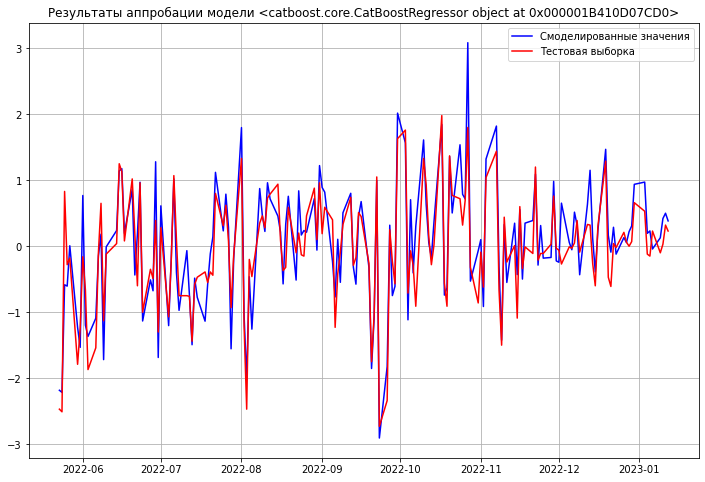

In [33]:
model_checking(cat_reg)

In [256]:
model_names

['LinearRegression()',
 "AdaBoostRegressor(learning_rate=0.005, loss='exponential', n_estimators=100)",
 'RandomForestRegressor(max_depth=2, min_samples_split=8, n_estimators=200)',
 'GradientBoostingRegressor(learning_rate=0.001, max_depth=6, min_samples_split=5,\n                          n_estimators=50)',
 '<catboost.core.CatBoostRegressor object at 0x0000014A09A08B50>']

In [90]:
mse

[0.119239433234939,
 0.0029275125501509163,
 0.0032945365811065494,
 0.00011978541732571558,
 0.16404631569465106]

In [89]:
mae

[0.26816088092199203,
 0.040390081785466096,
 0.04721808259054357,
 0.008040341652826072,
 0.3119965474779767]

In [34]:
df_results['Модель'] = model_names
df_results['MSE'] = mse
df_results['MAE'] = mae
df_results['MAPE'] = mape

In [92]:
df_results.to_excel('results_modelling.xlsx')

In [263]:
x_test.columns

Index(['anger', 'commentsCount', 'day', 'disgust', 'enthusiasm', 'fear',
       'happiness', 'likesCount', 'month', 'neutral', 'sadness',
       'tonality_score', 'toxic_value', 'year', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'rolling_mean'],
      dtype='object')

In [265]:
for_reg.feature_importances_

array([0.07453654, 0.04171814, 0.00230127, 0.05924682, 0.02645294,
       0.08705028, 0.05990064, 0.02367734, 0.00269665, 0.01345155,
       0.00886835, 0.01311581, 0.0106445 , 0.00471832, 0.06553135,
       0.25603789, 0.06332304, 0.07935581, 0.04124442, 0.06612834])

In [266]:
feature_imp_df = pd.DataFrame(zip(x_test.columns, for_reg.feature_importances_))

In [268]:
feature_imp_df.columns = ['Feature','Imp']

In [270]:
feature_imp_df.head(10).to_excel('feature_imp_df.xlsx')

In [271]:
ada_reg.feature_importances_

array([0.07122824, 0.04195968, 0.00939899, 0.042997  , 0.0372553 ,
       0.10343232, 0.08101247, 0.03900648, 0.00796163, 0.01685214,
       0.02836069, 0.01405044, 0.0166775 , 0.01123739, 0.07064929,
       0.17184315, 0.06646846, 0.07436139, 0.04987846, 0.04536897])

In [272]:
feature_imp_df_2 = pd.DataFrame(zip(x_test.columns, ada_reg.feature_importances_))

In [278]:
feature_imp_df_2.head(10).to_excel('feat_imp_ada.xlsx')